<a href="https://colab.research.google.com/github/hayleypc/HawaiiClimate/blob/main/climate_gradient_carbon_summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio rasterstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 130.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 129.2 MB/s eta 0:00:00


In [2]:
import rasterio
import geopandas as gpd
from rasterstats import zonal_stats
import pandas as pd
import numpy as np
import fiona
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from shapely import wkt

In [ ]:
# # Load carbon data
# carbon = gpd.read_file(
#     '/content/carbon_predictions_master_aligned_32604.gpkg',
#     layer='carbon_predictions_master_aligned_32604'
# )

In [58]:
# # Get columns starting with 'd_'
# date_cols = [col for col in carbon.columns if col.startswith('d_')]

# # Initialize storage for results
# trend_data = []
# seasonal_data = []
# residual_data = []
# metrics = []

# total_rows = len(carbon)

# # Process each row
# for i, idx in enumerate(carbon.index):
#     # Progress tracker with percentage
#     print(f"{(i+1)/total_rows*100:.1f}%")

#     # Get time series for this row
#     series = carbon.loc[idx, date_cols]

#     # Check if there are any NaNs in the input data
#     if series.isna().any():
#         # Fill NaNs in input data before decomposition
#         series = series.ffill().bfill()

#         # If still has NaNs (all values were NaN), skip this row
#         if series.isna().any():
#             print(f"Skipping row {idx} - all NaN values")
#             continue

#     # Perform decomposition
#     decomp = seasonal_decompose(series, model='additive', period=12)

#     # Fill NaNs: forward fill first (use last good value), then backward fill (use next good value)
#     trend_filled = pd.Series(decomp.trend).ffill().bfill()
#     seasonal_filled = pd.Series(decomp.seasonal).ffill().bfill()
#     residual_filled = pd.Series(decomp.resid).ffill().bfill()

#     # Store components
#     trend_data.append(trend_filled)
#     seasonal_data.append(seasonal_filled)
#     residual_data.append(residual_filled)

#     # Calculate strength metrics
#     var_resid = np.nanvar(residual_filled)
#     var_detrend = np.nanvar(series - trend_filled)
#     var_deseason = np.nanvar(series - seasonal_filled)

#     # Strength of trend and seasonality (following STL decomposition metrics)
#     strength_trend = max(0, 1 - (var_resid / var_detrend)) if var_detrend != 0 else 0
#     strength_seasonal = max(0, 1 - (var_resid / var_deseason)) if var_deseason != 0 else 0

#     metrics.append({
#         'row_idx': idx,
#         'strength_trend': strength_trend,
#         'strength_seasonal': strength_seasonal,
#         'var_residual': var_resid
#     })

# # Create new dataframes
# trend_df = pd.DataFrame(trend_data, index=[carbon.index[i] for i in range(len(trend_data))], columns=date_cols)
# seasonal_df = pd.DataFrame(seasonal_data, index=[carbon.index[i] for i in range(len(seasonal_data))], columns=date_cols)
# metrics_df = pd.DataFrame(metrics)

# # Replace original date columns with trend values
# carbon_trend = carbon.copy()
# carbon_trend[date_cols] = trend_df

# # Add seasonal columns with 's_' prefix
# seasonal_cols = ['s_' + col[2:] for col in date_cols]  # Replace 'd_' with 's_'
# for orig_col, seas_col in zip(date_cols, seasonal_cols):
#     carbon_trend[seas_col] = seasonal_df[orig_col]

# # Merge metrics into main dataframe
# carbon_trend = carbon_trend.merge(metrics_df, left_index=True, right_on='row_idx', how='left')

In [3]:
carbon_trend = gpd.read_file('carbon_trend.csv')
carbon_trend.head()

field_1 id                lat               lon lat_lon_id  \
0       0  1  -156.348994759659  20.8468830404769          0   
1       1  2  -156.378153083538  20.8758182206596          1   
2       2  3  -156.340831577708  20.7901896361288          2   
3       3  4  -156.452352773314  20.8456405639323          3   
4       4  5  -156.297297881963  20.9193616359825          4   

  landsat_9_unique_locs_id landsat_9_unique_locs_min_dis  \
0                  90812.0                           0.0   
1                 258618.0                           0.0   
2                 155495.0                           0.0   
3                 205993.0                           0.0   
4                  22477.0                           0.0   

  landsat_8_unique_locs_id landsat_8_unique_locs_min_dis  \
0                      1.0                           0.0   
1                      2.0                           0.0   
2                      3.0                           0.0   
3                      4.0                           0.0   
4                      5.0                           0.0   

  landsat_7_unique_locs_id  ...           s_20240708             s_20240807  \
0                 266314.0  ...  0.17384790598958336  -0.049791740438988055   
1                 233903.0  ...  0.19628286005828366    0.03263499993923613   
2                 173589.0  ...  0.16832757503100187   -0.04706131961185491   
3                  18401.0  ...  0.19447757630828377    0.01013440726066479   
4                  23471.0  ...  -0.0953461317398317   -0.24144844721602196   

             s_20240906           s_20241006            s_20241105  \
0   -0.4584059362723214  -0.5429273666294644   -0.4752287106770833   
1   -0.3104737899417162  -0.3830065208940969   -0.3095460607750496   
2   -0.4455584678261409   -0.486525045207093   -0.4155128624689981   
3  -0.32223667488219243  -0.3339790671440973  -0.26773305464409725   
4   -0.5327840912636407  -0.5214863287636408    -0.362173112096974   

              s_20241205 row_idx      strength_trend   strength_seasonal  \
0   -0.13672016781994037       0  0.7059281059026283  0.8163867839261738   
1  -0.039112849465525734       1  0.6939383473362117   0.952618022603584   
2    -0.2143102463975692       2  0.7252561989128952  0.6552001554149268   
3   -0.04096078797743076       3  0.7436391513860496  0.8538550335642164   
4   0.061672634926835355       4  0.6797967432357949  0.7558162494975806   

           var_residual  
0   0.05399848371636085  
1  0.035631675283680005  
2   0.06172751987760993  
3    0.0352171940468323  
4   0.04960796547634648  

[5 rows x 233 columns]

In [5]:
carbon = carbon_trend

In [6]:
# # Convert the geometry column from text to shapely geometry objects
carbon['geometry'] = carbon['geometry'].apply(wkt.loads)

# Convert to GeoDataFrame and set the CRS
carbon = gpd.GeoDataFrame(carbon, geometry='geometry', crs='EPSG:32604')

# Verify it worked
print(carbon.head())
print(carbon.crs)
print(type(carbon))

  field_1 id                lat               lon lat_lon_id  \
0       0  1  -156.348994759659  20.8468830404769          0   
1       1  2  -156.378153083538  20.8758182206596          1   
2       2  3  -156.340831577708  20.7901896361288          2   
3       3  4  -156.452352773314  20.8456405639323          3   
4       4  5  -156.297297881963  20.9193616359825          4   

  landsat_9_unique_locs_id landsat_9_unique_locs_min_dis  \
0                  90812.0                           0.0   
1                 258618.0                           0.0   
2                 155495.0                           0.0   
3                 205993.0                           0.0   
4                  22477.0                           0.0   

  landsat_8_unique_locs_id landsat_8_unique_locs_min_dis  \
0                      1.0                           0.0   
1                      2.0                           0.0   
2                      3.0                           0.0   
3             

In [7]:
# Load covariate layers
climate_bins = rasterio.open('/content/climate_bins.tif')
# rangelands = gpd.read_file('/content/rangeland_pastures_subregion.gpkg')
# pineapple = gpd.read_file('/content/pineapple_sugarcane_subregion.gpkg')
suborders = gpd.read_file('/content/clipped_haleakala_suborders.gpkg')
# baseline = gpd.read_file('/content/2015_ag_baseline_subregion.gpkg')
baseline = gpd.read_file('/content/2015_ag_baseline_subregion_landuse.gpkg')

In [8]:
rpath = "/content/T_max_ann_subregion.tif"

with rasterio.open(rpath) as src:
    carbon = carbon.to_crs(src.crs)

# compute mean of raster within 30 m buffer for each point
baseline["tmax_ann_mean_30m"] = [
    zs["mean"] for zs in zonal_stats(
        baseline,      # geometries
        rpath,                  # raster
        stats=["mean"],
        nodata=None,
        all_touched=True
    )
]


In [9]:
rpath = "/content/rainfall_ann_mm_subregion.tif"

with rasterio.open(rpath) as src:
    carbon = carbon.to_crs(src.crs)

# compute mean of raster within 30 m buffer for each point
baseline["rainfall_ann_mm_30m"] = [
    zs["mean"] for zs in zonal_stats(
        baseline,      # geometries
        rpath,                  # raster
        stats=["mean"],
        nodata=None,
        all_touched=True
    )
]



In [10]:
rpath = '/content/climate_bins.tif'

with rasterio.open(rpath) as src:
    carbon = carbon.to_crs(src.crs)

# compute mean of raster within 30 m buffer for each point
baseline["climate_bin"] = [
    zs["majority"] for zs in zonal_stats(
        baseline,      # geometries
        rpath,                  # raster
        stats=["majority"],
        nodata=None,
        all_touched=True
    )
]



In [219]:
# Add climate bin descriptions
bin_descriptions = {
    1: "cool / all rainfall",
    10: "moderate temperature / low-moderate rainfall",
    11: "moderate temperature / high rainfall",
    20: "warm / low rainfall",
    21: "warm / moderate-high rainfall"
}
baseline['climate_description'] = baseline['climate_bin'].map(bin_descriptions)


In [220]:
baseline['poly_id'] = range(len(baseline))

In [221]:
carbon['d_20161217'].dtype

dtype('float64')

In [222]:
date_cols = [col for col in carbon.columns if col.startswith('d_')]

for col in date_cols:
    carbon[col] = pd.to_numeric(carbon[col], errors='coerce')

In [223]:
# Get all the monthly carbon columns
date_cols = [col for col in carbon.columns if col.startswith('d_')]
print(f"Found {len(date_cols)} monthly predictions")
print(f"Date range: {date_cols[0]} to {date_cols[-1]}")

# Extract year from column names to identify first and last year
def get_year(col):
    date_str = col.split('_')[1]
    return int(date_str[:4])

# Get unique years
years = sorted(set([get_year(col) for col in date_cols]))
first_year = 2017
last_year = 2024

print(f"First year: {first_year}")
print(f"Last year: {last_year}")

# Get columns for first and last year
first_year_cols = [col for col in date_cols if get_year(col) == first_year]
last_year_cols = [col for col in date_cols if get_year(col) == last_year]

print(f"First year columns ({first_year}): {len(first_year_cols)} months")
print(f"Last year columns ({last_year}): {len(last_year_cols)} months")

# Calculate mean carbon across all months
carbon['carbon_mean'] = carbon[date_cols].mean(axis=1)
carbon['carbon_median'] = carbon[date_cols].median(axis=1)
carbon['carbon_std'] = carbon[date_cols].std(axis=1)
carbon['carbon_min'] = carbon[date_cols].min(axis=1)
carbon['carbon_max'] = carbon[date_cols].max(axis=1)

# Add first and last year averages
carbon['carbon_first_year'] = carbon[first_year_cols].mean(axis=1)
carbon['carbon_last_year'] = carbon[last_year_cols].mean(axis=1)

# Calculate change over time
carbon['carbon_change'] = carbon['carbon_last_year'] - carbon['carbon_first_year']
carbon['carbon_pct_change'] = ((carbon['carbon_last_year'] - carbon['carbon_first_year']) / carbon['carbon_first_year']) * 100

# Use the temporal mean for summaries
carbon_col = 'carbon_mean'

print(f"\nCarbon statistics:")
print(f"  Overall mean: {carbon['carbon_mean'].mean():.2f}%")
print(f"  First year ({first_year}) mean: {carbon['carbon_first_year'].mean():.2f}%")
print(f"  Last year ({last_year}) mean: {carbon['carbon_last_year'].mean():.2f}%")
print(f"  Average change: {carbon['carbon_change'].mean():.2f}% ({carbon['carbon_pct_change'].mean():.2f}% change)")

Found 98 monthly predictions
Date range: d_20161217 to d_20241205
First year: 2017
Last year: 2024
First year columns (2017): 12 months
Last year columns (2024): 12 months

Carbon statistics:
  Overall mean: 4.09%
  First year (2017) mean: 4.31%
  Last year (2024) mean: 3.56%
  Average change: -0.75% (-19.92% change)


In [224]:
carbon_landuse = gpd.sjoin(carbon, baseline, how='inner', predicate='intersects')

/usr/local/lib/python3.12/dist-packages/geopandas/tools/sjoin.py:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_reset.reset_index(inplace=True)


In [225]:
# carbon_landuse = gpd.sjoin(carbon_landuse, suborders, how='inner', predicate='intersects')

In [274]:
# [i for i in carbon_landuse.columns]

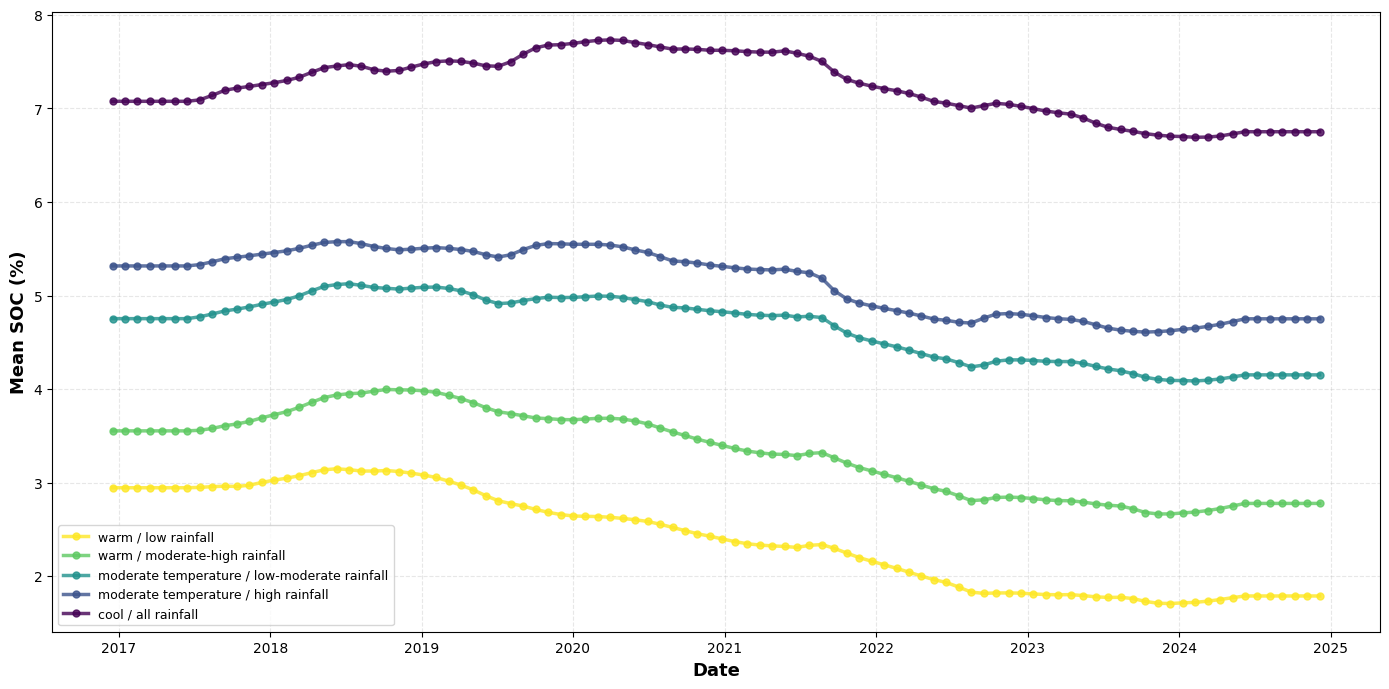


CLIMATE BIN SUMMARY

warm / low rainfall:
  Number of points: 106415
  Mean SOC (all dates): 2.41 ± 0.85%
  Change from 2016 to 2024: -1.16% (-39.2%)

warm / moderate-high rainfall:
  Number of points: 81648
  Mean SOC (all dates): 3.33 ± 1.08%
  Change from 2016 to 2024: -0.78% (-21.8%)

moderate temperature / low-moderate rainfall:
  Number of points: 38262
  Mean SOC (all dates): 4.65 ± 1.29%
  Change from 2016 to 2024: -0.60% (-12.6%)

moderate temperature / high rainfall:
  Number of points: 20073
  Mean SOC (all dates): 5.15 ± 0.97%
  Change from 2016 to 2024: -0.56% (-10.6%)

cool / all rainfall:
  Number of points: 28107
  Mean SOC (all dates): 7.24 ± 1.11%
  Change from 2016 to 2024: -0.33% (-4.6%)


In [285]:
from datetime import datetime

# Get all date columns from carbon_landuse dataframe
date_cols = [col for col in carbon_landuse.columns if col.startswith('d_')]

# Extract dates from column names
dates = [datetime.strptime(col.replace('d_', ''), '%Y%m%d') for col in date_cols]

# Define the order for climate bins
climate_order = [
    'warm / low rainfall',
    'warm / moderate-high rainfall',
    'moderate temperature / low-moderate rainfall',
    'moderate temperature / high rainfall',
    'cool / all rainfall'
]

climate_bins = [c for c in climate_order if c in carbon_landuse['climate_description'].values]

# Create figure
fig, ax = plt.subplots(figsize=(14, 7))

# Define colors for each climate bin
colors = plt.cm.viridis(np.linspace(1, 0, len(climate_bins)))

# Plot for each climate bin
for idx, climate in enumerate(climate_bins):
    # Filter data for this climate bin
    climate_data = carbon_landuse[carbon_landuse['climate_description'] == climate]

    # Calculate mean for each date
    yearly_means = []
    for date_col in date_cols:
        yearly_means.append(climate_data[date_col].mean())

    # Plot
    ax.plot(dates, yearly_means, marker='o', linewidth=2.5, markersize=5,
            label=f'{climate}', color=colors[idx], alpha=0.8)

ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean SOC (%)', fontsize=13, fontweight='bold')
# ax.set_title('Mean Soil Carbon Over Time by Climate Type', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='best', fontsize=9)


plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("CLIMATE BIN SUMMARY")
print("="*80)
for climate in climate_bins:
    climate_data = carbon_landuse[carbon_landuse['climate_description'] == climate]
    print(f"\n{climate}:")
    print(f"  Number of points: {len(climate_data)}")

    # Calculate overall mean across all dates
    all_date_values = climate_data[date_cols].values.flatten()
    print(f"  Mean SOC (all dates): {np.nanmean(all_date_values):.2f} ± {np.nanstd(all_date_values):.2f}%")

    # Calculate trend
    first_date_mean = climate_data[date_cols[0]].mean()
    last_date_mean = climate_data[date_cols[-1]].mean()
    change = last_date_mean - first_date_mean
    pct_change = (change / first_date_mean) * 100
    print(f"  Change from {dates[0].year} to {dates[-1].year}: {change:+.2f}% ({pct_change:+.1f}%)")

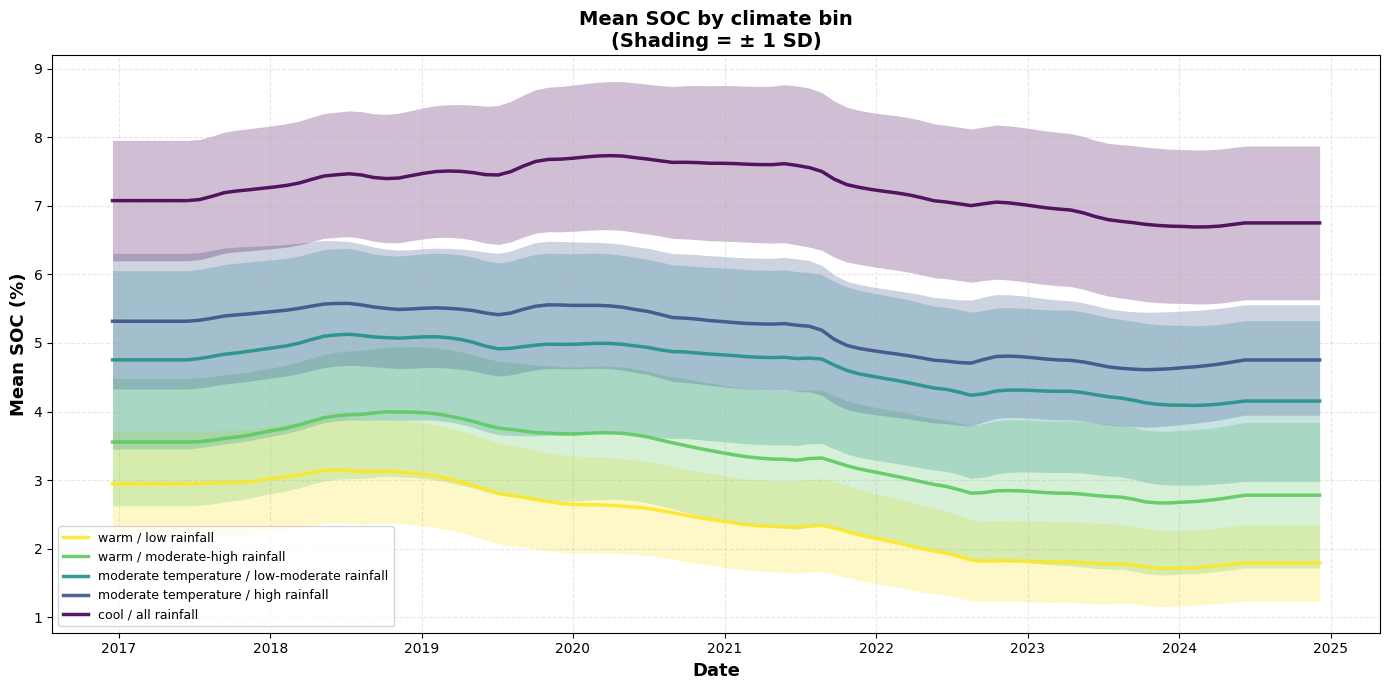


CLIMATE BIN SUMMARY

warm / low rainfall:
  Number of points: 106415
  Mean SOC (all dates): 2.41 ± 0.85%
  Change from 2016 to 2024: -1.16% (-39.2%)

warm / moderate-high rainfall:
  Number of points: 81648
  Mean SOC (all dates): 3.33 ± 1.08%
  Change from 2016 to 2024: -0.78% (-21.8%)

moderate temperature / low-moderate rainfall:
  Number of points: 38262
  Mean SOC (all dates): 4.65 ± 1.29%
  Change from 2016 to 2024: -0.60% (-12.6%)

moderate temperature / high rainfall:
  Number of points: 20073
  Mean SOC (all dates): 5.15 ± 0.97%
  Change from 2016 to 2024: -0.56% (-10.6%)

cool / all rainfall:
  Number of points: 28107
  Mean SOC (all dates): 7.24 ± 1.11%
  Change from 2016 to 2024: -0.33% (-4.6%)


In [286]:
# Get all date columns from carbon_landuse dataframe
date_cols = [col for col in carbon_landuse.columns if col.startswith('d_')]

# Extract dates from column names
dates = [datetime.strptime(col.replace('d_', ''), '%Y%m%d') for col in date_cols]

# Get unique climate bins
climate_bins = [c for c in climate_order if c in carbon_landuse['climate_description'].values]

# Create figure
fig, ax = plt.subplots(figsize=(14, 7))

# Define colors for each climate bin
colors = plt.cm.viridis(np.linspace(1, 0, len(climate_bins)))

# Plot for each climate bin
for idx, climate in enumerate(climate_bins):
    # Filter data for this climate bin
    climate_data = carbon_landuse[carbon_landuse['climate_description'] == climate]

    # Calculate mean and std for each date
    yearly_means = []
    yearly_stds = []

    for date_col in date_cols:
        data = climate_data[date_col].dropna()
        yearly_means.append(data.mean())
        yearly_stds.append(data.std())

    yearly_means = np.array(yearly_means)
    yearly_stds = np.array(yearly_stds)

    # Plot mean line
    ax.plot(dates, yearly_means, linewidth=2.5,
            label=f'{climate}', color=colors[idx], alpha=0.9)

    # Add shaded region showing ± 1 standard deviation
    ax.fill_between(dates,
                    yearly_means - yearly_stds,
                    yearly_means + yearly_stds,
                    color=colors[idx], alpha=0.25, linewidth=0)

ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean SOC (%)', fontsize=13, fontweight='bold')
ax.set_title('Mean SOC by climate bin\n(Shading = ± 1 SD)',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("CLIMATE BIN SUMMARY")
print("="*80)
for climate in climate_bins:
    climate_data = carbon_landuse[carbon_landuse['climate_description'] == climate]
    print(f"\n{climate}:")
    print(f"  Number of points: {len(climate_data)}")

    # Calculate overall mean across all dates
    all_date_values = climate_data[date_cols].values.flatten()
    print(f"  Mean SOC (all dates): {np.nanmean(all_date_values):.2f} ± {np.nanstd(all_date_values):.2f}%")

    # Calculate trend
    first_date_mean = climate_data[date_cols[0]].mean()
    last_date_mean = climate_data[date_cols[-1]].mean()
    change = last_date_mean - first_date_mean
    pct_change = (change / first_date_mean) * 100
    print(f"  Change from {dates[0].year} to {dates[-1].year}: {change:+.2f}% ({pct_change:+.1f}%)")


warm / low rainfall:
  Number of polygons: 66
  Mean range: 1.818 to 3.197
  SE range: 0.035 to 0.057

warm / moderate-high rainfall:
  Number of polygons: 90
  Mean range: 3.124 to 4.284
  SE range: 0.074 to 0.097

moderate temperature / low-moderate rainfall:
  Number of polygons: 75
  Mean range: 4.266 to 5.129
  SE range: 0.106 to 0.136

moderate temperature / high rainfall:
  Number of polygons: 21
  Mean range: 4.622 to 5.554
  SE range: 0.161 to 0.220

cool / all rainfall:
  Number of polygons: 12
  Mean range: 6.505 to 7.419
  SE range: 0.556 to 0.695


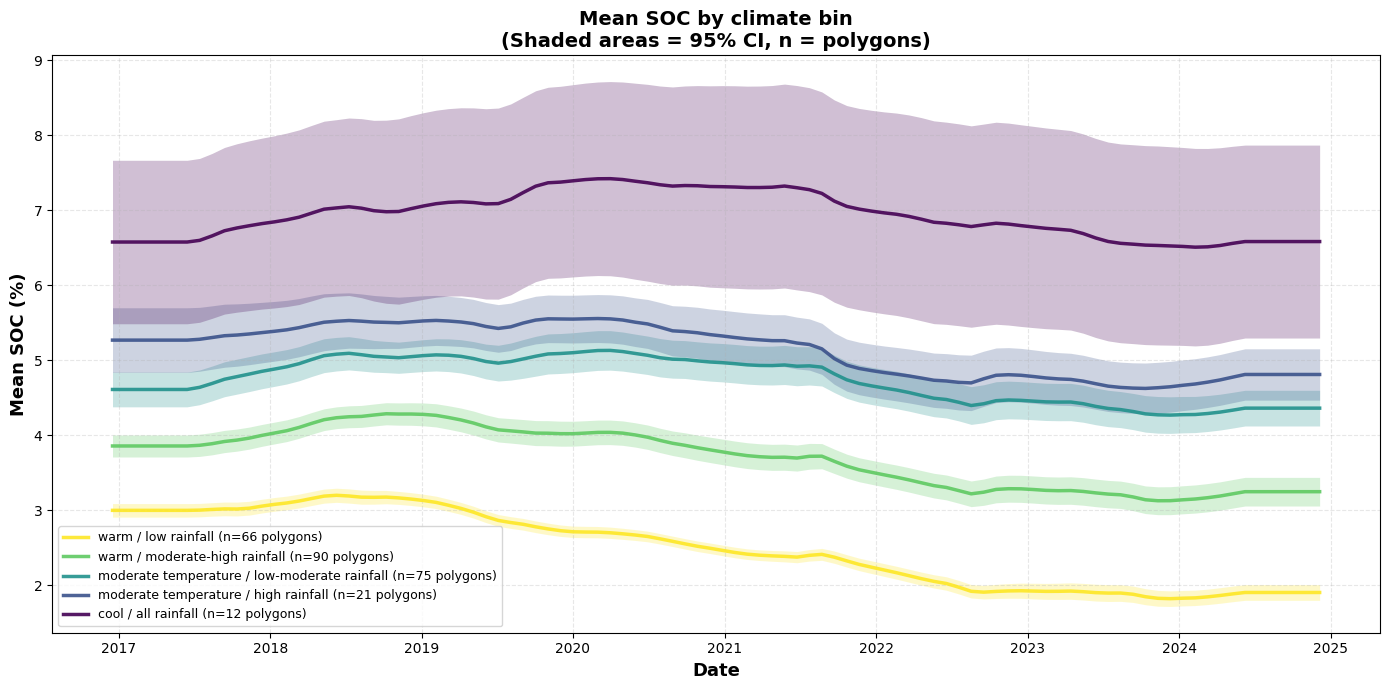

In [288]:
# Get all date columns from carbon_landuse dataframe
date_cols = [col for col in carbon_landuse.columns if col.startswith('d_')]

# Extract dates from column names
dates = [datetime.strptime(col.replace('d_', ''), '%Y%m%d') for col in date_cols]

# Get unique climate bins
climate_bins = [c for c in climate_order if c in carbon_landuse['climate_description'].values]

# Create figure
fig, ax = plt.subplots(figsize=(14, 7))

# Define colors for each climate bin
colors = plt.cm.viridis(np.linspace(1, 0, len(climate_bins)))

# Plot for each climate bin
for idx, climate in enumerate(climate_bins):
    # Filter data for this climate bin
    climate_data = carbon_landuse[carbon_landuse['climate_description'] == climate]

    # Group by polygon and calculate mean for each polygon at each date
    # This gives us one value per polygon per date
    polygon_means_by_date = climate_data.groupby('poly_id')[date_cols].mean()

    # Now calculate the mean and SE across polygons for each date
    yearly_means = []
    yearly_ses = []
    n_polygons = len(polygon_means_by_date)

    for date_col in date_cols:
        polygon_values = polygon_means_by_date[date_col].dropna()
        yearly_means.append(polygon_values.mean())
        yearly_ses.append(polygon_values.std() / np.sqrt(len(polygon_values)))

    yearly_means = np.array(yearly_means)
    yearly_ses = np.array(yearly_ses)

    # Debug: Print some values
    print(f"\n{climate}:")
    print(f"  Number of polygons: {n_polygons}")
    print(f"  Mean range: {yearly_means.min():.3f} to {yearly_means.max():.3f}")
    print(f"  SE range: {yearly_ses.min():.3f} to {yearly_ses.max():.3f}")

    # Plot mean line
    ax.plot(dates, yearly_means, linewidth=2.5,
            label=f'{climate} (n={n_polygons} polygons)', color=colors[idx], alpha=0.9)

    # Add shaded confidence interval (95% CI = mean ± 1.96*SE)
    ax.fill_between(dates,
                    yearly_means - 1.96 * yearly_ses,
                    yearly_means + 1.96 * yearly_ses,
                    color=colors[idx], alpha=0.25, linewidth=0)

ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean SOC (%)', fontsize=13, fontweight='bold')
ax.set_title('Mean SOC by climate bin\n(Shaded areas = 95% CI, n = polygons)',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.show()


In [289]:
# Print summary statistics
print("\n" + "="*80)
print("CLIMATE BIN SUMMARY (POLYGON LEVEL)")
print("="*80)
for climate in climate_bins:
    climate_data = carbon_landuse[carbon_landuse['climate_description'] == climate]

    # Get polygon-level statistics
    polygon_means_by_date = climate_data.groupby('poly_id')[date_cols].mean()
    n_polygons = len(polygon_means_by_date)

    # Overall mean across all dates and polygons
    all_polygon_means = polygon_means_by_date.values.flatten()
    mean_soc = np.nanmean(all_polygon_means)
    std_soc = np.nanstd(all_polygon_means)
    se_soc = std_soc / np.sqrt(len(all_polygon_means))
    ci_lower = mean_soc - 1.96 * se_soc
    ci_upper = mean_soc + 1.96 * se_soc

    print(f"\n{climate}:")
    print(f"  Number of polygons: {n_polygons}")
    print(f"  Mean SOC (all dates): {mean_soc:.2f}%")
    print(f"  SD: {std_soc:.2f}%")
    print(f"  95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]%")

    # Calculate trend using polygon means
    first_date_mean = polygon_means_by_date[date_cols[0]].mean()
    last_date_mean = polygon_means_by_date[date_cols[-1]].mean()
    first_date_std = polygon_means_by_date[date_cols[0]].std()
    last_date_std = polygon_means_by_date[date_cols[-1]].std()
    first_date_se = first_date_std / np.sqrt(n_polygons)
    last_date_se = last_date_std / np.sqrt(n_polygons)

    change = last_date_mean - first_date_mean
    pct_change = (change / first_date_mean) * 100

    print(f"  First date ({dates[0].year}): {first_date_mean:.2f}% (95% CI: [{first_date_mean - 1.96*first_date_se:.2f}, {first_date_mean + 1.96*first_date_se:.2f}])")
    print(f"  Last date ({dates[-1].year}): {last_date_mean:.2f}% (95% CI: [{last_date_mean - 1.96*last_date_se:.2f}, {last_date_mean + 1.96*last_date_se:.2f}])")
    print(f"  Change: {change:+.2f}% ({pct_change:+.1f}%)")


CLIMATE BIN SUMMARY (POLYGON LEVEL)

warm / low rainfall:
  Number of polygons: 66
  Mean SOC (all dates): 2.49%
  SD: 0.61%
  95% CI: [2.47, 2.50]%
  First date (2016): 3.00% (95% CI: [2.91, 3.09])
  Last date (2024): 1.90% (95% CI: [1.80, 2.01])
  Change: -1.10% (-36.5%)

warm / moderate-high rainfall:
  Number of polygons: 90
  Mean SOC (all dates): 3.70%
  SD: 0.89%
  95% CI: [3.68, 3.72]%
  First date (2016): 3.85% (95% CI: [3.71, 4.00])
  Last date (2024): 3.24% (95% CI: [3.05, 3.44])
  Change: -0.61% (-15.8%)

moderate temperature / low-moderate rainfall:
  Number of polygons: 75
  Mean SOC (all dates): 4.73%
  SD: 1.10%
  95% CI: [4.71, 4.76]%
  First date (2016): 4.61% (95% CI: [4.38, 4.84])
  Last date (2024): 4.36% (95% CI: [4.12, 4.60])
  Change: -0.25% (-5.4%)

moderate temperature / high rainfall:
  Number of polygons: 21
  Mean SOC (all dates): 5.14%
  SD: 0.88%
  95% CI: [5.10, 5.18]%
  First date (2016): 5.27% (95% CI: [4.83, 5.70])
  Last date (2024): 4.81% (95% CI: 

In [292]:
# Load the soil suborder geopackage
suborders = gpd.read_file('/content/clipped_haleakala_suborders.gpkg')

print(f"Suborders data: {len(suborders)} features")
print(f"Carbon landuse: {len(carbon_landuse)} points")

# Check if carbon_landuse is a GeoDataFrame with geometry
if 'geometry' not in carbon_landuse.columns:
    print("\nError: carbon_landuse doesn't have geometry column. Cannot perform spatial join.")
else:
    # Drop index_right column if it exists from previous join
    if 'index_right' in carbon_landuse.columns:
        print("Dropping existing 'index_right' column...")
        carbon_landuse = carbon_landuse.drop(columns=['index_right'])

    # Ensure both are GeoDataFrames with same CRS
    carbon_landuse = gpd.GeoDataFrame(carbon_landuse, geometry='geometry')
    print(f"\nCarbon landuse CRS: {carbon_landuse.crs}")
    print(f"Suborders CRS: {suborders.crs}")

    # Reproject if needed
    if carbon_landuse.crs != suborders.crs:
        print("Reprojecting carbon_landuse to match suborders CRS...")
        carbon_landuse = carbon_landuse.to_crs(suborders.crs)

    # Spatial join to get suborder for each point
    print("\nPerforming spatial join...")
    carbon_landuse = gpd.sjoin(carbon_landuse, suborders[['Suborder', 'geometry']],
                                how='left', predicate='within')

    # Rename the column for clarity
    if 'Suborder' in carbon_landuse.columns:
        carbon_landuse.rename(columns={'Suborder': 'soil_suborder'}, inplace=True)

    # Drop the index_right column from the spatial join
    if 'index_right' in carbon_landuse.columns:
        carbon_landuse = carbon_landuse.drop(columns=['index_right'])

    print(f"\nResult: {len(carbon_landuse)} rows (original size maintained)")
    print(f"Points with suborder data: {carbon_landuse['soil_suborder'].notna().sum()}")
    print(f"Points without suborder data: {carbon_landuse['soil_suborder'].isna().sum()}")

    print("\nUnique suborders:")
    print(carbon_landuse['soil_suborder'].value_counts())


Suborders data: 1852 features
Carbon landuse: 274505 points
Dropping existing 'index_right' column...

Carbon landuse CRS: PROJCS["WGS 84 / UTM zone 4N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-159],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32604"]]
Suborders CRS: EPSG:32604

Performing spatial join...

Result: 549010 rows (original size maintained)
Points with suborder data: 547078
Points without suborder data: 1932

Unique suborders:
soil_suborder
Ustolls      205314
Cambids       87084
Torrox        70740
Ustands       

Found 12 soil suborders: ['Andepts', 'Cambids', 'Humults', 'Orthents', 'Psamments', 'Torrands', 'Torrox', 'Udands', 'Ustands', 'Ustepts', 'Ustolls', 'Vitrands']


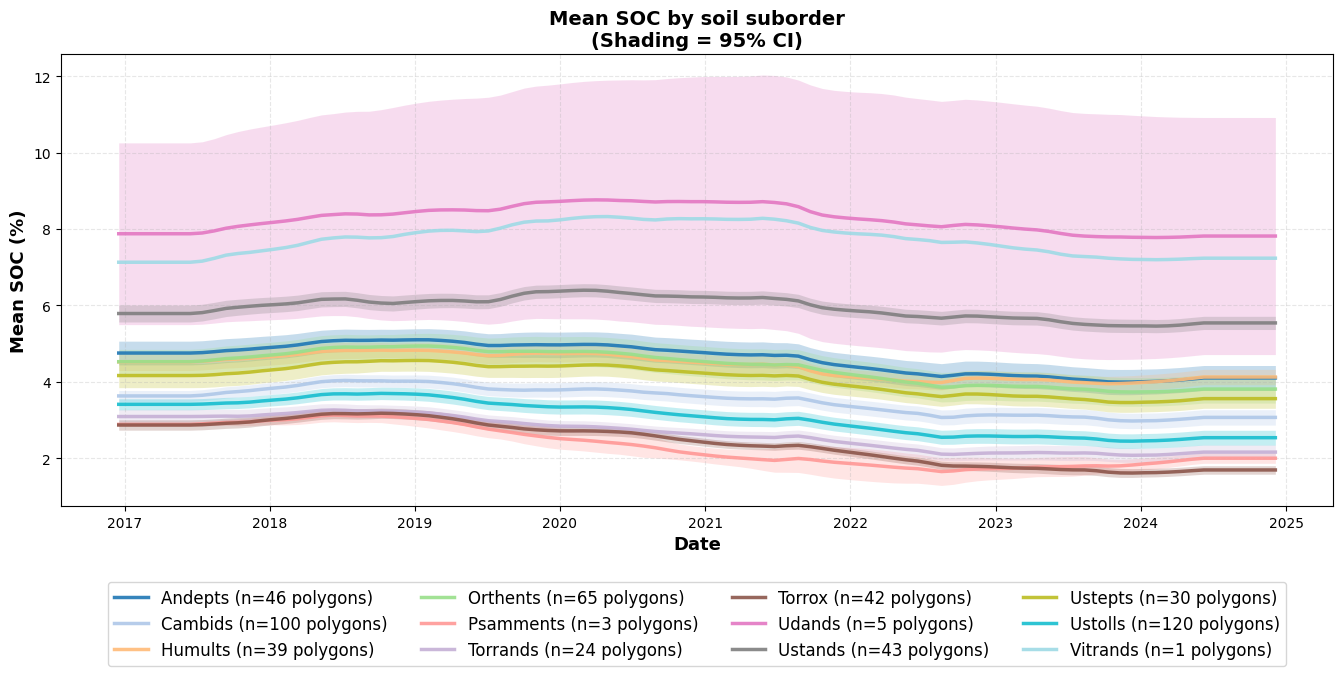


SOIL SUBORDER SUMMARY (POLYGON LEVEL)

Andepts:
  Number of polygons: 46
  Mean SOC (all dates): 4.60%
  SD: 1.16%
  95% CI: [4.57, 4.64]%
  First date (2016): 4.75% (95% CI: [4.44, 5.07])
  Last date (2024): 4.10% (95% CI: [3.78, 4.43])
  Change: -0.65% (-13.7%)

Cambids:
  Number of polygons: 100
  Mean SOC (all dates): 3.52%
  SD: 1.00%
  95% CI: [3.50, 3.54]%
  First date (2016): 3.63% (95% CI: [3.49, 3.78])
  Last date (2024): 3.07% (95% CI: [2.87, 3.27])
  Change: -0.56% (-15.5%)

Humults:
  Number of polygons: 39
  Mean SOC (all dates): 4.41%
  SD: 0.72%
  95% CI: [4.39, 4.43]%
  First date (2016): 4.52% (95% CI: [4.30, 4.75])
  Last date (2024): 4.13% (95% CI: [3.93, 4.33])
  Change: -0.40% (-8.7%)

Orthents:
  Number of polygons: 65
  Mean SOC (all dates): 4.38%
  SD: 1.56%
  95% CI: [4.34, 4.41]%
  First date (2016): 4.53% (95% CI: [4.21, 4.85])
  Last date (2024): 3.81% (95% CI: [3.44, 4.18])
  Change: -0.72% (-15.8%)

Psamments:
  Number of polygons: 3
  Mean SOC (all date

In [300]:
# Get all date columns from carbon_landuse dataframe
date_cols = [col for col in carbon_landuse.columns if col.startswith('d_')]

# Extract dates from column names
dates = [datetime.strptime(col.replace('d_', ''), '%Y%m%d') for col in date_cols]

# Get unique soil suborders
soil_suborders = carbon_landuse['soil_suborder'].unique()
# Remove NaN if present
soil_suborders = [s for s in soil_suborders if pd.notna(s)]

# Sort alphabetically (or you can define a custom order like with climate)
soil_suborders = sorted(soil_suborders)

print(f"Found {len(soil_suborders)} soil suborders: {soil_suborders}")

# Create figure
fig, ax = plt.subplots(figsize=(14, 7))

# Define colors for each soil suborder
colors = plt.cm.tab20(np.linspace(0, 1, len(soil_suborders)))

# Plot for each soil suborder
for idx, soil in enumerate(soil_suborders):
    # Filter data for this soil suborder
    soil_data = carbon_landuse[carbon_landuse['soil_suborder'] == soil]

    # Group by polygon and calculate mean for each polygon at each date
    polygon_means_by_date = soil_data.groupby('poly_id')[date_cols].mean()

    # Now calculate the mean and SE across polygons for each date
    yearly_means = []
    yearly_ses = []
    n_polygons = len(polygon_means_by_date)

    for date_col in date_cols:
        polygon_values = polygon_means_by_date[date_col].dropna()
        yearly_means.append(polygon_values.mean())
        yearly_ses.append(polygon_values.std() / np.sqrt(len(polygon_values)))

    yearly_means = np.array(yearly_means)
    yearly_ses = np.array(yearly_ses)

    # Plot mean line
    ax.plot(dates, yearly_means, linewidth=2.5,
            label=f'{soil} (n={n_polygons} polygons)', color=colors[idx], alpha=0.9)

    # Add shaded confidence interval (95% CI = mean ± 1.96*SE)
    ax.fill_between(dates,
                    yearly_means - 1.96 * yearly_ses,
                    yearly_means + 1.96 * yearly_ses,
                    color=colors[idx], alpha=0.25, linewidth=0)

ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean SOC (%)', fontsize=13, fontweight='bold')
ax.set_title('Mean SOC by soil suborder\n(Shading = 95% CI)',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=4, fontsize=12, frameon=True)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("SOIL SUBORDER SUMMARY (POLYGON LEVEL)")
print("="*80)
for soil in soil_suborders:
    soil_data = carbon_landuse[carbon_landuse['soil_suborder'] == soil]

    # Get polygon-level statistics
    polygon_means_by_date = soil_data.groupby('poly_id')[date_cols].mean()
    n_polygons = len(polygon_means_by_date)

    # Overall mean across all dates and polygons
    all_polygon_means = polygon_means_by_date.values.flatten()
    mean_soc = np.nanmean(all_polygon_means)
    std_soc = np.nanstd(all_polygon_means)
    se_soc = std_soc / np.sqrt(len(all_polygon_means))
    ci_lower = mean_soc - 1.96 * se_soc
    ci_upper = mean_soc + 1.96 * se_soc

    print(f"\n{soil}:")
    print(f"  Number of polygons: {n_polygons}")
    print(f"  Mean SOC (all dates): {mean_soc:.2f}%")
    print(f"  SD: {std_soc:.2f}%")
    print(f"  95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]%")

    # Calculate trend using polygon means
    first_date_mean = polygon_means_by_date[date_cols[0]].mean()
    last_date_mean = polygon_means_by_date[date_cols[-1]].mean()
    first_date_std = polygon_means_by_date[date_cols[0]].std()
    last_date_std = polygon_means_by_date[date_cols[-1]].std()
    first_date_se = first_date_std / np.sqrt(n_polygons)
    last_date_se = last_date_std / np.sqrt(n_polygons)

    change = last_date_mean - first_date_mean
    pct_change = (change / first_date_mean) * 100

    print(f"  First date ({dates[0].year}): {first_date_mean:.2f}% (95% CI: [{first_date_mean - 1.96*first_date_se:.2f}, {first_date_mean + 1.96*first_date_se:.2f}])")
    print(f"  Last date ({dates[-1].year}): {last_date_mean:.2f}% (95% CI: [{last_date_mean - 1.96*last_date_se:.2f}, {last_date_mean + 1.96*last_date_se:.2f}])")
    print(f"  Change: {change:+.2f}% ({pct_change:+.1f}%)")

In [301]:
# Create transition column in carbon_landuse
carbon_landuse['transition'] = (carbon_landuse['landuse_historic'].astype(str) +
                                 ' → ' +
                                 carbon_landuse['landuse_current'].astype(str))

# Check what transitions exist
print("="*80)
print("AVAILABLE TRANSITIONS IN CARBON_LANDUSE")
print("="*80)
print("\nAll transitions in dataset:")
print(carbon_landuse['transition'].value_counts())

# Get date columns for analysis
date_cols = [col for col in carbon_landuse.columns if col.startswith('d_')]

# Filter for pineapple transitions
pineapple_stable = carbon_landuse[carbon_landuse['transition'] == 'pineapple → pineapple']
pineapple_to_range = carbon_landuse[carbon_landuse['transition'] == 'pineapple → range']

# Filter for sugarcane transitions
sugar_stable = carbon_landuse[carbon_landuse['transition'] == 'sugarcane → sugarcane']
sugar_to_range = carbon_landuse[carbon_landuse['transition'] == 'sugarcane → range']

# Filter for range transitions
range_stable = carbon_landuse[carbon_landuse['transition'] == 'range → range']

# Filter for forest transitions
forest_to_range = carbon_landuse[carbon_landuse['transition'] == 'forest → range']

print("\n" + "="*80)
print("TRANSITION SUMMARY BY POINTS")
print("="*80)
print(f"\nPineapple → Pineapple: {len(pineapple_stable)} points")
print(f"Pineapple → Range: {len(pineapple_to_range)} points")
print(f"Sugarcane → Sugarcane: {len(sugar_stable)} points")
print(f"Sugarcane → Range: {len(sugar_to_range)} points")
print(f"Range → Range: {len(range_stable)} points")
print(f"Forest → Range: {len(forest_to_range)} points")

# Calculate mean carbon across all time points for each transition
print("\n" + "="*80)
print("MEAN CARBON BY TRANSITION (across all dates)")
print("="*80)

for transition_name, data in [
    ('Pineapple → Pineapple', pineapple_stable),
    ('Pineapple → Range', pineapple_to_range),
    ('Sugarcane → Sugarcane', sugar_stable),
    ('Sugarcane → Range', sugar_to_range),
    ('Range → Range', range_stable),
    ('Forest → Range', forest_to_range)
]:
    if len(data) > 0:
        # Get all date column values
        all_values = data[date_cols].values.flatten()
        all_values = all_values[~np.isnan(all_values)]  # Remove NaNs
        print(f"\n{transition_name}:")
        print(f"  Points: {len(data)}")
        print(f"  Mean SOC: {np.mean(all_values):.2f} ± {np.std(all_values):.2f}%")
    else:
        print(f"\n{transition_name}: No data")

AVAILABLE TRANSITIONS IN CARBON_LANDUSE

All transitions in dataset:
transition
sugarcane → sugarcane    254596
pineapple → range        116818
sugarcane → range        108778
range → range             56776
forest → range             6606
pineapple → pineapple      5424
None → range                  6
None → None                   6
Name: count, dtype: int64

TRANSITION SUMMARY BY POINTS

Pineapple → Pineapple: 5424 points
Pineapple → Range: 116818 points
Sugarcane → Sugarcane: 254596 points
Sugarcane → Range: 108778 points
Range → Range: 56776 points
Forest → Range: 6606 points

MEAN CARBON BY TRANSITION (across all dates)

Pineapple → Pineapple:
  Points: 5424
  Mean SOC: 4.07 ± 1.06%

Pineapple → Range:
  Points: 116818
  Mean SOC: 4.83 ± 1.18%

Sugarcane → Sugarcane:
  Points: 254596
  Mean SOC: 2.54 ± 0.91%

Sugarcane → Range:
  Points: 108778
  Mean SOC: 3.18 ± 0.96%

Range → Range:
  Points: 56776
  Mean SOC: 7.23 ± 1.10%

Forest → Range:
  Points: 6606
  Mean SOC: 5.60 ± 0.86%

Found 6 land use transitions: ['pineapple → pineapple', 'pineapple → range', 'sugarcane → sugarcane', 'sugarcane → range', 'range → range', 'forest → range']


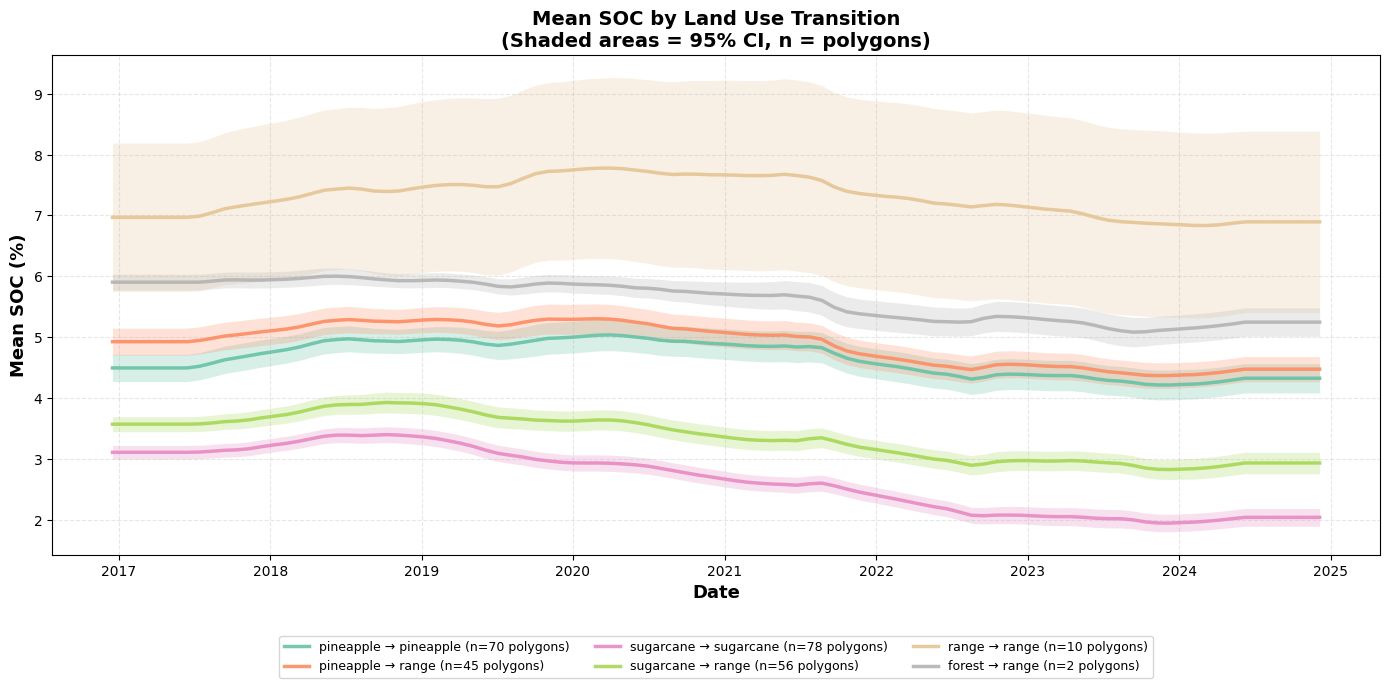


LAND USE TRANSITION SUMMARY (POLYGON LEVEL)

pineapple → pineapple:
  Number of polygons: 70
  Mean SOC (all dates): 4.65%
  SD: 1.05%
  95% CI: [4.62, 4.67]%
  First date (2016): 4.49% (95% CI: [4.27, 4.72])
  Last date (2024): 4.33% (95% CI: [4.08, 4.57])
  Change: -0.17% (-3.8%)

pineapple → range:
  Number of polygons: 45
  Mean SOC (all dates): 4.89%
  SD: 0.83%
  95% CI: [4.86, 4.91]%
  First date (2016): 4.93% (95% CI: [4.70, 5.15])
  Last date (2024): 4.47% (95% CI: [4.27, 4.68])
  Change: -0.45% (-9.2%)

sugarcane → sugarcane:
  Number of polygons: 78
  Mean SOC (all dates): 2.66%
  SD: 0.78%
  95% CI: [2.64, 2.68]%
  First date (2016): 3.11% (95% CI: [3.00, 3.22])
  Last date (2024): 2.04% (95% CI: [1.89, 2.18])
  Change: -1.07% (-34.4%)

sugarcane → range:
  Number of polygons: 56
  Mean SOC (all dates): 3.36%
  SD: 0.70%
  95% CI: [3.34, 3.38]%
  First date (2016): 3.57% (95% CI: [3.45, 3.69])
  Last date (2024): 2.93% (95% CI: [2.76, 3.11])
  Change: -0.64% (-17.9%)

rang

In [302]:
# Get all date columns from carbon_landuse dataframe
date_cols = [col for col in carbon_landuse.columns if col.startswith('d_')]

# Extract dates from column names
dates = [datetime.strptime(col.replace('d_', ''), '%Y%m%d') for col in date_cols]

# Define the order for transitions (optional - customize as needed)
transition_order = [
    'pineapple → pineapple',
    'pineapple → range',
    'sugarcane → sugarcane',
    'sugarcane → range',
    'range → range',
    'forest → range'
]

# Get transitions that exist in the data
transitions = [t for t in transition_order if t in carbon_landuse['transition'].values]

print(f"Found {len(transitions)} land use transitions: {transitions}")

# Create figure
fig, ax = plt.subplots(figsize=(14, 7))

# Define colors for each transition
colors = plt.cm.Set2(np.linspace(0, 1, len(transitions)))

# Plot for each transition
for idx, transition in enumerate(transitions):
    # Filter data for this transition
    transition_data = carbon_landuse[carbon_landuse['transition'] == transition]

    # Group by polygon and calculate mean for each polygon at each date
    polygon_means_by_date = transition_data.groupby('poly_id')[date_cols].mean()

    # Now calculate the mean and SE across polygons for each date
    yearly_means = []
    yearly_ses = []
    n_polygons = len(polygon_means_by_date)

    for date_col in date_cols:
        polygon_values = polygon_means_by_date[date_col].dropna()
        yearly_means.append(polygon_values.mean())
        yearly_ses.append(polygon_values.std() / np.sqrt(len(polygon_values)))

    yearly_means = np.array(yearly_means)
    yearly_ses = np.array(yearly_ses)

    # Plot mean line
    ax.plot(dates, yearly_means, linewidth=2.5,
            label=f'{transition} (n={n_polygons} polygons)', color=colors[idx], alpha=0.9)

    # Add shaded confidence interval (95% CI = mean ± 1.96*SE)
    ax.fill_between(dates,
                    yearly_means - 1.96 * yearly_ses,
                    yearly_means + 1.96 * yearly_ses,
                    color=colors[idx], alpha=0.25, linewidth=0)

ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean SOC (%)', fontsize=13, fontweight='bold')
ax.set_title('Mean SOC by Land Use Transition\n(Shaded areas = 95% CI, n = polygons)',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=3, fontsize=9, frameon=True)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("LAND USE TRANSITION SUMMARY (POLYGON LEVEL)")
print("="*80)
for transition in transitions:
    transition_data = carbon_landuse[carbon_landuse['transition'] == transition]

    # Get polygon-level statistics
    polygon_means_by_date = transition_data.groupby('poly_id')[date_cols].mean()
    n_polygons = len(polygon_means_by_date)

    # Overall mean across all dates and polygons
    all_polygon_means = polygon_means_by_date.values.flatten()
    mean_soc = np.nanmean(all_polygon_means)
    std_soc = np.nanstd(all_polygon_means)
    se_soc = std_soc / np.sqrt(len(all_polygon_means))
    ci_lower = mean_soc - 1.96 * se_soc
    ci_upper = mean_soc + 1.96 * se_soc

    print(f"\n{transition}:")
    print(f"  Number of polygons: {n_polygons}")
    print(f"  Mean SOC (all dates): {mean_soc:.2f}%")
    print(f"  SD: {std_soc:.2f}%")
    print(f"  95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]%")

    # Calculate trend using polygon means
    first_date_mean = polygon_means_by_date[date_cols[0]].mean()
    last_date_mean = polygon_means_by_date[date_cols[-1]].mean()
    first_date_std = polygon_means_by_date[date_cols[0]].std()
    last_date_std = polygon_means_by_date[date_cols[-1]].std()
    first_date_se = first_date_std / np.sqrt(n_polygons)
    last_date_se = last_date_std / np.sqrt(n_polygons)

    change = last_date_mean - first_date_mean
    pct_change = (change / first_date_mean) * 100

    print(f"  First date ({dates[0].year}): {first_date_mean:.2f}% (95% CI: [{first_date_mean - 1.96*first_date_se:.2f}, {first_date_mean + 1.96*first_date_se:.2f}])")
    print(f"  Last date ({dates[-1].year}): {last_date_mean:.2f}% (95% CI: [{last_date_mean - 1.96*last_date_se:.2f}, {last_date_mean + 1.96*last_date_se:.2f}])")
    print(f"  Change: {change:+.2f}% ({pct_change:+.1f}%)")

In [227]:
# Define which columns are categorical vs numeric
categorical_cols = ['CropCatego', 'Island', 'landuse_historic', 'landuse_current',
                   'climate_bin_right', 'climate_description']

numeric_cols = ['carbon_mean', 'carbon_median', 'carbon_std', 'carbon_min', 'carbon_max',
                'climate_bin_left', 'carbon_first_year', 'carbon_last_year',
                'carbon_change', 'carbon_pct_change', 'tmax_ann_mean_30m',
                'rainfall_ann_mm_30m']

# Build aggregation dictionary
agg_dict = {}

# Numeric columns - calculate mean
for col in numeric_cols:
    if col in carbon_landuse.columns:
        agg_dict[col] = 'mean'

# Categorical columns - take mode (most frequent value)
for col in categorical_cols:
    if col in carbon_landuse.columns:
        agg_dict[col] = lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]

# Group by polygon
polygon_summary = carbon_landuse.groupby('poly_id').agg(agg_dict).reset_index()

# Add point count separately
point_counts = carbon_landuse.groupby('poly_id').size().reset_index(name='n_points')
polygon_summary = polygon_summary.merge(point_counts, on='poly_id')

print(f"Original: {len(carbon_landuse)} points")
print(f"Aggregated: {len(polygon_summary)} polygons")
print(f"Points per polygon - Min: {polygon_summary['n_points'].min()}, Max: {polygon_summary['n_points'].max()}, Mean: {polygon_summary['n_points'].mean():.1f}")

# Save
polygon_summary.to_csv('carbon_polygon_summary.csv', index=False)
print("\nSaved carbon_polygon_summary.csv")

Original: 274505 points
Aggregated: 264 polygons
Points per polygon - Min: 1, Max: 25004, Mean: 1039.8

Saved carbon_polygon_summary.csv


In [228]:
polygon_summary

poly_id  carbon_mean  carbon_median  carbon_std  carbon_min  carbon_max  \
0          0     2.692066       2.533013    0.731462    1.758366    3.803315   
1          1     2.683129       2.623756    0.573954    1.915602    3.588160   
2          2     2.171283       2.106822    0.385922    1.573851    2.791935   
3          3     3.584352       3.589569    0.322401    3.071597    4.136236   
4          4     3.395355       3.401705    0.260254    2.968474    3.851546   
..       ...          ...            ...         ...         ...         ...   
259      270     4.812053       4.821984    0.336370    4.252873    5.345098   
260      271     5.100059       5.145403    0.352551    4.545223    5.566964   
261      272     4.382816       4.336067    0.407892    3.774827    5.006070   
262      273     4.998882       5.035824    0.374984    4.430349    5.514789   
263      274     5.707628       5.749748    0.345223    5.144394    6.207595   

     carbon_first_year  carbon_last_year  carbon_change  carbon_pct_change  \
0             3.685999          2.046882      -1.639117         -44.221396   
1             3.429984          2.140615      -1.289369         -37.407344   
2             2.658533          2.194286      -0.464248         -15.407924   
3             3.858377          3.157186      -0.701191         -17.877611   
4             3.341282          3.035184      -0.306098          -8.617075   
..                 ...               ...            ...                ...   
259           4.763437          4.715088      -0.048349          -0.156190   
260           5.342054          4.671404      -0.670650         -12.446898   
261           4.337821          4.204581      -0.133240          -3.060905   
262           5.297383          4.592474      -0.704909         -13.090974   
263           5.984635          5.336134      -0.648501         -11.039353   

     tmax_ann_mean_30m  rainfall_ann_mm_30m CropCatego Island  \
0            28.180918           398.343928      Sugar   Maui   
1            28.214982           408.154358      Sugar   Maui   
2            28.165777           386.899691      Sugar   Maui   
3            27.499537          1076.418094      Sugar   Maui   
4            26.721913          1315.535042      Sugar   Maui   
..                 ...                  ...        ...    ...   
259          26.943327          1468.069250    Pasture   Maui   
260          26.549797          1864.437857    Pasture   Maui   
261          26.617931          1791.139500    Pasture   Maui   
262          26.328283          1993.852700    Pasture   Maui   
263          26.691043          2447.223512    Pasture   Maui   

    landuse_historic landuse_current            climate_description  n_points  
0          sugarcane       sugarcane            warm / low rainfall      2651  
1          sugarcane       sugarcane            warm / low rainfall      1198  
2          sugarcane       sugarcane            warm / low rainfall      1376  
3          sugarcane           range  warm / moderate-high rainfall       360  
4          sugarcane           range  warm / moderate-high rainfall       739  
..               ...             ...                            ...       ...  
259        pineapple           range  warm / moderate-high rainfall       125  
260        pineapple           range  warm / moderate-high rainfall        65  
261        pineapple           range  warm / moderate-high rainfall        34  
262        pineapple           range  warm / moderate-high rainfall       493  
263           forest           range  warm / moderate-high rainfall      1358  

[264 rows x 18 columns]

In [230]:
# Create transition column
polygon_summary['transition'] = (polygon_summary['landuse_historic'].astype(str) +
                                 ' → ' +
                                 polygon_summary['landuse_current'].astype(str))

# Filter for pineapple transitions
pineapple_stable = polygon_summary[polygon_summary['transition'] == 'pineapple → pineapple']['carbon_mean']
pineapple_to_range = polygon_summary[polygon_summary['transition'] == 'pineapple → range']['carbon_mean']

# Filter for sugarcane transitions
sugar_stable = polygon_summary[polygon_summary['transition'] == 'sugarcane → sugarcane']['carbon_mean']
sugar_to_range = polygon_summary[polygon_summary['transition'] == 'sugarcane → range']['carbon_mean']

# Filter for range transitions
range_stable = polygon_summary[polygon_summary['transition'] == 'range → range']['carbon_mean']

# Filter for forest transitions
forest_to_range = polygon_summary[polygon_summary['transition'] == 'forest → range']['carbon_mean']

print("="*80)
print("PINEAPPLE COMPARISONS")
print("="*80)

# Pineapple: stable vs to range
if len(pineapple_stable) > 0 and len(pineapple_to_range) > 0:
    print(f"\npineapple → pineapple: n={len(pineapple_stable)}, mean={pineapple_stable.mean():.2f}%, std={pineapple_stable.std():.2f}%")
    print(f"pineapple → range: n={len(pineapple_to_range)}, mean={pineapple_to_range.mean():.2f}%, std={pineapple_to_range.std():.2f}%")

    t_stat, p_value = stats.ttest_ind(pineapple_stable, pineapple_to_range)
    print(f"\nT-test: pineapple → pineapple vs pineapple → range")
    print(f"  t-statistic: {t_stat:.3f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")
    print(f"  Mean difference: {pineapple_stable.mean() - pineapple_to_range.mean():.2f}%")
else:
    print("Insufficient data for pineapple comparison")
    print(f"  pineapple → pineapple: n={len(pineapple_stable)}")
    print(f"  pineapple → range: n={len(pineapple_to_range)}")

print("\n" + "="*80)
print("SUGARCANE COMPARISONS")
print("="*80)

# Sugar: stable vs to range
if len(sugar_stable) > 0 and len(sugar_to_range) > 0:
    print(f"\nsugarcane → sugarcane: n={len(sugar_stable)}, mean={sugar_stable.mean():.2f}%, std={sugar_stable.std():.2f}%")
    print(f"sugarcane → range: n={len(sugar_to_range)}, mean={sugar_to_range.mean():.2f}%, std={sugar_to_range.std():.2f}%")

    t_stat, p_value = stats.ttest_ind(sugar_stable, sugar_to_range)
    print(f"\nT-test: sugarcane → sugarcane vs sugarcane → range")
    print(f"  t-statistic: {t_stat:.3f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")
    print(f"  Mean difference: {sugar_stable.mean() - sugar_to_range.mean():.2f}%")
else:
    print("Insufficient data for sugar comparison")
    print(f"  sugarcane → sugarcane: n={len(sugar_stable)}")
    print(f"  sugarcane → range: n={len(sugar_to_range)}")

print("\n" + "="*80)
print("RANGE COMPARISONS")
print("="*80)

# Range: stable
if len(range_stable) > 0:
    print(f"\nrange → range: n={len(range_stable)}, mean={range_stable.mean():.2f}%, std={range_stable.std():.2f}%")
else:
    print("Insufficient data for range → range")
    print(f"  range → range: n={len(range_stable)}")

print("\n" + "="*80)
print("FOREST COMPARISONS")
print("="*80)

# Forest: to range
if len(forest_to_range) > 0:
    print(f"\nforest → range: n={len(forest_to_range)}, mean={forest_to_range.mean():.2f}%, std={forest_to_range.std():.2f}%")
else:
    print("Insufficient data for forest → range")
    print(f"  forest → range: n={len(forest_to_range)}")

# Check what transitions actually exist
print("\n" + "="*80)
print("AVAILABLE TRANSITIONS")
print("="*80)
print("\nAll transitions in dataset:")
print(polygon_summary['transition'].value_counts())

PINEAPPLE COMPARISONS

pineapple → pineapple: n=70, mean=4.65%, std=1.00%
pineapple → range: n=45, mean=4.89%, std=0.75%

T-test: pineapple → pineapple vs pineapple → range
  t-statistic: -1.376
  p-value: 0.1716
  Significant at α=0.05: No
  Mean difference: -0.24%

SUGARCANE COMPARISONS

sugarcane → sugarcane: n=78, mean=2.66%, std=0.55%
sugarcane → range: n=56, mean=3.36%, std=0.57%

T-test: sugarcane → sugarcane vs sugarcane → range
  t-statistic: -7.135
  p-value: 0.0000
  Significant at α=0.05: Yes
  Mean difference: -0.70%

RANGE COMPARISONS

range → range: n=10, mean=7.29%, std=2.34%

FOREST COMPARISONS

forest → range: n=2, mean=5.61%, std=0.14%

AVAILABLE TRANSITIONS

All transitions in dataset:
transition
sugarcane → sugarcane    78
pineapple → pineapple    70
sugarcane → range        56
pineapple → range        45
range → range            10
None → None               2
forest → range            2
None → range              1
Name: count, dtype: int64


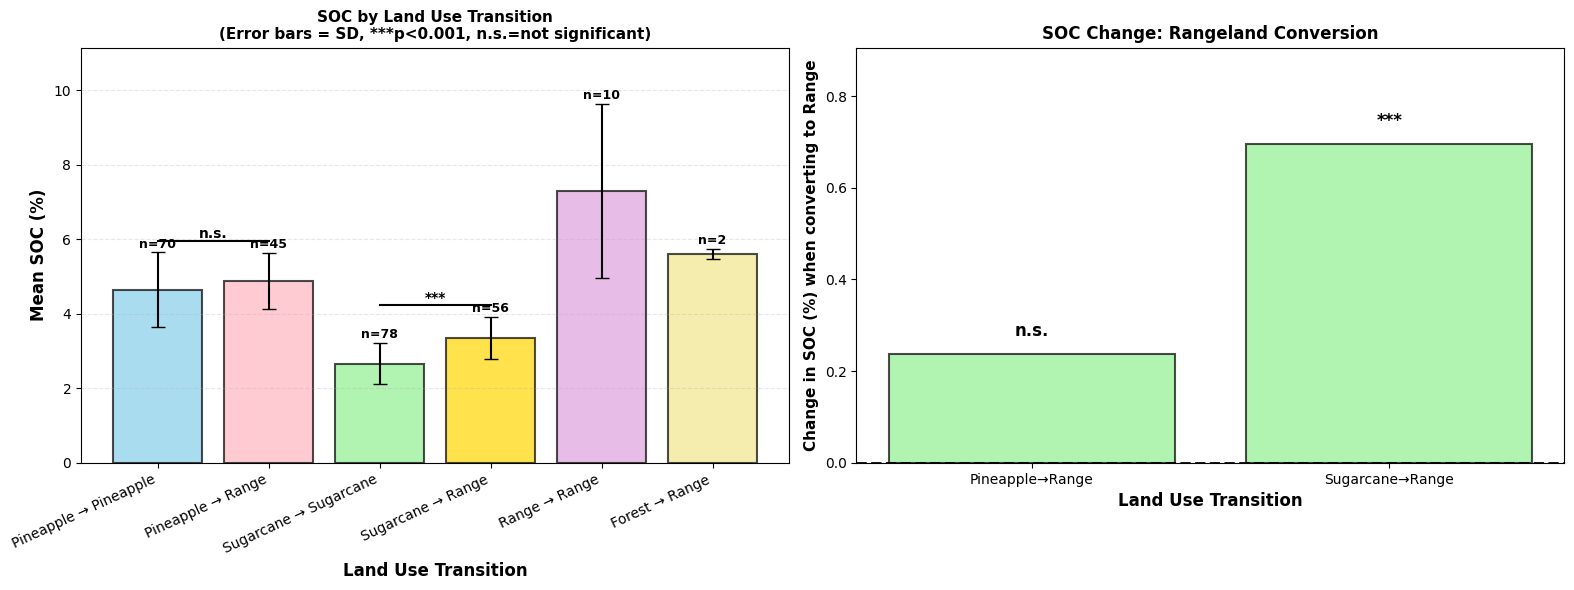


SUMMARY

Pineapple:
  Stable: 4.65 ± 1.00% SD (n=70)
    95% CI: [4.41, 4.88]
  Converted to range: 4.89 ± 0.75% SD (n=45)
    95% CI: [4.67, 5.11]
  Difference: +0.24% (p=0.1716)
  Interpretation: NOT significant

Sugarcane:
  Stable: 2.66 ± 0.55% SD (n=78)
    95% CI: [2.54, 2.78]
  Converted to range: 3.36 ± 0.57% SD (n=56)
    95% CI: [3.21, 3.51]
  Difference: +0.70% (p=0.0000)
  Interpretation: HIGHLY SIGNIFICANT
  Effect size: 26.2% relative increase

Range → Range: 7.29 ± 2.34% SD (n=10)
Forest → Range: 5.61 ± 0.14% SD (n=2)


In [231]:
# Calculate statistics from polygon_summary for each transition
transitions = {
    'pineapple → pineapple': polygon_summary[polygon_summary['transition'] == 'pineapple → pineapple']['carbon_mean'],
    'pineapple → range': polygon_summary[polygon_summary['transition'] == 'pineapple → range']['carbon_mean'],
    'sugarcane → sugarcane': polygon_summary[polygon_summary['transition'] == 'sugarcane → sugarcane']['carbon_mean'],
    'sugarcane → range': polygon_summary[polygon_summary['transition'] == 'sugarcane → range']['carbon_mean'],
    'range → range': polygon_summary[polygon_summary['transition'] == 'range → range']['carbon_mean'],
    'forest → range': polygon_summary[polygon_summary['transition'] == 'forest → range']['carbon_mean']
}

# Extract statistics
categories = []
means = []
stds = []
ns = []

for name, data in transitions.items():
    if len(data) > 0:
        categories.append(name.title().replace('→', '→'))
        means.append(data.mean())
        stds.append(data.std())
        ns.append(len(data))

# Perform t-tests
pineapple_ttest = stats.ttest_ind(transitions['pineapple → pineapple'],
                                   transitions['pineapple → range']) if len(transitions['pineapple → pineapple']) > 0 and len(transitions['pineapple → range']) > 0 else None

sugar_ttest = stats.ttest_ind(transitions['sugarcane → sugarcane'],
                               transitions['sugarcane → range']) if len(transitions['sugarcane → sugarcane']) > 0 and len(transitions['sugarcane → range']) > 0 else None

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# LEFT PLOT: Bar plot with error bars using SD
colors = ['#87CEEB', '#FFB6C1', '#90EE90', '#FFD700', '#DDA0DD', '#F0E68C']
x_pos = np.arange(len(categories))

bars = axes[0].bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7,
                   color=colors[:len(categories)], edgecolor='black', linewidth=1.5)

# Add sample sizes on bars
for i, (bar, n) in enumerate(zip(bars, ns)):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + stds[i] + 0.05,
                f'n={n}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Add significance brackets dynamically
max_height = max([means[i] + stds[i] for i in range(len(means))])

# Pineapple comparison (if data exists)
if pineapple_ttest is not None:
    pine_idx = [i for i, cat in enumerate(categories) if 'pineapple' in cat.lower()]
    if len(pine_idx) == 2:
        bracket_y = max([means[i] + stds[i] for i in pine_idx]) + 0.3
        axes[0].plot([pine_idx[0], pine_idx[1]], [bracket_y, bracket_y], 'k-', linewidth=1.5)
        sig_text = '***' if pineapple_ttest.pvalue < 0.001 else '**' if pineapple_ttest.pvalue < 0.01 else '*' if pineapple_ttest.pvalue < 0.05 else 'n.s.'
        axes[0].text((pine_idx[0] + pine_idx[1])/2, bracket_y + 0.1, sig_text,
                    ha='center', fontsize=10, fontweight='bold')

# Sugarcane comparison (if data exists)
if sugar_ttest is not None:
    sugar_idx = [i for i, cat in enumerate(categories) if 'sugarcane' in cat.lower()]
    if len(sugar_idx) == 2:
        bracket_y = max([means[i] + stds[i] for i in sugar_idx]) + 0.3
        axes[0].plot([sugar_idx[0], sugar_idx[1]], [bracket_y, bracket_y], 'k-', linewidth=1.5)
        sig_text = '***' if sugar_ttest.pvalue < 0.001 else '**' if sugar_ttest.pvalue < 0.01 else '*' if sugar_ttest.pvalue < 0.05 else 'n.s.'
        axes[0].text((sugar_idx[0] + sugar_idx[1])/2, bracket_y + 0.1, sig_text,
                    ha='center', fontsize=10, fontweight='bold')

axes[0].set_ylabel('Mean SOC (%)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Land Use Transition', fontsize=12, fontweight='bold')
axes[0].set_title('SOC by Land Use Transition\n(Error bars = SD, ***p<0.001, n.s.=not significant)',
                  fontsize=11, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(categories, rotation=25, ha='right')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].set_ylim(0, max_height + 1.5)

# RIGHT PLOT: Difference plot showing change
differences = []
diff_labels = []
diff_colors = []
sig_markers = []

# Pineapple difference
if 'pineapple → pineapple' in transitions and 'pineapple → range' in transitions:
    if len(transitions['pineapple → pineapple']) > 0 and len(transitions['pineapple → range']) > 0:
        diff = transitions['pineapple → range'].mean() - transitions['pineapple → pineapple'].mean()
        differences.append(diff)
        diff_labels.append('Pineapple→Range')
        diff_colors.append('#FF6B6B' if diff < 0 else '#90EE90')
        sig_text = '***' if pineapple_ttest.pvalue < 0.001 else '**' if pineapple_ttest.pvalue < 0.01 else '*' if pineapple_ttest.pvalue < 0.05 else 'n.s.'
        sig_markers.append(sig_text)

# Sugarcane difference
if 'sugarcane → sugarcane' in transitions and 'sugarcane → range' in transitions:
    if len(transitions['sugarcane → sugarcane']) > 0 and len(transitions['sugarcane → range']) > 0:
        diff = transitions['sugarcane → range'].mean() - transitions['sugarcane → sugarcane'].mean()
        differences.append(diff)
        diff_labels.append('Sugarcane→Range')
        diff_colors.append('#FF6B6B' if diff < 0 else '#90EE90')
        sig_text = '***' if sugar_ttest.pvalue < 0.001 else '**' if sugar_ttest.pvalue < 0.01 else '*' if sugar_ttest.pvalue < 0.05 else 'n.s.'
        sig_markers.append(sig_text)

if len(differences) > 0:
    x_pos2 = np.arange(len(differences))
    bars2 = axes[1].bar(x_pos2, differences, alpha=0.7, color=diff_colors,
                        edgecolor='black', linewidth=1.5)

    # Add zero line
    axes[1].axhline(y=0, color='black', linestyle='--', linewidth=2)

    # Add significance markers
    for i, (bar, sig) in enumerate(zip(bars2, sig_markers)):
        height = bar.get_height()
        y_pos = height + 0.03 if height > 0 else height - 0.03
        va = 'bottom' if height > 0 else 'top'
        axes[1].text(bar.get_x() + bar.get_width()/2., y_pos, sig,
                    ha='center', va=va, fontweight='bold', fontsize=12)

    axes[1].set_ylabel('Change in SOC (%) when converting to Range', fontsize=11, fontweight='bold')
    axes[1].set_xlabel('Land Use Transition', fontsize=12, fontweight='bold')
    axes[1].set_title('SOC Change: Rangeland Conversion',
                      fontsize=12, fontweight='bold')
    axes[1].set_xticks(x_pos2)
    axes[1].set_xticklabels(diff_labels)
    y_max = max([abs(d) for d in differences]) * 1.3
    axes[1].set_ylim(0, y_max)

plt.tight_layout()
plt.show()

# Print summary with both SD and confidence intervals
print("\n" + "="*80)
print("SUMMARY")
print("="*80)

if pineapple_ttest is not None:
    pine_stable = transitions['pineapple → pineapple']
    pine_range = transitions['pineapple → range']
    pine_stable_se = pine_stable.std() / np.sqrt(len(pine_stable))
    pine_range_se = pine_range.std() / np.sqrt(len(pine_range))

    print("\nPineapple:")
    print(f"  Stable: {pine_stable.mean():.2f} ± {pine_stable.std():.2f}% SD (n={len(pine_stable)})")
    print(f"    95% CI: [{pine_stable.mean() - 1.96*pine_stable_se:.2f}, {pine_stable.mean() + 1.96*pine_stable_se:.2f}]")
    print(f"  Converted to range: {pine_range.mean():.2f} ± {pine_range.std():.2f}% SD (n={len(pine_range)})")
    print(f"    95% CI: [{pine_range.mean() - 1.96*pine_range_se:.2f}, {pine_range.mean() + 1.96*pine_range_se:.2f}]")
    print(f"  Difference: {pine_range.mean() - pine_stable.mean():+.2f}% (p={pineapple_ttest.pvalue:.4f})")
    sig_status = "SIGNIFICANT" if pineapple_ttest.pvalue < 0.05 else "NOT significant"
    print(f"  Interpretation: {sig_status}")

if sugar_ttest is not None:
    sugar_stable = transitions['sugarcane → sugarcane']
    sugar_range = transitions['sugarcane → range']
    sugar_stable_se = sugar_stable.std() / np.sqrt(len(sugar_stable))
    sugar_range_se = sugar_range.std() / np.sqrt(len(sugar_range))

    print("\nSugarcane:")
    print(f"  Stable: {sugar_stable.mean():.2f} ± {sugar_stable.std():.2f}% SD (n={len(sugar_stable)})")
    print(f"    95% CI: [{sugar_stable.mean() - 1.96*sugar_stable_se:.2f}, {sugar_stable.mean() + 1.96*sugar_stable_se:.2f}]")
    print(f"  Converted to range: {sugar_range.mean():.2f} ± {sugar_range.std():.2f}% SD (n={len(sugar_range)})")
    print(f"    95% CI: [{sugar_range.mean() - 1.96*sugar_range_se:.2f}, {sugar_range.mean() + 1.96*sugar_range_se:.2f}]")
    print(f"  Difference: {sugar_range.mean() - sugar_stable.mean():+.2f}% (p={sugar_ttest.pvalue:.4f})")
    sig_status = "HIGHLY SIGNIFICANT" if sugar_ttest.pvalue < 0.001 else "SIGNIFICANT" if sugar_ttest.pvalue < 0.05 else "NOT significant"
    print(f"  Interpretation: {sig_status}")
    if sugar_ttest.pvalue < 0.05:
        print(f"  Effect size: {((sugar_range.mean()/sugar_stable.mean())-1)*100:.1f}% relative increase")

# Print info about new categories
if len(transitions['range → range']) > 0:
    range_data = transitions['range → range']
    print(f"\nRange → Range: {range_data.mean():.2f} ± {range_data.std():.2f}% SD (n={len(range_data)})")

if len(transitions['forest → range']) > 0:
    forest_data = transitions['forest → range']
    print(f"Forest → Range: {forest_data.mean():.2f} ± {forest_data.std():.2f}% SD (n={len(forest_data)})")

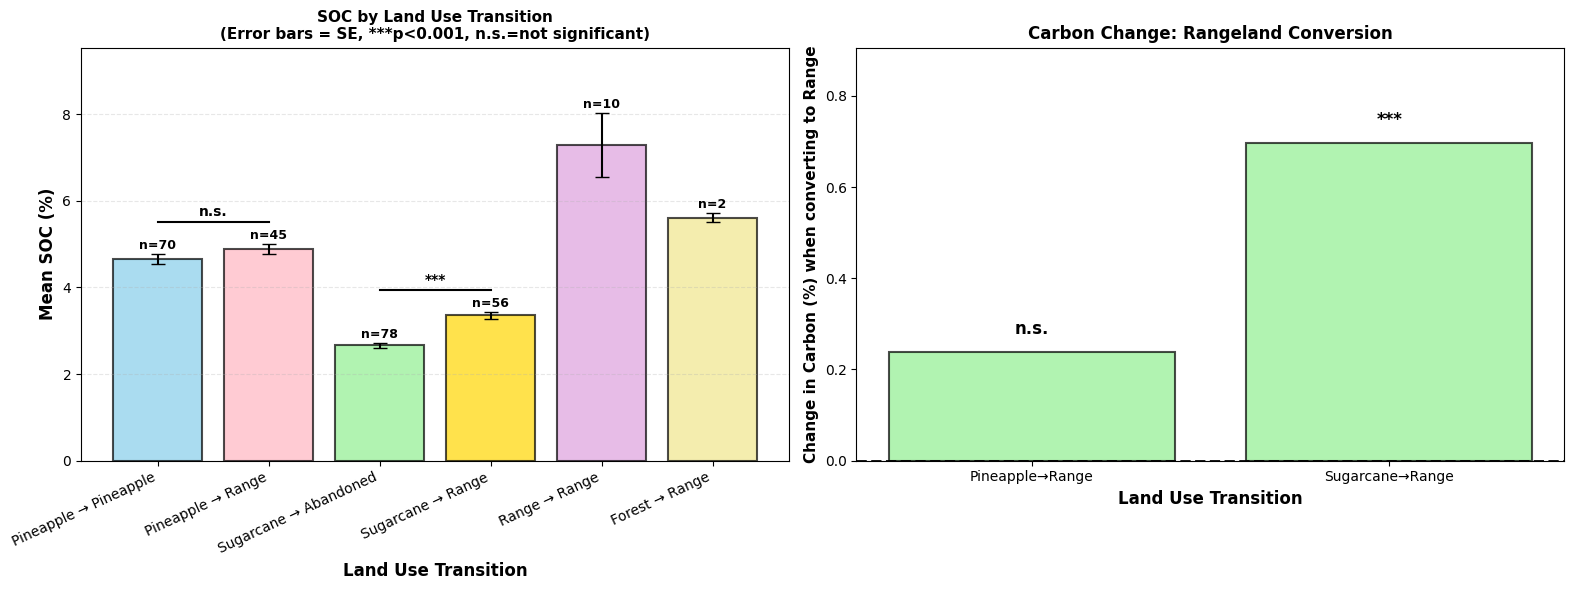


SUMMARY

Pineapple:
  Stable: 4.65% carbon (n=70)
  Converted to range: 4.89% carbon (n=45)
  Difference: +0.24% carbon (p=0.1716)
  Interpretation: NOT significant

Sugarcane:
  Stable: 2.66% carbon (n=78)
  Converted to range: 3.36% carbon (n=56)
  Difference: +0.70% carbon (p=0.0000)
  Interpretation: HIGHLY SIGNIFICANT
  Effect size: 26.2% relative increase

Range → Range: 7.29% carbon (n=10)
Forest → Range: 5.61% carbon (n=2)


In [313]:
# Calculate statistics from polygon_summary for each transition
transitions = {
    'pineapple → pineapple': polygon_summary[polygon_summary['transition'] == 'pineapple → pineapple']['carbon_mean'],
    'pineapple → range': polygon_summary[polygon_summary['transition'] == 'pineapple → range']['carbon_mean'],
    'sugarcane → abandoned': polygon_summary[polygon_summary['transition'] == 'sugarcane → sugarcane']['carbon_mean'],
    'sugarcane → range': polygon_summary[polygon_summary['transition'] == 'sugarcane → range']['carbon_mean'],
    'range → range': polygon_summary[polygon_summary['transition'] == 'range → range']['carbon_mean'],
    'forest → range': polygon_summary[polygon_summary['transition'] == 'forest → range']['carbon_mean']
}

# Extract statistics
categories = []
means = []
stds = []
ns = []

for name, data in transitions.items():
    if len(data) > 0:
        categories.append(name.title().replace('→', '→'))
        means.append(data.mean())
        stds.append(data.std())
        ns.append(len(data))

# Calculate standard errors
ses = [stds[i] / np.sqrt(ns[i]) for i in range(len(stds))]

# Perform t-tests
pineapple_ttest = stats.ttest_ind(transitions['pineapple → pineapple'],
                                   transitions['pineapple → range']) if len(transitions['pineapple → pineapple']) > 0 and len(transitions['pineapple → range']) > 0 else None

sugar_ttest = stats.ttest_ind(transitions['sugarcane → abandoned'],
                               transitions['sugarcane → range']) if len(transitions['sugarcane → abandoned']) > 0 and len(transitions['sugarcane → range']) > 0 else None

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# LEFT PLOT: Bar plot with error bars
colors = ['#87CEEB', '#FFB6C1', '#90EE90', '#FFD700', '#DDA0DD', '#F0E68C']
x_pos = np.arange(len(categories))

bars = axes[0].bar(x_pos, means, yerr=ses, capsize=5, alpha=0.7,
                   color=colors[:len(categories)], edgecolor='black', linewidth=1.5)

# Add sample sizes on bars
for i, (bar, n) in enumerate(zip(bars, ns)):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + ses[i] + 0.05,
                f'n={n}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Add significance brackets dynamically
max_height = max([means[i] + ses[i] for i in range(len(means))])

# Pineapple comparison (if data exists)
if pineapple_ttest is not None:
    pine_idx = [i for i, cat in enumerate(categories) if 'pineapple' in cat.lower()]
    if len(pine_idx) == 2:
        bracket_y = max([means[i] + ses[i] for i in pine_idx]) + 0.5
        axes[0].plot([pine_idx[0], pine_idx[1]], [bracket_y, bracket_y], 'k-', linewidth=1.5)
        sig_text = '***' if pineapple_ttest.pvalue < 0.001 else '**' if pineapple_ttest.pvalue < 0.01 else '*' if pineapple_ttest.pvalue < 0.05 else 'n.s.'
        axes[0].text((pine_idx[0] + pine_idx[1])/2, bracket_y + 0.15, sig_text,
                    ha='center', fontsize=10, fontweight='bold')

# Sugarcane comparison (if data exists)
if sugar_ttest is not None:
    sugar_idx = [i for i, cat in enumerate(categories) if 'sugarcane' in cat.lower()]
    if len(sugar_idx) == 2:
        bracket_y = max([means[i] + ses[i] for i in sugar_idx]) + 0.5
        axes[0].plot([sugar_idx[0], sugar_idx[1]], [bracket_y, bracket_y], 'k-', linewidth=1.5)
        sig_text = '***' if sugar_ttest.pvalue < 0.001 else '**' if sugar_ttest.pvalue < 0.01 else '*' if sugar_ttest.pvalue < 0.05 else 'n.s.'
        axes[0].text((sugar_idx[0] + sugar_idx[1])/2, bracket_y + 0.15, sig_text,
                    ha='center', fontsize=10, fontweight='bold')

axes[0].set_ylabel('Mean SOC (%)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Land Use Transition', fontsize=12, fontweight='bold')
axes[0].set_title('SOC by Land Use Transition\n(Error bars = SE, ***p<0.001, n.s.=not significant)',
                  fontsize=11, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(categories, rotation=25, ha='right')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].set_ylim(0, max_height + 1.5)

# RIGHT PLOT: Difference plot showing change
differences = []
diff_labels = []
diff_colors = []
sig_markers = []

# Pineapple difference
if 'pineapple → pineapple' in transitions and 'pineapple → range' in transitions:
    if len(transitions['pineapple → pineapple']) > 0 and len(transitions['pineapple → range']) > 0:
        diff = transitions['pineapple → range'].mean() - transitions['pineapple → pineapple'].mean()
        differences.append(diff)
        diff_labels.append('Pineapple→Range')
        diff_colors.append('#FF6B6B' if diff < 0 else '#90EE90')
        sig_text = '***' if pineapple_ttest.pvalue < 0.001 else '**' if pineapple_ttest.pvalue < 0.01 else '*' if pineapple_ttest.pvalue < 0.05 else 'n.s.'
        sig_markers.append(sig_text)

# Sugarcane difference
if 'sugarcane → abandoned' in transitions and 'sugarcane → range' in transitions:
    if len(transitions['sugarcane → abandoned']) > 0 and len(transitions['sugarcane → range']) > 0:
        diff = transitions['sugarcane → range'].mean() - transitions['sugarcane → abandoned'].mean()
        differences.append(diff)
        diff_labels.append('Sugarcane→Range')
        diff_colors.append('#FF6B6B' if diff < 0 else '#90EE90')
        sig_text = '***' if sugar_ttest.pvalue < 0.001 else '**' if sugar_ttest.pvalue < 0.01 else '*' if sugar_ttest.pvalue < 0.05 else 'n.s.'
        sig_markers.append(sig_text)

if len(differences) > 0:
    x_pos2 = np.arange(len(differences))
    bars2 = axes[1].bar(x_pos2, differences, alpha=0.7, color=diff_colors,
                        edgecolor='black', linewidth=1.5)

    # Add zero line
    axes[1].axhline(y=0, color='black', linestyle='--', linewidth=2)

    # Add significance markers
    for i, (bar, sig) in enumerate(zip(bars2, sig_markers)):
        height = bar.get_height()
        y_pos = height + 0.03 if height > 0 else height - 0.03
        va = 'bottom' if height > 0 else 'top'
        axes[1].text(bar.get_x() + bar.get_width()/2., y_pos, sig,
                    ha='center', va=va, fontweight='bold', fontsize=12)

    axes[1].set_ylabel('Change in Carbon (%) when converting to Range', fontsize=11, fontweight='bold')
    axes[1].set_xlabel('Land Use Transition', fontsize=12, fontweight='bold')
    axes[1].set_title('Carbon Change: Rangeland Conversion',
                      fontsize=12, fontweight='bold')
    axes[1].set_xticks(x_pos2)
    axes[1].set_xticklabels(diff_labels)
    y_max = max([abs(d) for d in differences]) * 1.3
    axes[1].set_ylim(0, y_max)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*80)
print("SUMMARY")
print("="*80)

if pineapple_ttest is not None:
    pine_stable = transitions['pineapple → pineapple'].mean()
    pine_range = transitions['pineapple → range'].mean()
    print("\nPineapple:")
    print(f"  Stable: {pine_stable:.2f}% carbon (n={len(transitions['pineapple → pineapple'])})")
    print(f"  Converted to range: {pine_range:.2f}% carbon (n={len(transitions['pineapple → range'])})")
    print(f"  Difference: {pine_range - pine_stable:+.2f}% carbon (p={pineapple_ttest.pvalue:.4f})")
    sig_status = "SIGNIFICANT" if pineapple_ttest.pvalue < 0.05 else "NOT significant"
    print(f"  Interpretation: {sig_status}")

if sugar_ttest is not None:
    sugar_stable = transitions['sugarcane → abandoned'].mean()
    sugar_range = transitions['sugarcane → range'].mean()
    print("\nSugarcane:")
    print(f"  Stable: {sugar_stable:.2f}% carbon (n={len(transitions['sugarcane → abandoned'])})")
    print(f"  Converted to range: {sugar_range:.2f}% carbon (n={len(transitions['sugarcane → range'])})")
    print(f"  Difference: {sugar_range - sugar_stable:+.2f}% carbon (p={sugar_ttest.pvalue:.4f})")
    sig_status = "HIGHLY SIGNIFICANT" if sugar_ttest.pvalue < 0.001 else "SIGNIFICANT" if sugar_ttest.pvalue < 0.05 else "NOT significant"
    print(f"  Interpretation: {sig_status}")
    if sugar_ttest.pvalue < 0.05:
        print(f"  Effect size: {((sugar_range/sugar_stable)-1)*100:.1f}% relative increase")

# Print info about new categories
if len(transitions['range → range']) > 0:
    print(f"\nRange → Range: {transitions['range → range'].mean():.2f}% carbon (n={len(transitions['range → range'])})")

if len(transitions['forest → range']) > 0:
    print(f"Forest → Range: {transitions['forest → range'].mean():.2f}% carbon (n={len(transitions['forest → range'])})")

In [304]:
from scipy import stats
import pandas as pd
import numpy as np

# ============================================================================
# ANOVA 1: Mean Soil Carbon by Land Use Transition
# ============================================================================

print("="*80)
print("ANOVA: MEAN SOIL CARBON BY LAND USE TRANSITION")
print("="*80)

# Get polygon-level data (one value per polygon)
# Use polygon_summary which already has carbon_mean aggregated by polygon
transition_groups = []
transition_labels = []

for transition in polygon_summary['transition'].unique():
    if pd.notna(transition):
        data = polygon_summary[polygon_summary['transition'] == transition]['carbon_mean'].dropna()
        if len(data) > 1:  # Need at least 2 samples for statistical tests
            transition_groups.append(data)
            transition_labels.append(transition)

# Run one-way ANOVA
f_stat, p_value = stats.f_oneway(*transition_groups)

print(f"\nOne-way ANOVA Results:")
print(f"  Number of groups: {len(transition_groups)}")
print(f"  F-statistic: {f_stat:.3f}")
print(f"  p-value: {p_value:.6f}")
print(f"  Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")

# Summary statistics by group
print(f"\nDescriptive Statistics by Transition:")
print(f"{'Transition':<35} {'n':>5} {'Mean':>8} {'SD':>8}")
print("-"*60)
for label, group in zip(transition_labels, transition_groups):
    print(f"{label:<35} {len(group):>5} {group.mean():>8.2f} {group.std():>8.2f}")

# Post-hoc pairwise comparisons (Tukey HSD)
if len(transition_groups) >= 2:
    print(f"\n" + "="*80)
    print("POST-HOC: PAIRWISE COMPARISONS (Tukey HSD)")
    print("="*80)

    from scipy.stats import tukey_hsd

    # Run Tukey HSD
    res = tukey_hsd(*transition_groups)

    print("\nPairwise comparisons:")
    print(f"{'Comparison':<50} {'Mean Diff':>10} {'p-value':>10} {'Significant':>12}")
    print("-"*85)

    for i in range(len(transition_labels)):
        for j in range(i+1, len(transition_labels)):
            mean_diff = transition_groups[i].mean() - transition_groups[j].mean()
            p_val = res.pvalue[i, j]
            sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "n.s."
            print(f"{transition_labels[i]} vs {transition_labels[j]:<25} {mean_diff:>10.3f} {p_val:>10.6f} {sig:>12}")
else:
    print("\nInsufficient groups for post-hoc testing (need at least 2 groups)")


# ============================================================================
# ANOVA 2: Mean Soil Carbon by Climate Bin
# ============================================================================

print("\n\n" + "="*80)
print("ANOVA: MEAN SOIL CARBON BY CLIMATE BIN")
print("="*80)

# Get polygon-level data by climate
climate_groups = []
climate_labels = []

for climate in polygon_summary['climate_description'].unique():
    if pd.notna(climate):
        data = polygon_summary[polygon_summary['climate_description'] == climate]['carbon_mean'].dropna()
        if len(data) > 1:  # Need at least 2 samples
            climate_groups.append(data)
            climate_labels.append(climate)

# Run one-way ANOVA
f_stat, p_value = stats.f_oneway(*climate_groups)

print(f"\nOne-way ANOVA Results:")
print(f"  Number of groups: {len(climate_groups)}")
print(f"  F-statistic: {f_stat:.3f}")
print(f"  p-value: {p_value:.6f}")
print(f"  Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")

# Summary statistics by group
print(f"\nDescriptive Statistics by Climate Bin:")
print(f"{'Climate Bin':<40} {'n':>5} {'Mean':>8} {'SD':>8}")
print("-"*65)
for label, group in zip(climate_labels, climate_groups):
    print(f"{label:<40} {len(group):>5} {group.mean():>8.2f} {group.std():>8.2f}")

# Post-hoc pairwise comparisons (Tukey HSD)
if len(climate_groups) >= 2:
    print(f"\n" + "="*80)
    print("POST-HOC: PAIRWISE COMPARISONS (Tukey HSD)")
    print("="*80)

    from scipy.stats import tukey_hsd

    # Run Tukey HSD
    res = tukey_hsd(*climate_groups)

    print("\nPairwise comparisons:")
    print(f"{'Comparison':<65} {'Mean Diff':>10} {'p-value':>10} {'Significant':>12}")
    print("-"*100)

    for i in range(len(climate_labels)):
        for j in range(i+1, len(climate_labels)):
            mean_diff = climate_groups[i].mean() - climate_groups[j].mean()
            p_val = res.pvalue[i, j]
            sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "n.s."
            print(f"{climate_labels[i]} vs {climate_labels[j]:<40} {mean_diff:>10.3f} {p_val:>10.6f} {sig:>12}")
else:
    print("\nInsufficient groups for post-hoc testing (need at least 2 groups)")


# ============================================================================
# Check ANOVA Assumptions
# ============================================================================

print("\n\n" + "="*80)
print("CHECKING ANOVA ASSUMPTIONS")
print("="*80)

# 1. Test for homogeneity of variance (Levene's test)
print("\n1. Homogeneity of Variance (Levene's Test):")

if len(transition_groups) >= 2:
    print("\nLand Use Transition:")
    stat, p = stats.levene(*transition_groups)
    print(f"  Test statistic: {stat:.3f}, p-value: {p:.6f}")
    print(f"  Equal variances: {'Yes (assumption met)' if p > 0.05 else 'No (assumption violated)'}")

if len(climate_groups) >= 2:
    print("\nClimate Bin:")
    stat, p = stats.levene(*climate_groups)
    print(f"  Test statistic: {stat:.3f}, p-value: {p:.6f}")
    print(f"  Equal variances: {'Yes (assumption met)' if p > 0.05 else 'No (assumption violated)'}")

# 2. Normality check (Shapiro-Wilk for each group)
print("\n2. Normality Test (Shapiro-Wilk) for each group:")
print("\nLand Use Transition:")
for label, group in zip(transition_labels, transition_groups):
    if len(group) >= 3:  # Need at least 3 samples
        stat, p = stats.shapiro(group)
        print(f"  {label}: p-value = {p:.6f} {'(normal)' if p > 0.05 else '(not normal)'}")

print("\nClimate Bin:")
for label, group in zip(climate_labels, climate_groups):
    if len(group) >= 3:
        stat, p = stats.shapiro(group)
        print(f"  {label}: p-value = {p:.6f} {'(normal)' if p > 0.05 else '(not normal)'}")

print("\n" + "="*80)
print("NOTE: If assumptions are violated, consider:")
print("  - Kruskal-Wallis test (non-parametric alternative)")
print("  - Data transformation (log, square root)")
print("  - Welch's ANOVA (if variances unequal)")
print("="*80)

ANOVA: MEAN SOIL CARBON BY LAND USE TRANSITION

One-way ANOVA Results:
  Number of groups: 7
  F-statistic: 80.722
  p-value: 0.000000
  Significant at α=0.05: Yes

Descriptive Statistics by Transition:
Transition                              n     Mean       SD
------------------------------------------------------------
sugarcane → sugarcane                  78     2.66     0.55
sugarcane → range                      56     3.36     0.57
pineapple → range                      45     4.89     0.75
pineapple → pineapple                  70     4.65     1.00
range → range                          10     7.29     2.34
None → None                             2     6.08     1.02
forest → range                          2     5.61     0.14

POST-HOC: PAIRWISE COMPARISONS (Tukey HSD)

Pairwise comparisons:
Comparison                                          Mean Diff    p-value  Significant
-------------------------------------------------------------------------------------
sugarcane → sugar

Use medians and IQR (interquartile range) instead of means and SD in tables
For methods section: "Due to unequal variances (Levene's test, p < 0.001) and non-normal distributions in several groups, we used the non-parametric Kruskal-Wallis test with pairwise Mann-Whitney U tests and Bonferroni correction."

In [306]:
from scipy import stats
import pandas as pd
import numpy as np

# ============================================================================
# KRUSKAL-WALLIS TEST: Land Use Transition
# ============================================================================

print("="*80)
print("KRUSKAL-WALLIS TEST: MEAN SOIL CARBON BY LAND USE TRANSITION")
print("="*80)

# Get polygon-level data
transition_groups = []
transition_labels = []

for transition in polygon_summary['transition'].unique():
    if pd.notna(transition):
        data = polygon_summary[polygon_summary['transition'] == transition]['carbon_mean'].dropna()
        if len(data) > 1:
            transition_groups.append(data)
            transition_labels.append(transition)

print(f"\nDescriptive Statistics by Transition:")
print(f"{'Transition':<35} {'n':>5} {'Median':>8} {'IQR':>8} {'Mean':>8} {'SD':>8}")
print("-"*80)
for label, group in zip(transition_labels, transition_groups):
    q25, q75 = np.percentile(group, [25, 75])
    iqr = q75 - q25
    print(f"{label:<35} {len(group):>5} {np.median(group):>8.2f} {iqr:>8.2f} {group.mean():>8.2f} {group.std():>8.2f}")

# Run Kruskal-Wallis test
h_stat, p_value = stats.kruskal(*transition_groups)

print(f"\nKruskal-Wallis Test Results:")
print(f"  Number of groups: {len(transition_groups)}")
print(f"  H-statistic: {h_stat:.3f}")
print(f"  p-value: {p_value:.6f}")
print(f"  Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")
if p_value < 0.001:
    print(f"  Effect: ***")
elif p_value < 0.01:
    print(f"  Effect: **")
elif p_value < 0.05:
    print(f"  Effect: *")

# ============================================================================
# POST-HOC: Pairwise Mann-Whitney U tests with Bonferroni correction
# ============================================================================

print("\n" + "="*80)
print("POST-HOC: PAIRWISE MANN-WHITNEY U TESTS")
print("="*80)

from scipy.stats import mannwhitneyu

# Bonferroni correction
n_comparisons = len(transition_labels) * (len(transition_labels) - 1) / 2
alpha_corrected = 0.05 / n_comparisons

print(f"\nBonferroni-corrected α = {alpha_corrected:.6f} ({int(n_comparisons)} comparisons)")
print(f"\n{'Comparison':<50} {'U-stat':>10} {'p-value':>10} {'Adj. p':>10} {'Significant':>12}")
print("-"*95)

for i in range(len(transition_labels)):
    for j in range(i+1, len(transition_labels)):
        u_stat, p_val = mannwhitneyu(transition_groups[i], transition_groups[j], alternative='two-sided')
        p_adj = min(p_val * n_comparisons, 1.0)  # Bonferroni adjustment

        if p_adj < 0.001:
            sig = "***"
        elif p_adj < 0.01:
            sig = "**"
        elif p_adj < 0.05:
            sig = "*"
        else:
            sig = "n.s."

        print(f"{transition_labels[i]} vs {transition_labels[j]:<25} {u_stat:>10.1f} {p_val:>10.6f} {p_adj:>10.6f} {sig:>12}")


# ============================================================================
# KRUSKAL-WALLIS TEST: Climate Bin
# ============================================================================

print("\n\n" + "="*80)
print("KRUSKAL-WALLIS TEST: MEAN SOIL CARBON BY CLIMATE BIN")
print("="*80)

# Get polygon-level data by climate
climate_groups = []
climate_labels = []

for climate in polygon_summary['climate_description'].unique():
    if pd.notna(climate):
        data = polygon_summary[polygon_summary['climate_description'] == climate]['carbon_mean'].dropna()
        if len(data) > 1:
            climate_groups.append(data)
            climate_labels.append(climate)

print(f"\nDescriptive Statistics by Climate Bin:")
print(f"{'Climate Bin':<40} {'n':>5} {'Median':>8} {'IQR':>8} {'Mean':>8} {'SD':>8}")
print("-"*90)
for label, group in zip(climate_labels, climate_groups):
    q25, q75 = np.percentile(group, [25, 75])
    iqr = q75 - q25
    print(f"{label:<40} {len(group):>5} {np.median(group):>8.2f} {iqr:>8.2f} {group.mean():>8.2f} {group.std():>8.2f}")

# Run Kruskal-Wallis test
h_stat, p_value = stats.kruskal(*climate_groups)

print(f"\nKruskal-Wallis Test Results:")
print(f"  Number of groups: {len(climate_groups)}")
print(f"  H-statistic: {h_stat:.3f}")
print(f"  p-value: {p_value:.6f}")
print(f"  Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")
if p_value < 0.001:
    print(f"  Effect: ***")
elif p_value < 0.01:
    print(f"  Effect: **")
elif p_value < 0.05:
    print(f"  Effect: *")

# ============================================================================
# POST-HOC: Pairwise Mann-Whitney U tests with Bonferroni correction
# ============================================================================

print("\n" + "="*80)
print("POST-HOC: PAIRWISE MANN-WHITNEY U TESTS")
print("="*80)

# Bonferroni correction
n_comparisons = len(climate_labels) * (len(climate_labels) - 1) / 2
alpha_corrected = 0.05 / n_comparisons

print(f"\nBonferroni-corrected α = {alpha_corrected:.6f} ({int(n_comparisons)} comparisons)")
print(f"\n{'Comparison':<65} {'U-stat':>10} {'p-value':>10} {'Adj. p':>10} {'Significant':>12}")
print("-"*110)

for i in range(len(climate_labels)):
    for j in range(i+1, len(climate_labels)):
        u_stat, p_val = mannwhitneyu(climate_groups[i], climate_groups[j], alternative='two-sided')
        p_adj = min(p_val * n_comparisons, 1.0)  # Bonferroni adjustment

        if p_adj < 0.001:
            sig = "***"
        elif p_adj < 0.01:
            sig = "**"
        elif p_adj < 0.05:
            sig = "*"
        else:
            sig = "n.s."

        print(f"{climate_labels[i]} vs {climate_labels[j]:<40} {u_stat:>10.1f} {p_val:>10.6f} {p_adj:>10.6f} {sig:>12}")


KRUSKAL-WALLIS TEST: MEAN SOIL CARBON BY LAND USE TRANSITION

Descriptive Statistics by Transition:
Transition                              n   Median      IQR     Mean       SD
--------------------------------------------------------------------------------
sugarcane → sugarcane                  78     2.44     0.63     2.66     0.55
sugarcane → range                      56     3.44     0.93     3.36     0.57
pineapple → range                      45     4.99     0.96     4.89     0.75
pineapple → pineapple                  70     4.32     1.61     4.65     1.00
range → range                          10     6.64     0.59     7.29     2.34
None → None                             2     6.08     0.72     6.08     1.02
forest → range                          2     5.61     0.10     5.61     0.14

Kruskal-Wallis Test Results:
  Number of groups: 7
  H-statistic: 183.993
  p-value: 0.000000
  Significant at α=0.05: Yes
  Effect: ***

POST-HOC: PAIRWISE MANN-WHITNEY U TESTS

Bonferroni-corr

LAND USE TRANSITION RESULTS
Overall Effect:

Kruskal-Wallis H = 183.99, p < 0.001 (highly significant)
Interpretation: Soil organic carbon differs significantly among land use transition types.

Key Findings by Transition Type:
Highest SOC:

Range → range (median = 6.64%, n=10) - Stable rangeland has the highest carbon
None → None (median = 6.08%, n=2) - Small sample, interpret cautiously
Forest → range (median = 5.61%, n=2) - Small sample, interpret cautiously

Moderate-High SOC:
4. Pineapple → range (median = 4.99%, n=45)
5. Pineapple → pineapple (median = 4.32%, n=70)

These two are NOT significantly different (p = 0.17) - pineapple fields have similar carbon whether they stayed pineapple or converted to rangeland

Low-Moderate SOC:
6. Sugarcane → range (median = 3.44%, n=56)
Lowest SOC:
7. Sugarcane → sugarcane (median = 2.44%, n=78) - Stable sugarcane has the lowest carbon
Critical Comparisons:

Sugarcane → range vs Sugarcane → sugarcane:

Significantly different (p < 0.001)
Converting sugarcane to rangeland increases median SOC by 1.00 percentage points (41% relative increase)
This is a major finding - land use change increases carbon


Pineapple → range vs Pineapple → pineapple:

NOT significantly different (p = 0.17)
Converting pineapple to rangeland does NOT significantly change SOC
Both maintain relatively high carbon (~4.3-5.0%)


Range → range:

Significantly higher than ALL crop types (p < 0.001)
Natural/stable rangeland stores 2-3× more carbon than agricultural lands




CLIMATE BIN RESULTS
Overall Effect:

Kruskal-Wallis H = 175.36, p < 0.001 (highly significant)
Interpretation: Soil organic carbon differs significantly across climate zones.

SOC by Climate (ranked):

Cool / all rainfall (median = 6.31%, n=12) - Highest
Moderate temp / high rainfall (median = 5.12%, n=21)
Moderate temp / low-moderate rainfall (median = 4.88%, n=75)

Note: Groups 2 and 3 are NOT significantly different (p = 0.11)


Warm / moderate-high rainfall (median = 3.68%, n=90)
Warm / low rainfall (median = 2.45%, n=66) - Lowest

Climate Gradient:

Clear pattern: Cooler and wetter = more carbon
Warm/dry climate has 61% less carbon than cool/wet climate
Each climate zone is significantly different from adjacent zones (except moderate temp groups)

Key Findings:

Temperature effect: Cool climates store ~2.5× more carbon than warm climates
Rainfall effect: Within warm zones, higher rainfall = 50% more carbon (2.45% vs 3.68%)
Combined effect strongest: Cool + high rainfall stores the most carbon


INTEGRATED INTERPRETATION
Main Conclusions:

Land use matters MORE for lower-elevation (warm) areas:

Sugarcane conversion to rangeland shows biggest gains
Pineapple already has relatively high carbon, less gain from conversion


Climate is a strong driver:

Cool, wet environments naturally accumulate more SOC
This explains why range → range is so high (likely at higher elevation)


Management implications:

Priority for conversion: Sugarcane lands in warm/dry areas (lowest carbon → significant gains possible)
Maintain: Natural rangeland in cool/wet areas (already high carbon storage)
Pineapple lands: Less urgent for conversion (already moderate-high carbon)


Statistical strength:

All main effects highly significant (p < 0.001)
Large effect sizes (H > 175 for both tests)
Results robust despite violated ANOVA assumptions

In [307]:
import pandas as pd
import numpy as np
from scipy import stats

def scheirer_ray_hare_test(data, dv, factor1, factor2):
    """
    Non-parametric two-way ANOVA (Scheirer-Ray-Hare test)
    Tests main effects and interaction using ranked data
    """
    # Rank the dependent variable
    data['rank'] = data[dv].rank()

    # Get group information
    n = len(data)

    # Calculate sum of squares for ranks
    grand_mean_rank = data['rank'].mean()
    ss_total = ((data['rank'] - grand_mean_rank)**2).sum()

    # Factor 1 main effect
    factor1_means = data.groupby(factor1)['rank'].mean()
    factor1_counts = data.groupby(factor1).size()
    ss_factor1 = sum(factor1_counts * (factor1_means - grand_mean_rank)**2)

    # Factor 2 main effect
    factor2_means = data.groupby(factor2)['rank'].mean()
    factor2_counts = data.groupby(factor2).size()
    ss_factor2 = sum(factor2_counts * (factor2_means - grand_mean_rank)**2)

    # Interaction
    cell_means = data.groupby([factor1, factor2])['rank'].mean()
    cell_counts = data.groupby([factor1, factor2]).size()
    ss_cells = sum(cell_counts * (cell_means - grand_mean_rank)**2)
    ss_interaction = ss_cells - ss_factor1 - ss_factor2

    # Degrees of freedom
    k1 = data[factor1].nunique()
    k2 = data[factor2].nunique()
    df_factor1 = k1 - 1
    df_factor2 = k2 - 1
    df_interaction = (k1 - 1) * (k2 - 1)
    df_total = n - 1

    # H statistics (chi-square approximation)
    ms_total = ss_total / df_total
    h_factor1 = ss_factor1 / ms_total
    h_factor2 = ss_factor2 / ms_total
    h_interaction = ss_interaction / ms_total

    # P-values
    p_factor1 = 1 - stats.chi2.cdf(h_factor1, df_factor1)
    p_factor2 = 1 - stats.chi2.cdf(h_factor2, df_factor2)
    p_interaction = 1 - stats.chi2.cdf(h_interaction, df_interaction)

    results = {
        'Factor 1': {'H': h_factor1, 'df': df_factor1, 'p': p_factor1},
        'Factor 2': {'H': h_factor2, 'df': df_factor2, 'p': p_factor2},
        'Interaction': {'H': h_interaction, 'df': df_interaction, 'p': p_interaction}
    }

    return results

# Prepare data
df = polygon_summary[['carbon_mean', 'transition', 'climate_description']].dropna()

# Remove groups with very small sample sizes
df = df.groupby(['transition', 'climate_description']).filter(lambda x: len(x) >= 3)

print("="*80)
print("SCHEIRER-RAY-HARE TEST (Non-parametric Two-Way ANOVA)")
print("="*80)

results = scheirer_ray_hare_test(df, 'carbon_mean', 'transition', 'climate_description')

print(f"\n{'Source':<30} {'H-statistic':>12} {'df':>6} {'p-value':>12} {'Significant'}")
print("-"*70)
print(f"{'Land Use Transition':<30} {results['Factor 1']['H']:>12.3f} {results['Factor 1']['df']:>6} {results['Factor 1']['p']:>12.6f} {'***' if results['Factor 1']['p'] < 0.001 else '**' if results['Factor 1']['p'] < 0.01 else '*' if results['Factor 1']['p'] < 0.05 else 'n.s.'}")
print(f"{'Climate Bin':<30} {results['Factor 2']['H']:>12.3f} {results['Factor 2']['df']:>6} {results['Factor 2']['p']:>12.6f} {'***' if results['Factor 2']['p'] < 0.001 else '**' if results['Factor 2']['p'] < 0.01 else '*' if results['Factor 2']['p'] < 0.05 else 'n.s.'}")
print(f"{'Interaction':<30} {results['Interaction']['H']:>12.3f} {results['Interaction']['df']:>6} {results['Interaction']['p']:>12.6f} {'***' if results['Interaction']['p'] < 0.001 else '**' if results['Interaction']['p'] < 0.01 else '*' if results['Interaction']['p'] < 0.05 else 'n.s.'}")

print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)
if results['Interaction']['p'] < 0.05:
    print("\n*** SIGNIFICANT INTERACTION DETECTED ***")
    print("The effect of land use transition on SOC depends on climate zone.")
    print("You should examine simple effects within each climate zone separately.")
else:
    print("\nNo significant interaction - effects are independent/additive.")
    print("Land use and climate effects can be interpreted separately.")

SCHEIRER-RAY-HARE TEST (Non-parametric Two-Way ANOVA)

Source                          H-statistic     df      p-value Significant
----------------------------------------------------------------------
Land Use Transition                 173.974      4     0.000000 ***
Climate Bin                         169.304      4     0.000000 ***
Interaction                        -152.162     16     1.000000 n.s.

INTERPRETATION

No significant interaction - effects are independent/additive.
Land use and climate effects can be interpreted separately.


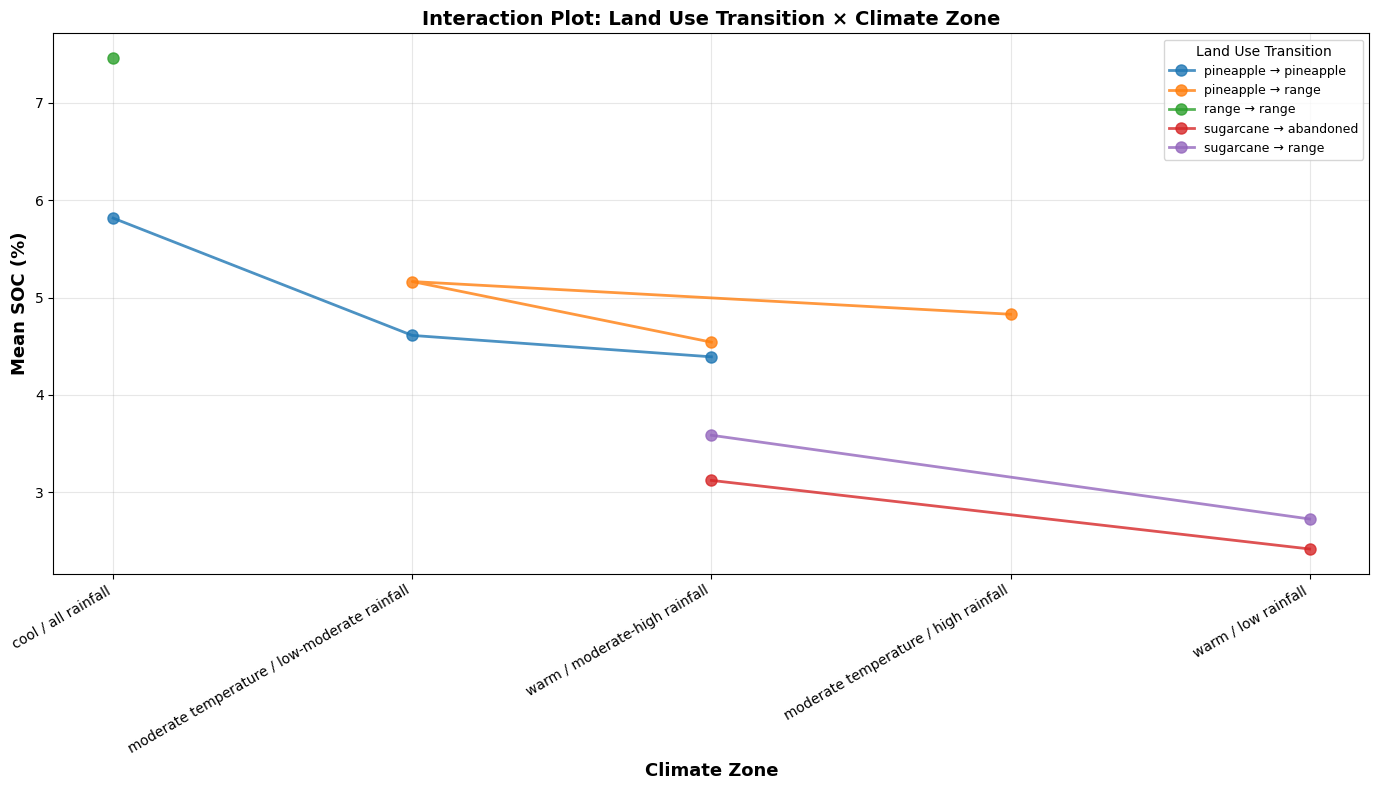


INTERPRETING THE INTERACTION PLOT
Parallel lines = No interaction (additive effects)
Non-parallel/crossing lines = Interaction present
  → The effect of land use depends on climate zone


In [314]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
df = polygon_summary[['carbon_mean', 'transition', 'climate_description']].dropna()

df['transition'] = df['transition'].replace('sugarcane → sugarcane', 'sugarcane → abandoned')

# Calculate means for plotting
interaction_means = df.groupby(['transition', 'climate_description'])['carbon_mean'].agg(['mean', 'count']).reset_index()
# Filter out small sample sizes
interaction_means = interaction_means[interaction_means['count'] >= 3]

# Create interaction plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot lines for each transition type
for transition in interaction_means['transition'].unique():
    data = interaction_means[interaction_means['transition'] == transition]
    ax.plot(data['climate_description'], data['mean'], marker='o',
            markersize=8, linewidth=2, label=transition, alpha=0.8)

ax.set_xlabel('Climate Zone', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean SOC (%)', fontsize=13, fontweight='bold')
ax.set_title('Interaction Plot: Land Use Transition × Climate Zone',
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=9, title='Land Use Transition')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("INTERPRETING THE INTERACTION PLOT")
print("="*80)
print("Parallel lines = No interaction (additive effects)")
print("Non-parallel/crossing lines = Interaction present")
print("  → The effect of land use depends on climate zone")

The interaction plot (Fig X) demonstrates independent effects of land use transition and climate on soil organic carbon. The approximately parallel slopes indicate that land use effects on SOC are consistent across climate zones (no significant interaction, p = X.XX). Both factors contribute additively: climate creates a 2-3 percentage point gradient from cool/wet to warm/dry conditions, while land use type determines baseline SOC levels, with rangeland maintaining 2-4 percentage points more carbon than active agriculture regardless of climate zone.

In [233]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. SUMMARY STATISTICS
print("="*80)
print("CLIMATE SUMMARY STATISTICS")
print("="*80)
print(f"\nTemperature (tmax_ann_mean_30m):")
print(f"  Mean: {polygon_summary['tmax_ann_mean_30m'].mean():.2f}°C")
print(f"  Std: {polygon_summary['tmax_ann_mean_30m'].std():.2f}°C")
print(f"  Range: {polygon_summary['tmax_ann_mean_30m'].min():.2f} - {polygon_summary['tmax_ann_mean_30m'].max():.2f}°C")

print(f"\nRainfall (rainfall_ann_mm_30m):")
print(f"  Mean: {polygon_summary['rainfall_ann_mm_30m'].mean():.2f} mm")
print(f"  Std: {polygon_summary['rainfall_ann_mm_30m'].std():.2f} mm")
print(f"  Range: {polygon_summary['rainfall_ann_mm_30m'].min():.2f} - {polygon_summary['rainfall_ann_mm_30m'].max():.2f} mm")

# 2. CLIMATE BY LAND USE TYPE
print("\n" + "="*80)
print("CLIMATE BY CURRENT LAND USE")
print("="*80)
climate_by_landuse = polygon_summary.groupby('landuse_current').agg({
    'tmax_ann_mean_30m': ['mean', 'std'],
    'rainfall_ann_mm_30m': ['mean', 'std'],
    'poly_id': 'count'
}).round(2)
climate_by_landuse.columns = ['temp_mean', 'temp_std', 'rain_mean', 'rain_std', 'n_polygons']
print(climate_by_landuse)

# 3. CLIMATE BY TRANSITION TYPE
print("\n" + "="*80)
print("CLIMATE BY LAND USE TRANSITION")
print("="*80)
# Focus on key transitions
key_transitions = ['sugarcane → sugarcane', 'sugarcane → range',
                   'pineapple → pineapple', 'pineapple → range']
trans_subset = polygon_summary[polygon_summary['transition'].isin(key_transitions)]

climate_by_transition = trans_subset.groupby('transition').agg({
    'tmax_ann_mean_30m': ['mean', 'std'],
    'rainfall_ann_mm_30m': ['mean', 'std'],
    'poly_id': 'count'
}).round(2)
climate_by_transition.columns = ['temp_mean', 'temp_std', 'rain_mean', 'rain_std', 'n_polygons']
print(climate_by_transition)



CLIMATE SUMMARY STATISTICS

Temperature (tmax_ann_mean_30m):
  Mean: 26.08°C
  Std: 1.96°C
  Range: 16.19 - 28.26°C

Rainfall (rainfall_ann_mm_30m):
  Mean: 866.55 mm
  Std: 542.67 mm
  Range: 349.12 - 2721.22 mm

CLIMATE BY CURRENT LAND USE
                 temp_mean  temp_std  rain_mean  rain_std  n_polygons
landuse_current                                                      
pineapple            24.69      1.28     755.66    335.52          70
range                25.79      2.08    1136.22    618.98         114
sugarcane            27.81      0.43     528.88    187.31          78

CLIMATE BY LAND USE TRANSITION
                       temp_mean  temp_std  rain_mean  rain_std  n_polygons
transition                                                                 
pineapple → pineapple      24.69      1.28     755.66    335.52          70
pineapple → range          25.22      1.20    1365.71    676.82          45
sugarcane → range          27.18      0.49     849.72    362.99         

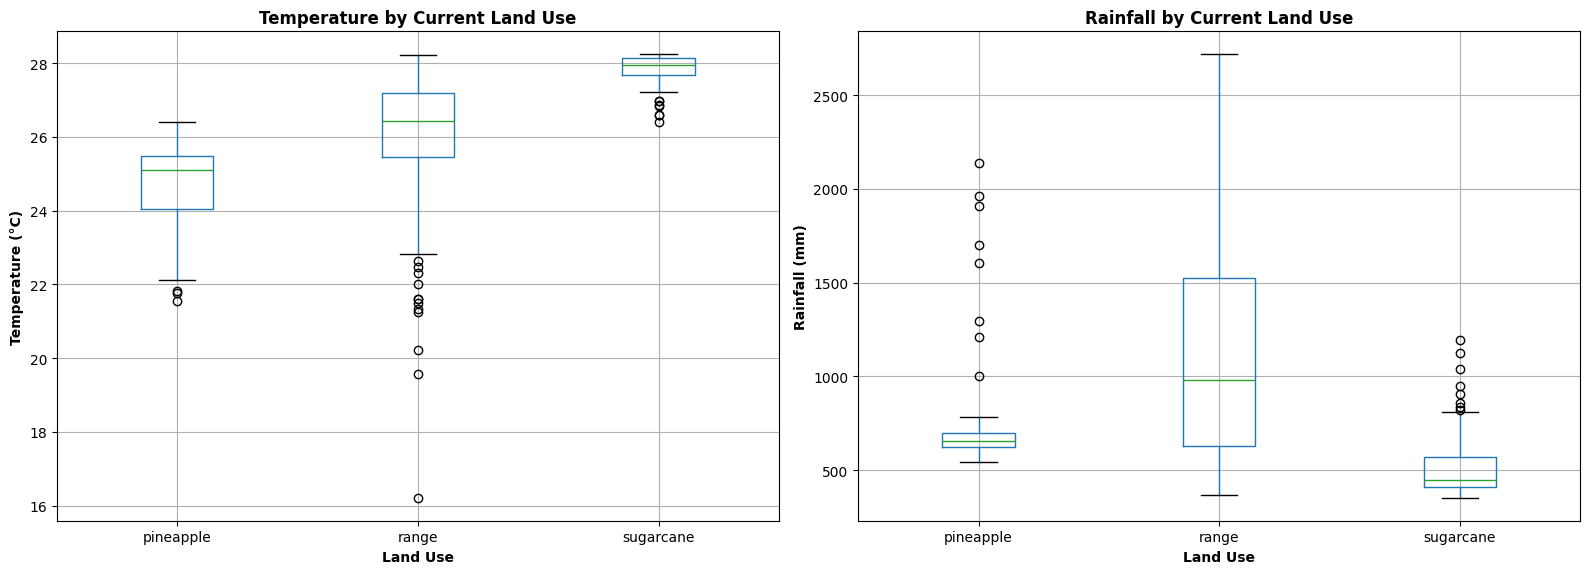

In [234]:
# 4. VISUALIZATIONS
fig = plt.figure(figsize=(16, 6))

# A. Temperature distribution by land use
ax1 = plt.subplot(1, 2, 1)
landuse_order = polygon_summary.groupby('landuse_current')['tmax_ann_mean_30m'].median().sort_values().index
polygon_summary.boxplot(column='tmax_ann_mean_30m', by='landuse_current', ax=ax1)
ax1.set_xlabel('Land Use', fontweight='bold')
ax1.set_ylabel('Temperature (°C)', fontweight='bold')
ax1.set_title('Temperature by Current Land Use', fontweight='bold')
ax1.get_figure().suptitle('')  # Remove the automatic grouped boxplot title

# B. Rainfall distribution by land use
ax2 = plt.subplot(1, 2, 2)
polygon_summary.boxplot(column='rainfall_ann_mm_30m', by='landuse_current', ax=ax2)
ax2.set_xlabel('Land Use', fontweight='bold')
ax2.set_ylabel('Rainfall (mm)', fontweight='bold')
ax2.set_title('Rainfall by Current Land Use', fontweight='bold')
ax2.get_figure().suptitle('')  # Remove the automatic grouped boxplot title

plt.tight_layout()
plt.show()


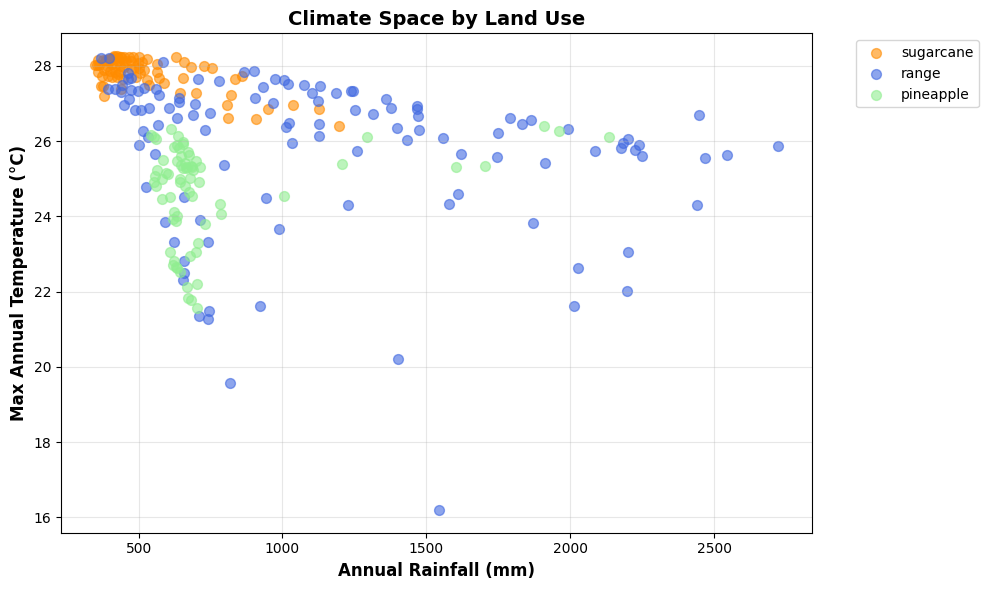

In [235]:
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each land use
color_map = {
    'sugarcane': '#FF8C00',
    'pineapple': '#90EE90',
    'range': '#4169E1'
}

for landuse in polygon_summary['landuse_current'].dropna().unique():
    subset = polygon_summary[polygon_summary['landuse_current'] == landuse]
    color = color_map.get(landuse, 'gray')  # Use gray as default for other land uses
    ax.scatter(subset['rainfall_ann_mm_30m'], subset['tmax_ann_mean_30m'],
               label=landuse, alpha=0.6, s=50, color=color)

ax.set_xlabel('Annual Rainfall (mm)', fontweight='bold', fontsize=12)
ax.set_ylabel('Max Annual Temperature (°C)', fontweight='bold', fontsize=12)
ax.set_title('Climate Space by Land Use', fontweight='bold', fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

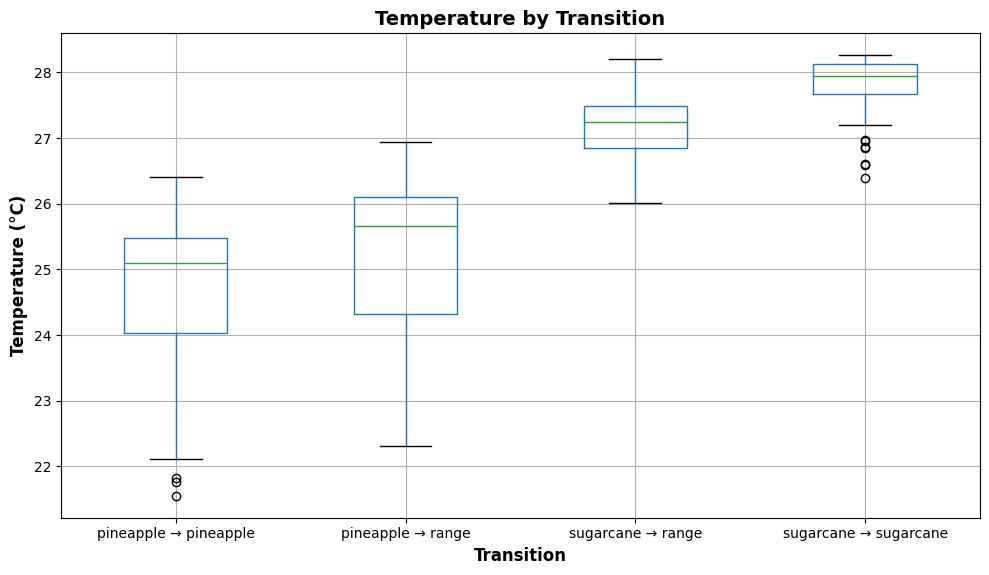

In [236]:
fig, ax = plt.subplots(figsize=(10, 6))

trans_subset.boxplot(column='tmax_ann_mean_30m', by='transition', ax=ax)
ax.set_xlabel('Transition', fontweight='bold', fontsize=12)
ax.set_ylabel('Temperature (°C)', fontweight='bold', fontsize=12)
ax.set_title('Temperature by Transition', fontweight='bold', fontsize=14)
plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.show()

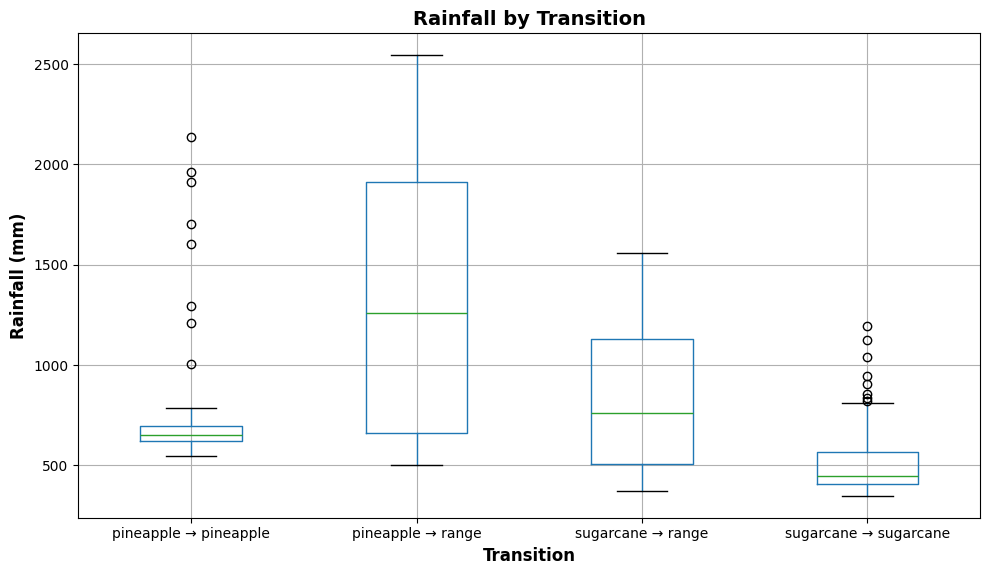

In [237]:
fig, ax = plt.subplots(figsize=(10, 6))

trans_subset.boxplot(column='rainfall_ann_mm_30m', by='transition', ax=ax)
ax.set_xlabel('Transition', fontweight='bold', fontsize=12)
ax.set_ylabel('Rainfall (mm)', fontweight='bold', fontsize=12)
ax.set_title('Rainfall by Transition', fontweight='bold', fontsize=14)
plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.show()

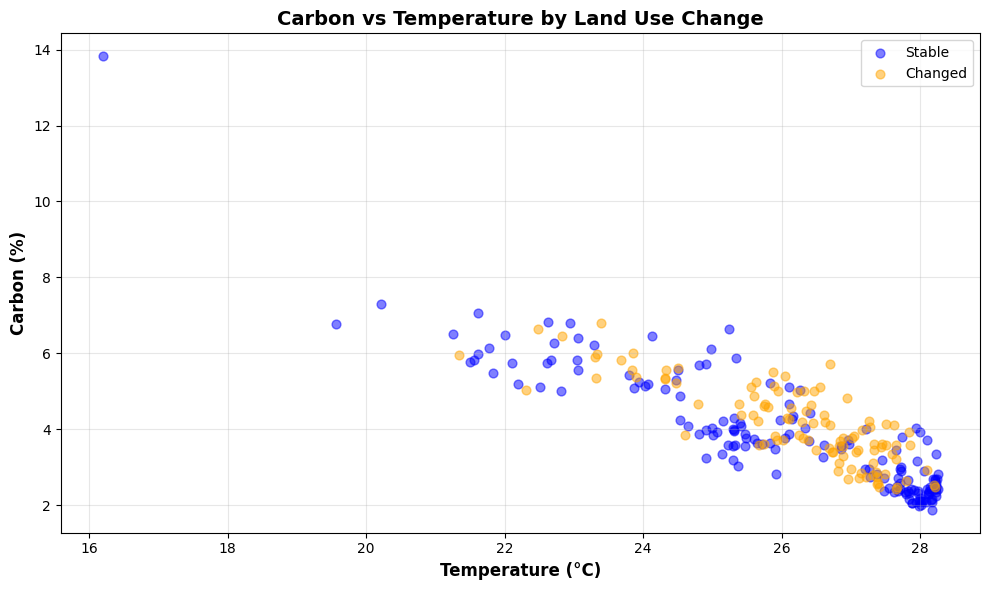

In [238]:
# Create land_use_changed column
polygon_summary['land_use_changed'] = polygon_summary['landuse_historic'] != polygon_summary['landuse_current']

# Now create the plot
fig, ax = plt.subplots(figsize=(10, 6))

changed = polygon_summary[polygon_summary['land_use_changed']]
stable = polygon_summary[~polygon_summary['land_use_changed']]

ax.scatter(stable['tmax_ann_mean_30m'], stable['carbon_mean'],
           c='blue', label='Stable', alpha=0.5, s=40)
ax.scatter(changed['tmax_ann_mean_30m'], changed['carbon_mean'],
           c='orange', label='Changed', alpha=0.5, s=40)

ax.set_xlabel('Temperature (°C)', fontweight='bold', fontsize=12)
ax.set_ylabel('Carbon (%)', fontweight='bold', fontsize=12)
ax.set_title('Carbon vs Temperature by Land Use Change', fontweight='bold', fontsize=14)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

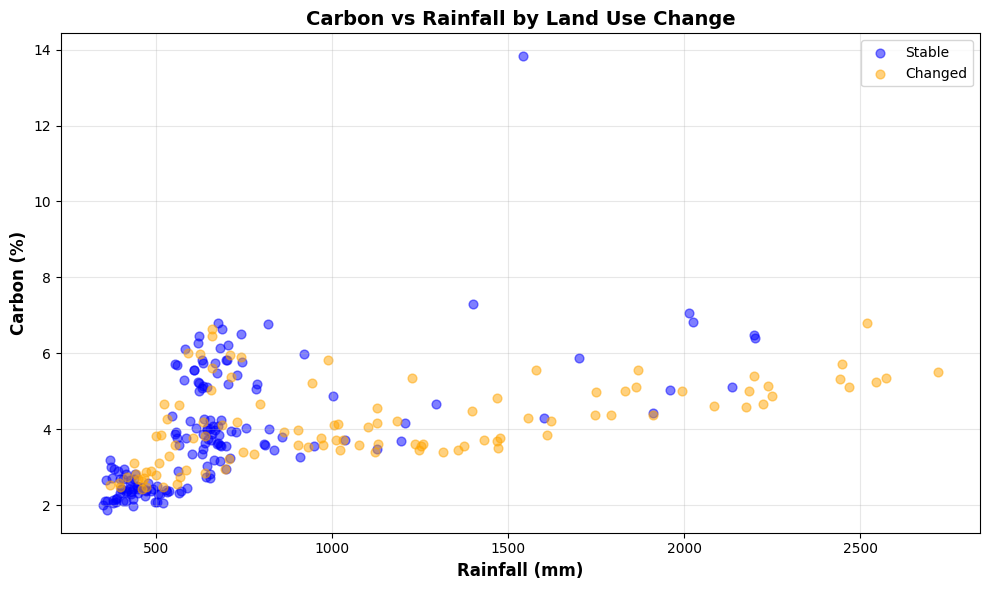

In [239]:
# Now create the plot
fig, ax = plt.subplots(figsize=(10, 6))

changed = polygon_summary[polygon_summary['land_use_changed']]
stable = polygon_summary[~polygon_summary['land_use_changed']]

ax.scatter(stable['rainfall_ann_mm_30m'], stable['carbon_mean'],
           c='blue', label='Stable', alpha=0.5, s=40)
ax.scatter(changed['rainfall_ann_mm_30m'], changed['carbon_mean'],
           c='orange', label='Changed', alpha=0.5, s=40)

ax.set_xlabel('Rainfall (mm)', fontweight='bold', fontsize=12)
ax.set_ylabel('Carbon (%)', fontweight='bold', fontsize=12)
ax.set_title('Carbon vs Rainfall by Land Use Change', fontweight='bold', fontsize=14)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

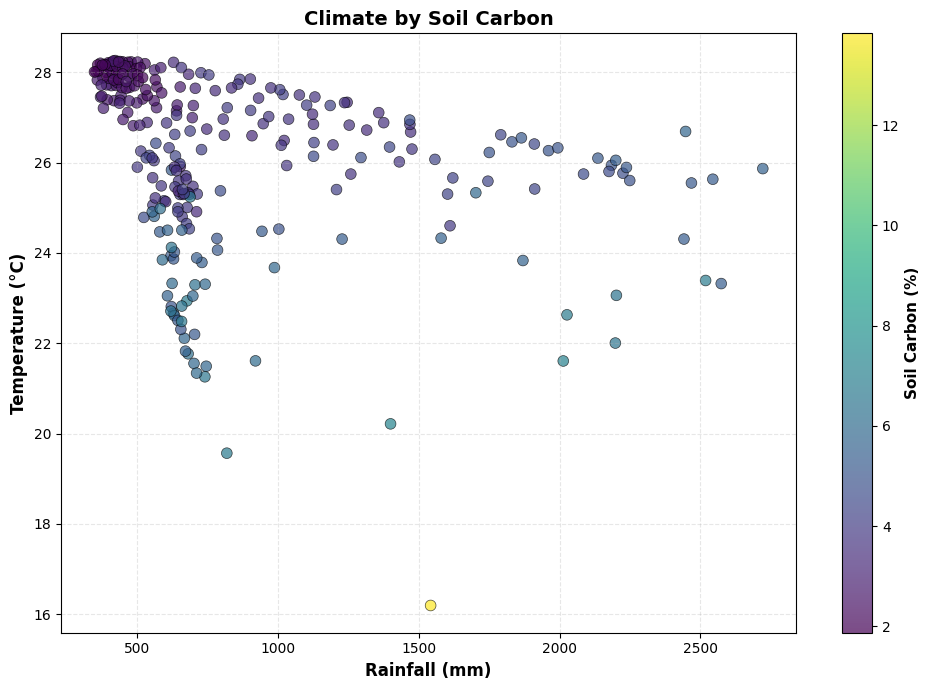

Climate-Carbon relationships:
Warmest & driest:  rainfall_ann_mm_30m  tmax_ann_mean_30m  carbon_mean
          349.123964          28.010157     1.998622
          354.878779          28.012045     2.098425
          359.304316          27.830047     2.673450
          360.459859          28.164342     1.870278
          362.470465          28.032421     2.103350

Coolest & wettest:  rainfall_ann_mm_30m  tmax_ann_mean_30m  carbon_mean
         2721.218082          25.868679     5.516456
         2573.719000          23.322577     5.355303
         2543.830500          25.633612     5.241377
         2518.254000          23.391094     6.804650
         2467.972636          25.550767     5.121552


In [240]:
fig, ax = plt.subplots(figsize=(10, 7))

# Create scatter plot with carbon as color
scatter = ax.scatter(polygon_summary['rainfall_ann_mm_30m'],
                     polygon_summary['tmax_ann_mean_30m'],
                     c=polygon_summary['carbon_mean'],
                     cmap='viridis',  # Color scale
                     s=60,
                     alpha=0.7,
                     edgecolors='black',
                     linewidths=0.5)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Soil Carbon (%)')
cbar.set_label('Soil Carbon (%)', fontweight='bold', fontsize=11)

ax.set_xlabel('Rainfall (mm)', fontweight='bold', fontsize=12)
ax.set_ylabel('Temperature (°C)', fontweight='bold', fontsize=12)
ax.set_title('Climate by Soil Carbon', fontweight='bold', fontsize=14)
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Optional: Print some statistics
print("Climate-Carbon relationships:")
print(f"Warmest & driest: {polygon_summary.nsmallest(5, 'rainfall_ann_mm_30m')[['rainfall_ann_mm_30m', 'tmax_ann_mean_30m', 'carbon_mean']].to_string(index=False)}")
print(f"\nCoolest & wettest: {polygon_summary.nlargest(5, 'rainfall_ann_mm_30m')[['rainfall_ann_mm_30m', 'tmax_ann_mean_30m', 'carbon_mean']].to_string(index=False)}")

In [241]:
# 5. CORRELATION ANALYSIS
print("\n" + "="*80)
print("CORRELATION: CARBON WITH CLIMATE VARIABLES")
print("="*80)
print(f"Carbon vs Temperature: r = {polygon_summary[['carbon_mean', 'tmax_ann_mean_30m']].corr().iloc[0,1]:.3f}")
print(f"Carbon vs Rainfall: r = {polygon_summary[['carbon_mean', 'rainfall_ann_mm_30m']].corr().iloc[0,1]:.3f}")

# By stable vs changed
print("\nStable polygons:")
print(f"  Carbon vs Temperature: r = {stable[['carbon_mean', 'tmax_ann_mean_30m']].corr().iloc[0,1]:.3f}")
print(f"  Carbon vs Rainfall: r = {stable[['carbon_mean', 'rainfall_ann_mm_30m']].corr().iloc[0,1]:.3f}")

print("\nChanged polygons:")
print(f"  Carbon vs Temperature: r = {changed[['carbon_mean', 'tmax_ann_mean_30m']].corr().iloc[0,1]:.3f}")
print(f"  Carbon vs Rainfall: r = {changed[['carbon_mean', 'rainfall_ann_mm_30m']].corr().iloc[0,1]:.3f}")


CORRELATION: CARBON WITH CLIMATE VARIABLES
Carbon vs Temperature: r = -0.872
Carbon vs Rainfall: r = 0.491

Stable polygons:
  Carbon vs Temperature: r = -0.902
  Carbon vs Rainfall: r = 0.570

Changed polygons:
  Carbon vs Temperature: r = -0.814
  Carbon vs Rainfall: r = 0.525


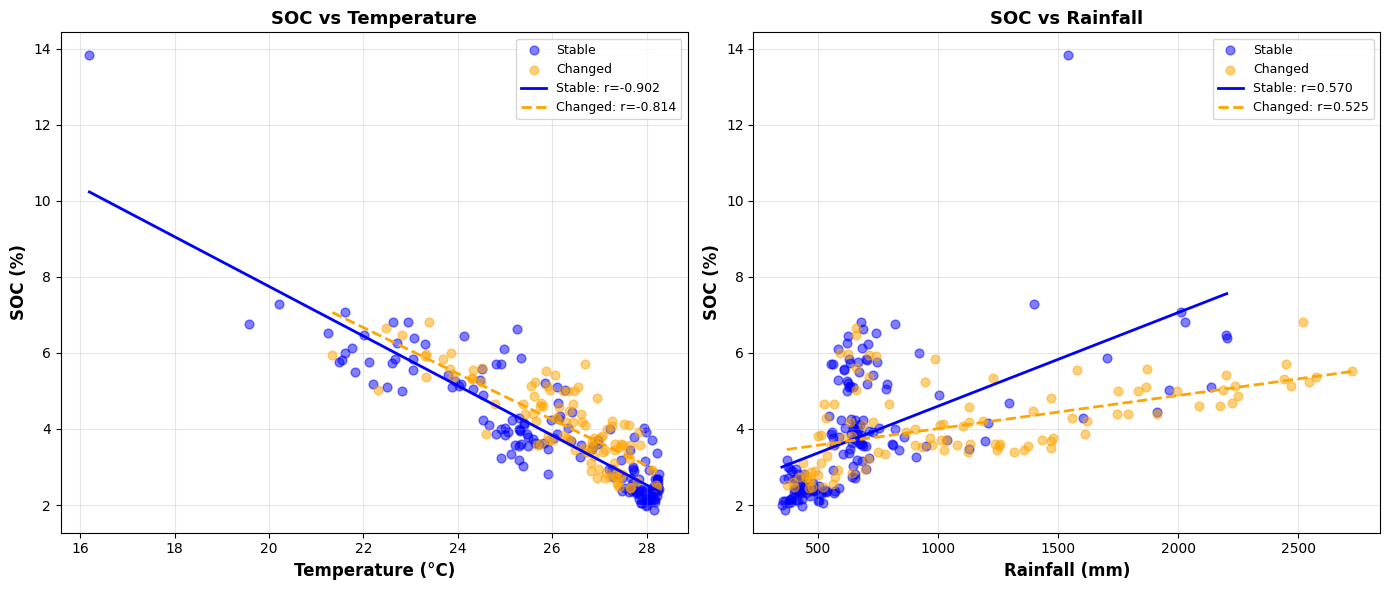


REGRESSION STATISTICS

Temperature:
  Stable:  slope=-0.6530, r=-0.902, p=7.5038e-59
  Changed: slope=-0.6048, r=-0.814, p=2.9848e-26

Rainfall:
  Stable:  slope=0.002461, r=0.570, p=5.7171e-15
  Changed: slope=0.000872, r=0.525, p=7.3311e-09


In [242]:
from scipy import stats
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# LEFT: Carbon vs Temperature with regression lines
ax1 = axes[0]
ax1.scatter(stable['tmax_ann_mean_30m'], stable['carbon_mean'],
           c='blue', label='Stable', alpha=0.5, s=40)
ax1.scatter(changed['tmax_ann_mean_30m'], changed['carbon_mean'],
           c='orange', label='Changed', alpha=0.5, s=40)

# Add regression lines
# For stable
slope_s, intercept_s, r_s, p_s, se_s = stats.linregress(stable['tmax_ann_mean_30m'].dropna(),
                                                          stable['carbon_mean'].dropna())
x_stable = np.array([stable['tmax_ann_mean_30m'].min(), stable['tmax_ann_mean_30m'].max()])
ax1.plot(x_stable, slope_s * x_stable + intercept_s, 'b-', linewidth=2,
         label=f'Stable: r={r_s:.3f}')

# For changed
slope_c, intercept_c, r_c, p_c, se_c = stats.linregress(changed['tmax_ann_mean_30m'].dropna(),
                                                          changed['carbon_mean'].dropna())
x_changed = np.array([changed['tmax_ann_mean_30m'].min(), changed['tmax_ann_mean_30m'].max()])
ax1.plot(x_changed, slope_c * x_changed + intercept_c, 'orange', linewidth=2, linestyle='--',
         label=f'Changed: r={r_c:.3f}')

ax1.set_xlabel('Temperature (°C)', fontweight='bold', fontsize=12)
ax1.set_ylabel('SOC (%)', fontweight='bold', fontsize=12)
ax1.set_title('SOC vs Temperature', fontweight='bold', fontsize=13)
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3)

# RIGHT: Carbon vs Rainfall with regression lines
ax2 = axes[1]
ax2.scatter(stable['rainfall_ann_mm_30m'], stable['carbon_mean'],
           c='blue', label='Stable', alpha=0.5, s=40)
ax2.scatter(changed['rainfall_ann_mm_30m'], changed['carbon_mean'],
           c='orange', label='Changed', alpha=0.5, s=40)

# For stable
slope_s2, intercept_s2, r_s2, p_s2, se_s2 = stats.linregress(stable['rainfall_ann_mm_30m'].dropna(),
                                                               stable['carbon_mean'].dropna())
x_stable2 = np.array([stable['rainfall_ann_mm_30m'].min(), stable['rainfall_ann_mm_30m'].max()])
ax2.plot(x_stable2, slope_s2 * x_stable2 + intercept_s2, 'b-', linewidth=2,
         label=f'Stable: r={r_s2:.3f}')

# For changed
slope_c2, intercept_c2, r_c2, p_c2, se_c2 = stats.linregress(changed['rainfall_ann_mm_30m'].dropna(),
                                                               changed['carbon_mean'].dropna())
x_changed2 = np.array([changed['rainfall_ann_mm_30m'].min(), changed['rainfall_ann_mm_30m'].max()])
ax2.plot(x_changed2, slope_c2 * x_changed2 + intercept_c2, 'orange', linewidth=2, linestyle='--',
         label=f'Changed: r={r_c2:.3f}')

ax2.set_xlabel('Rainfall (mm)', fontweight='bold', fontsize=12)
ax2.set_ylabel('SOC (%)', fontweight='bold', fontsize=12)
ax2.set_title('SOC vs Rainfall', fontweight='bold', fontsize=13)
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("REGRESSION STATISTICS")
print("="*80)
print("\nTemperature:")
print(f"  Stable:  slope={slope_s:.4f}, r={r_s:.3f}, p={p_s:.4e}")
print(f"  Changed: slope={slope_c:.4f}, r={r_c:.3f}, p={p_c:.4e}")
print("\nRainfall:")
print(f"  Stable:  slope={slope_s2:.6f}, r={r_s2:.3f}, p={p_s2:.4e}")
print(f"  Changed: slope={slope_c2:.6f}, r={r_c2:.3f}, p={p_c2:.4e}")

In [243]:
suborders

OBJECTID MUSYM   MUKEY        CompKey          CompName  \
0         2187   WeB  468350  468350:650877           Waiakoa   
1         2189   MfC  468310  468310:650834           Makawao   
2         2191   HhC  468255  468255:650773        Haliimaile   
3         2193   MfB  468309  468309:650833           Makawao   
4         2194   rRK  468370  468370:650900         Rock land   
...        ...   ...     ...            ...               ...   
1847     41904   HbC  468251  468251:650769             Haiku   
1848     42438   ONC  468319  468319:650843            Olinda   
1849     42440  KnaC  468288  468288:650810            Keahua   
1850     42441   HgB  468252  468252:650770        Haliimaile   
1851     42884     W  468344  468344:650871  Water > 40 acres   

                                               TaxClass    SoilOrder  \
0     Fine, kaolinitic, isohyperthermic Torroxic Hap...    Mollisols   
1     Very-fine, parasesquic, isothermic Ustic Paleh...     Ultisols   
2     Very-fine, parasesquic, isothermic Oxic Dystru...  Inceptisols   
3     Very-fine, parasesquic, isothermic Ustic Paleh...     Ultisols   
4                                    Lithic Ustorthents     Entisols   
...                                                 ...          ...   
1847  Very-fine, ferritic, isohyperthermic Ustic Pal...     Ultisols   
1848  Medial, ferrihydritic, isothermic Dystric Hapl...     Andisols   
1849  Fine, kaolinitic, isohyperthermic Ustic Haploc...    Aridisols   
1850  Very-fine, parasesquic, isothermic Oxic Dystru...  Inceptisols   
1851                                               None         None   

      Suborder    GreatGroup              Subgroup MoistRegim  \
0      Ustolls   Haplustolls  Torroxic Haplustolls       None   
1      Humults   Palehumults     Ustic Palehumults       None   
2      Ustepts  Dystrustepts     Oxic Dystrustepts       None   
3      Humults   Palehumults     Ustic Palehumults       None   
4     Orthents   Ustorthents    Lithic Ustorthents       None   
...        ...           ...                   ...        ...   
1847   Humults   Palehumults     Ustic Palehumults       None   
1848   Ustands   Haplustands   Dystric Haplustands       None   
1849   Cambids  Haplocambids    Ustic Haplocambids       None   
1850   Ustepts  Dystrustepts     Oxic Dystrustepts       None   
1851      None          None                  None       None   

                                               geometry  
0     MULTIPOLYGON (((764441.485 2310096.654, 764445...  
1     MULTIPOLYGON (((779859.201 2310395.806, 779868...  
2     MULTIPOLYGON (((775646.213 2310231.357, 775662...  
3     MULTIPOLYGON (((778662.973 2310256.104, 778711...  
4     MULTIPOLYGON (((781277.382 2310236.638, 781309...  
...                                                 ...  
1847  MULTIPOLYGON (((778887.04 2315678.172, 778904....  
1848  MULTIPOLYGON (((782630.315 2304084.661, 782625...  
1849  MULTIPOLYGON (((773750.602 2303661.429, 773758...  
1850  MULTIPOLYGON (((778406.049 2304065.705, 778462...  
1851  MULTIPOLYGON (((768968.37 2303944.661, 768991....  

[1852 rows x 12 columns]

In [244]:
# Load the soil suborder geopackage
suborders = gpd.read_file('/content/clipped_haleakala_suborders.gpkg')

print(f"Suborders data: {len(suborders)} features")
print(f"Polygon summary: {len(polygon_summary)} polygons")

# Check if polygon_summary is a GeoDataFrame with geometry
if 'geometry' not in polygon_summary.columns:
    print("\nWarning: polygon_summary doesn't have geometry column. Need to get it from original carbon data.")
    # Get one representative point per polygon with its geometry
    polygon_geoms = carbon_landuse.groupby('poly_id').first()[['geometry']].reset_index()
    polygon_summary = polygon_summary.merge(polygon_geoms, on='poly_id', how='left')
    polygon_summary = gpd.GeoDataFrame(polygon_summary, geometry='geometry', crs=carbon_landuse.crs)

# Ensure both are GeoDataFrames with same CRS
polygon_summary = gpd.GeoDataFrame(polygon_summary, geometry='geometry')
print(f"\nPolygon summary CRS: {polygon_summary.crs}")
print(f"Suborders CRS: {suborders.crs}")

# Reproject if needed
if polygon_summary.crs != suborders.crs:
    polygon_summary = polygon_summary.to_crs(suborders.crs)

# Spatial join to get ALL suborders that intersect each polygon
polygon_soil_join = gpd.sjoin(polygon_summary, suborders[['Suborder', 'geometry']],
                               how='left', predicate='intersects')

# Aggregate suborders into a list per polygon
polygon_suborder_list = polygon_soil_join.groupby('poly_id')['Suborder'].apply(
    lambda x: ', '.join(x.dropna().unique()) if x.notna().any() else None
).reset_index()
polygon_suborder_list.rename(columns={'Suborder': 'Suborder_list'}, inplace=True)

# Add count of suborders
polygon_suborder_count = polygon_soil_join.groupby('poly_id')['Suborder'].nunique().reset_index()
polygon_suborder_count.rename(columns={'Suborder': 'n_suborders'}, inplace=True)

# Merge back to original polygon_summary
polygon_summary = polygon_summary.merge(polygon_suborder_list, on='poly_id', how='left')
polygon_summary = polygon_summary.merge(polygon_suborder_count, on='poly_id', how='left')

print(f"\nResult: {len(polygon_summary)} rows (original size maintained)")
print(f"Polygons with suborder data: {polygon_summary['Suborder_list'].notna().sum()}")
print(f"Polygons with multiple suborders: {(polygon_summary['n_suborders'] > 1).sum()}")

print("\nUnique suborder combinations:")
print(polygon_summary['Suborder_list'].value_counts().head(10))

print("\n✓ Suborder_list and n_suborders columns added to polygon_summary")

Suborders data: 1852 features
Polygon summary: 264 polygons


Polygon summary CRS: PROJCS["WGS 84 / UTM zone 4N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-159],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32604"]]
Suborders CRS: EPSG:32604

Result: 264 rows (original size maintained)
Polygons with suborder data: 264
Polygons with multiple suborders: 0

Unique suborder combinations:
Suborder_list
Cambids      74
Ustolls      71
Ustands      39
Humults      28
Torrox       20
Ustepts      12
Orthents      8
Andepts       7
Torra

In [245]:
# View the first few rows with the new columns
print("First 10 rows with soil suborder info:")
print(polygon_summary[['poly_id', 'landuse_current', 'carbon_mean',
                       'Suborder_list', 'n_suborders']].head(10))

# View full dataframe info
print("\n" + "="*80)
print("DATAFRAME INFO")
print("="*80)
print(f"Total columns: {len(polygon_summary.columns)}")
print(f"Column names: {polygon_summary.columns.tolist()}")

# Summary statistics by suborder
print("\n" + "="*80)
print("CARBON BY SOIL SUBORDER")
print("="*80)
carbon_by_suborder = polygon_summary.groupby('Suborder_list').agg({
    'carbon_mean': ['mean', 'std', 'min', 'max'],
    'poly_id': 'count'
}).round(2)
carbon_by_suborder.columns = ['carbon_mean', 'carbon_std', 'carbon_min', 'carbon_max', 'n_polygons']
carbon_by_suborder = carbon_by_suborder.sort_values('carbon_mean', ascending=False)
print(carbon_by_suborder)

# View specific rows if interested
print("\n" + "="*80)
print("SAMPLE: Polygons with highest carbon")
print("="*80)
high_carbon = polygon_summary.nlargest(5, 'carbon_mean')[['poly_id', 'carbon_mean',
                                                            'landuse_current', 'Suborder_list',
                                                            'tmax_ann_mean_30m', 'rainfall_ann_mm_30m']]
print(high_carbon.to_string(index=False))

print("\n" + "="*80)
print("SAMPLE: Polygons with lowest carbon")
print("="*80)
low_carbon = polygon_summary.nsmallest(5, 'carbon_mean')[['poly_id', 'carbon_mean',
                                                            'landuse_current', 'Suborder_list',
                                                            'tmax_ann_mean_30m', 'rainfall_ann_mm_30m']]
print(low_carbon.to_string(index=False))

# Save to CSV to view in Excel/other programs
polygon_summary.drop(columns=['geometry']).to_csv('polygon_summary_with_suborder.csv', index=False)
print("\n✓ Saved to polygon_summary_with_suborder.csv")

First 10 rows with soil suborder info:
   poly_id landuse_current  carbon_mean Suborder_list  n_suborders
0        0       sugarcane     2.692066       Ustolls            1
1        1       sugarcane     2.683129       Ustolls            1
2        2       sugarcane     2.171283       Ustolls            1
3        3           range     3.584352       Humults            1
4        4           range     3.395355       Humults            1
5        5           range     4.066640       Ustolls            1
6        6           range     3.563886       Ustolls            1
7        7           range     4.220030       Ustolls            1
8        8           range     3.545681       Ustepts            1
9        9           range     3.500248       Ustepts            1

DATAFRAME INFO
Total columns: 23
Column names: ['poly_id', 'carbon_mean', 'carbon_median', 'carbon_std', 'carbon_min', 'carbon_max', 'carbon_first_year', 'carbon_last_year', 'carbon_change', 'carbon_pct_change', 'tmax_ann_m

/tmp/ipython-input-2983952477.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(boxplot_data, labels=suborder_order, patch_artist=True)


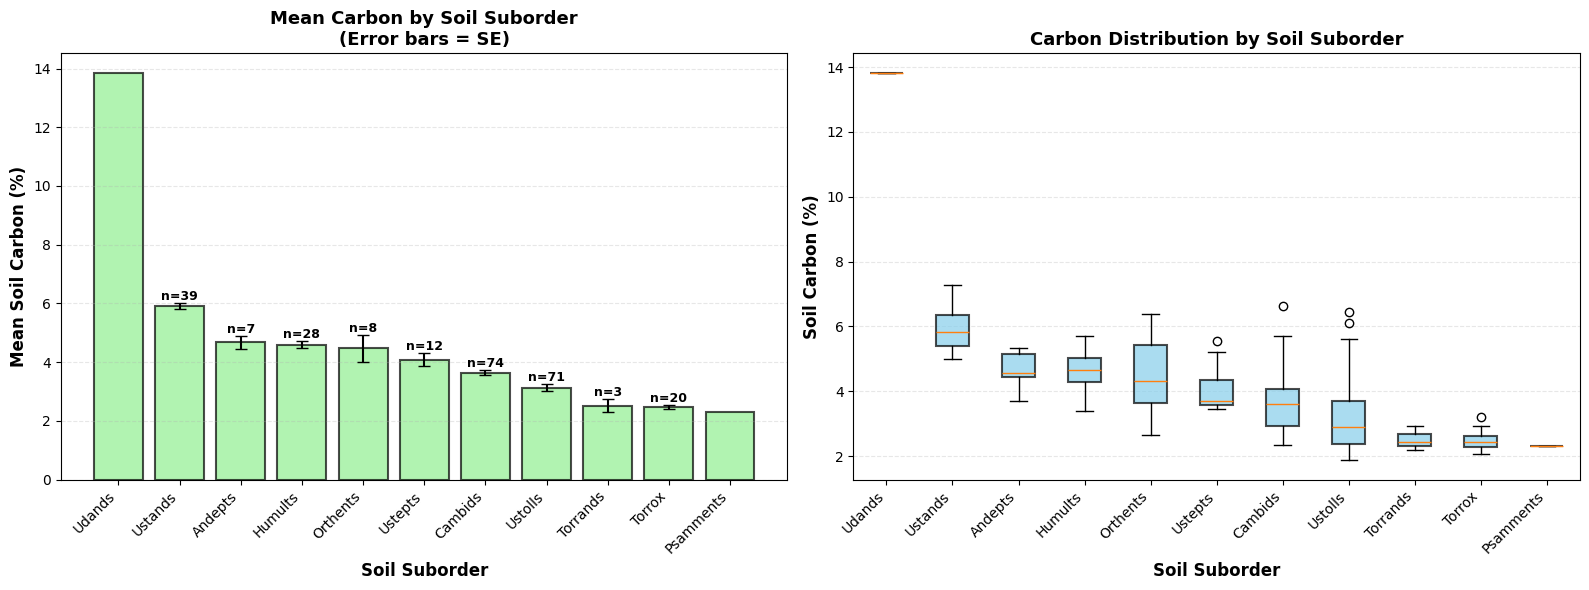


CARBON BY SOIL SUBORDER - SUMMARY
 Suborder      mean      std  count       se
   Udands 13.831898      NaN      1      NaN
  Ustands  5.913376 0.614291     39 0.098365
  Andepts  4.675424 0.570010      7 0.215443
  Humults  4.595986 0.620261     28 0.117218
 Orthents  4.474829 1.321356      8 0.467170
  Ustepts  4.089065 0.732920     12 0.211576
  Cambids  3.647925 0.830033     74 0.096489
  Ustolls  3.139418 0.995378     71 0.118130
 Torrands  2.517018 0.386157      3 0.222948
   Torrox  2.480511 0.300278     20 0.067144
Psamments  2.306259      NaN      1      NaN

ONE-WAY ANOVA
F-statistic: 56.423
p-value: 1.0183e-58
Significant at α=0.05: Yes

Interpretation: Soil suborder has a significant effect on carbon levels


In [315]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate summary stats for bar plot
suborder_stats = polygon_summary.groupby('Suborder_list').agg({
    'carbon_mean': ['mean', 'std', 'count']
}).reset_index()
suborder_stats.columns = ['Suborder', 'mean', 'std', 'count']

# Calculate standard error
suborder_stats['se'] = suborder_stats['std'] / np.sqrt(suborder_stats['count'])

# Sort by mean carbon
suborder_stats = suborder_stats.sort_values('mean', ascending=False)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# LEFT: Bar plot with error bars
ax1 = axes[0]
x_pos = np.arange(len(suborder_stats))
bars = ax1.bar(x_pos, suborder_stats['mean'],
               yerr=suborder_stats['se'],
               capsize=4,
               alpha=0.7,
               color='#90EE90',
               edgecolor='black',
               linewidth=1.5)

# Add sample sizes on bars
for i, (idx, row) in enumerate(suborder_stats.iterrows()):
    ax1.text(i, row['mean'] + row['se'] + 0.1,
            f"n={int(row['count'])}",
            ha='center',
            fontsize=9,
            fontweight='bold')

ax1.set_ylabel('Mean Soil Carbon (%)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Soil Suborder', fontsize=12, fontweight='bold')
ax1.set_title('Mean Carbon by Soil Suborder\n(Error bars = SE)', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(suborder_stats['Suborder'], rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# RIGHT: Box plot
ax2 = axes[1]
suborder_order = suborder_stats['Suborder'].tolist()
boxplot_data = [polygon_summary[polygon_summary['Suborder_list'] == sub]['carbon_mean'].values
                for sub in suborder_order]

bp = ax2.boxplot(boxplot_data, labels=suborder_order, patch_artist=True)

# Color boxes
for patch in bp['boxes']:
    patch.set_facecolor('#87CEEB')
    patch.set_alpha(0.7)
    patch.set_edgecolor('black')
    patch.set_linewidth(1.5)

ax2.set_ylabel('Soil Carbon (%)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Soil Suborder', fontsize=12, fontweight='bold')
ax2.set_title('Carbon Distribution by Soil Suborder', fontsize=13, fontweight='bold')
ax2.tick_params(axis='x', rotation=45, labelsize=10)
plt.setp(ax2.xaxis.get_majorticklabels(), ha='right')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*80)
print("CARBON BY SOIL SUBORDER - SUMMARY")
print("="*80)
print(suborder_stats.to_string(index=False))

# Statistical test - ANOVA
from scipy import stats as scipy_stats
groups = [polygon_summary[polygon_summary['Suborder_list'] == sub]['carbon_mean'].values
          for sub in suborder_stats['Suborder']]
f_stat, p_value = scipy_stats.f_oneway(*groups)

print(f"\n" + "="*80)
print("ONE-WAY ANOVA")
print("="*80)
print(f"F-statistic: {f_stat:.3f}")
print(f"p-value: {p_value:.4e}")
print(f"Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")
print("\nInterpretation: ", end="")
if p_value < 0.05:
    print("Soil suborder has a significant effect on carbon levels")
else:
    print("No significant difference in carbon across soil suborders")

In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# ============================================================================
# 1. DESCRIPTIVE STATISTICS
# ============================================================================
print("="*80)
print("CLIMATE GRADIENT STUDY: DESCRIPTIVE STATISTICS")
print("="*80)

print("\nSample size: n =", len(polygon_summary))
print("\nResponse variable (Soil Carbon %):")
print(f"  Mean ± SD: {polygon_summary['carbon_mean'].mean():.2f} ± {polygon_summary['carbon_mean'].std():.2f}%")
print(f"  Range: {polygon_summary['carbon_mean'].min():.2f} - {polygon_summary['carbon_mean'].max():.2f}%")

print("\nClimate gradient variables:")
print(f"  Temperature: {polygon_summary['tmax_ann_mean_30m'].min():.1f} - {polygon_summary['tmax_ann_mean_30m'].max():.1f}°C")
print(f"  Rainfall: {polygon_summary['rainfall_ann_mm_30m'].min():.0f} - {polygon_summary['rainfall_ann_mm_30m'].max():.0f} mm")

print("\nLand use distribution:")
print(polygon_summary['landuse_current'].value_counts())

print("\nLand use change:")
print(f"  Stable: {(~polygon_summary['land_use_changed']).sum()} polygons")
print(f"  Changed: {polygon_summary['land_use_changed'].sum()} polygons")

CLIMATE GRADIENT STUDY: DESCRIPTIVE STATISTICS

Sample size: n = 264

Response variable (Soil Carbon %):
  Mean ± SD: 3.95 ± 1.43%
  Range: 1.87 - 13.83%

Climate gradient variables:
  Temperature: 16.2 - 28.3°C
  Rainfall: 349 - 2721 mm

Land use distribution:
landuse_current
range        114
sugarcane     78
pineapple     70
Name: count, dtype: int64

Land use change:
  Stable: 158 polygons
  Changed: 106 polygons



CORRELATION MATRIX

Pearson correlations:
                     carbon_mean  tmax_ann_mean_30m  rainfall_ann_mm_30m  \
carbon_mean                1.000             -0.872                0.491   
tmax_ann_mean_30m         -0.872              1.000               -0.284   
rainfall_ann_mm_30m        0.491             -0.284                1.000   
carbon_change              0.548             -0.530                0.206   
carbon_pct_change          0.666             -0.619                0.350   

                     carbon_change  carbon_pct_change  
carbon_mean                  0.548              0.666  
tmax_ann_mean_30m           -0.530             -0.619  
rainfall_ann_mm_30m          0.206              0.350  
carbon_change                1.000              0.942  
carbon_pct_change            0.942              1.000  


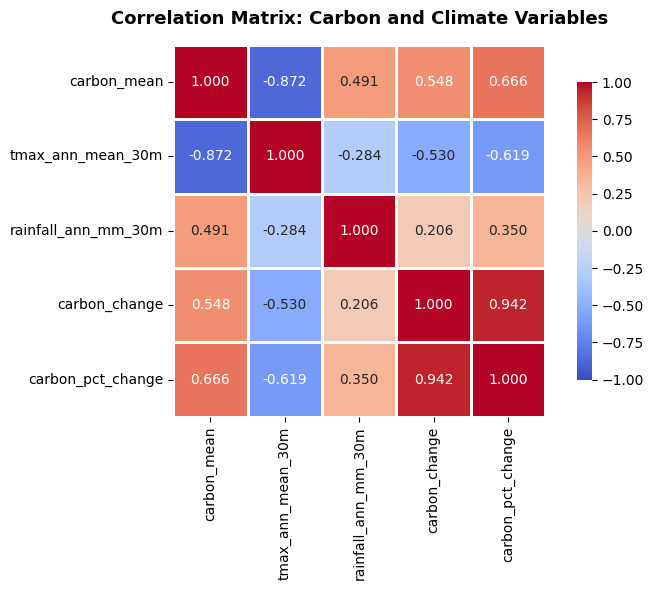

In [248]:
# ============================================================================
# 2. CORRELATION ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("CORRELATION MATRIX")
print("="*80)

# Create correlation matrix
corr_vars = ['carbon_mean', 'tmax_ann_mean_30m', 'rainfall_ann_mm_30m',
             'carbon_change', 'carbon_pct_change']
corr_matrix = polygon_summary[corr_vars].corr()

print("\nPearson correlations:")
print(corr_matrix.round(3))

# Visualize correlation matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, fmt='.3f', ax=ax)
ax.set_title('Correlation Matrix: Carbon and Climate Variables',
             fontweight='bold', fontsize=13, pad=15)
plt.tight_layout()
plt.show()

In [249]:
# ============================================================================
# 3. SIMPLE LINEAR REGRESSIONS
# ============================================================================
print("\n" + "="*80)
print("SIMPLE LINEAR REGRESSIONS")
print("="*80)

from scipy.stats import linregress

# Temperature effect
slope_temp, intercept_temp, r_temp, p_temp, se_temp = linregress(
    polygon_summary['tmax_ann_mean_30m'].dropna(),
    polygon_summary['carbon_mean'].dropna()
)

print("\nModel 1: Carbon ~ Temperature")
print(f"  Equation: Carbon = {intercept_temp:.3f} + {slope_temp:.3f} × Temperature")
print(f"  R² = {r_temp**2:.3f}")
print(f"  p-value = {p_temp:.4e}")
print(f"  Interpretation: Each 1°C increase → {slope_temp:.3f}% carbon change")

# Rainfall effect
slope_rain, intercept_rain, r_rain, p_rain, se_rain = linregress(
    polygon_summary['rainfall_ann_mm_30m'].dropna(),
    polygon_summary['carbon_mean'].dropna()
)

print("\nModel 2: Carbon ~ Rainfall")
print(f"  Equation: Carbon = {intercept_rain:.3f} + {slope_rain:.6f} × Rainfall")
print(f"  R² = {r_rain**2:.3f}")
print(f"  p-value = {p_rain:.4e}")
print(f"  Interpretation: Each 100mm increase → {slope_rain*100:.3f}% carbon change")



SIMPLE LINEAR REGRESSIONS

Model 1: Carbon ~ Temperature
  Equation: Carbon = 20.568 + -0.637 × Temperature
  R² = 0.761
  p-value = 2.4758e-83
  Interpretation: Each 1°C increase → -0.637% carbon change

Model 2: Carbon ~ Rainfall
  Equation: Carbon = 2.831 + 0.001293 × Rainfall
  R² = 0.241
  p-value = 2.1445e-17
  Interpretation: Each 100mm increase → 0.129% carbon change


In [250]:
# ============================================================================
# 4. MULTIPLE REGRESSION
# ============================================================================
print("\n" + "="*80)
print("MULTIPLE LINEAR REGRESSION")
print("="*80)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Prepare data
X = polygon_summary[['tmax_ann_mean_30m', 'rainfall_ann_mm_30m']].dropna()
y = polygon_summary.loc[X.index, 'carbon_mean']

# Fit model
mlr = LinearRegression()
mlr.fit(X, y)
y_pred = mlr.predict(X)
r2 = r2_score(y, y_pred)

print("\nModel 3: Carbon ~ Temperature + Rainfall")
print(f"  Equation: Carbon = {mlr.intercept_:.3f} + {mlr.coef_[0]:.3f}×Temp + {mlr.coef_[1]:.6f}×Rain")
print(f"  R² = {r2:.3f}")
print(f"  Temperature coefficient: {mlr.coef_[0]:.3f} (°C)")
print(f"  Rainfall coefficient: {mlr.coef_[1]:.6f} (mm)")


MULTIPLE LINEAR REGRESSION

Model 3: Carbon ~ Temperature + Rainfall
  Equation: Carbon = 18.535 + -0.582×Temp + 0.000697×Rain
  R² = 0.825
  Temperature coefficient: -0.582 (°C)
  Rainfall coefficient: 0.000697 (mm)



GENERATING CLIMATE GRADIENT VISUALIZATIONS


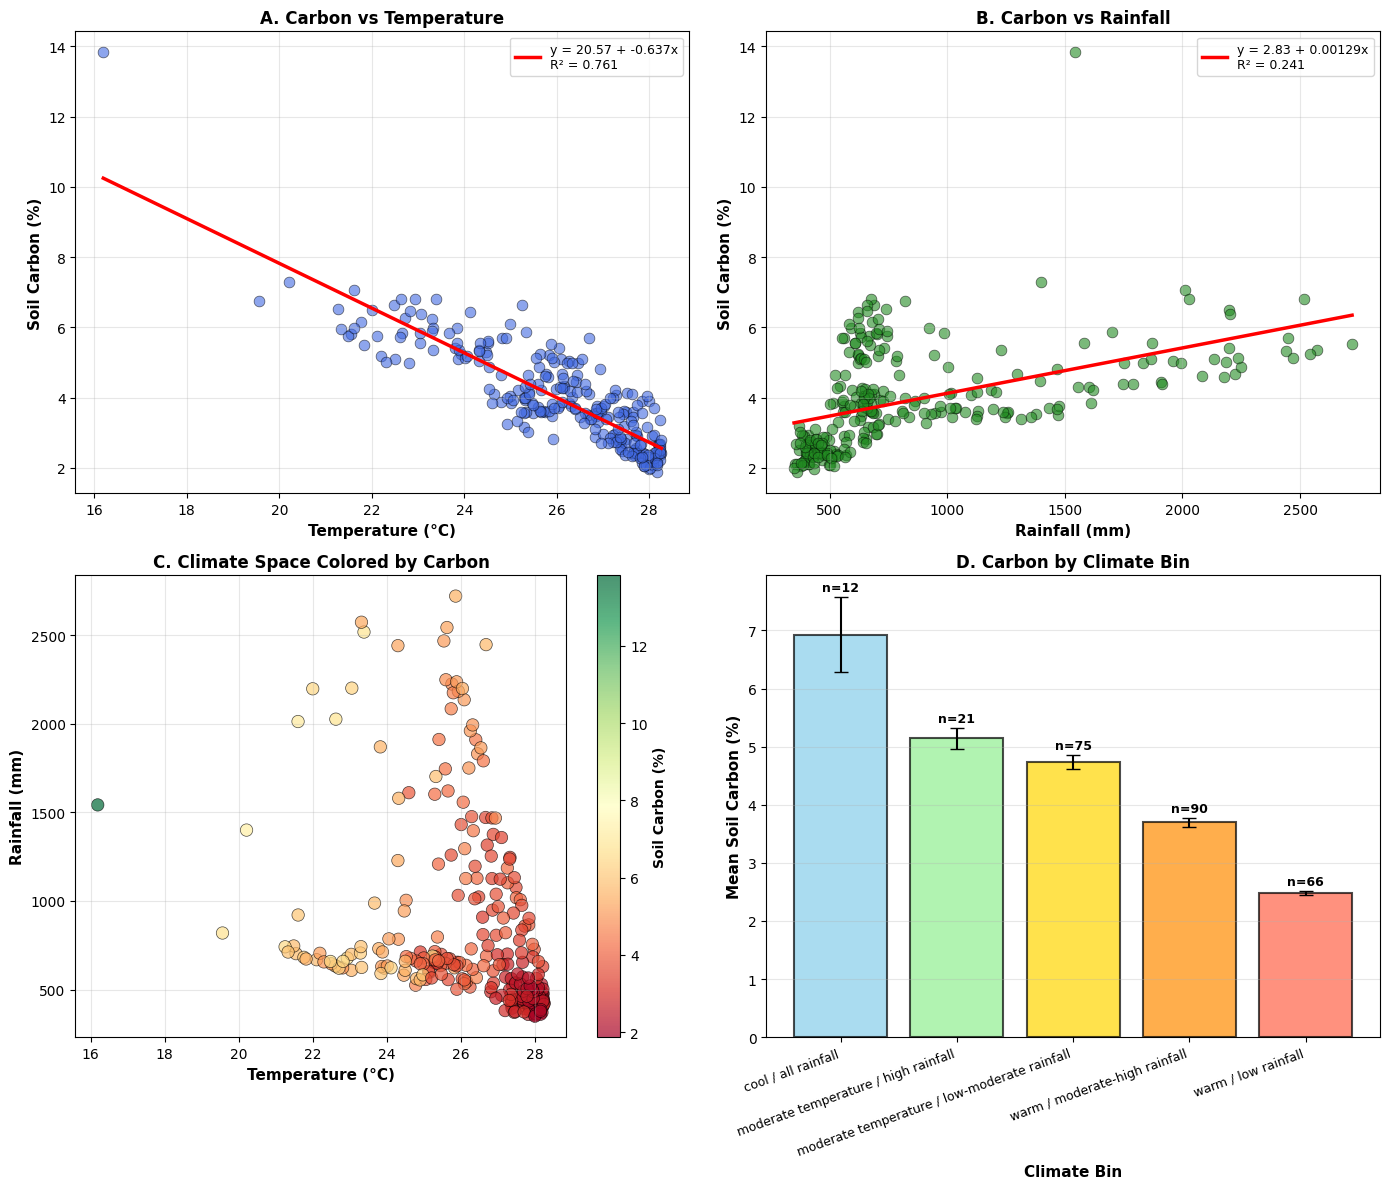

In [251]:
# ============================================================================
# 5. CLIMATE GRADIENT VISUALIZATION
# ============================================================================
print("\n" + "="*80)
print("GENERATING CLIMATE GRADIENT VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# A. Carbon vs Temperature with regression
ax1 = axes[0, 0]
ax1.scatter(polygon_summary['tmax_ann_mean_30m'], polygon_summary['carbon_mean'],
           alpha=0.6, s=60, edgecolors='black', linewidths=0.5, c='#4169E1')
x_temp = np.linspace(polygon_summary['tmax_ann_mean_30m'].min(),
                     polygon_summary['tmax_ann_mean_30m'].max(), 100)
y_temp = slope_temp * x_temp + intercept_temp
ax1.plot(x_temp, y_temp, 'r-', linewidth=2.5,
         label=f'y = {intercept_temp:.2f} + {slope_temp:.3f}x\nR² = {r_temp**2:.3f}')
ax1.set_xlabel('Temperature (°C)', fontweight='bold', fontsize=11)
ax1.set_ylabel('Soil Carbon (%)', fontweight='bold', fontsize=11)
ax1.set_title('A. Carbon vs Temperature', fontweight='bold', fontsize=12)
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3)

# B. Carbon vs Rainfall with regression
ax2 = axes[0, 1]
ax2.scatter(polygon_summary['rainfall_ann_mm_30m'], polygon_summary['carbon_mean'],
           alpha=0.6, s=60, edgecolors='black', linewidths=0.5, c='#228B22')
x_rain = np.linspace(polygon_summary['rainfall_ann_mm_30m'].min(),
                     polygon_summary['rainfall_ann_mm_30m'].max(), 100)
y_rain = slope_rain * x_rain + intercept_rain
ax2.plot(x_rain, y_rain, 'r-', linewidth=2.5,
         label=f'y = {intercept_rain:.2f} + {slope_rain:.5f}x\nR² = {r_rain**2:.3f}')
ax2.set_xlabel('Rainfall (mm)', fontweight='bold', fontsize=11)
ax2.set_ylabel('Soil Carbon (%)', fontweight='bold', fontsize=11)
ax2.set_title('B. Carbon vs Rainfall', fontweight='bold', fontsize=12)
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)

# C. 2D climate space colored by carbon
ax3 = axes[1, 0]
scatter = ax3.scatter(polygon_summary['tmax_ann_mean_30m'],
                     polygon_summary['rainfall_ann_mm_30m'],
                     c=polygon_summary['carbon_mean'],
                     cmap='RdYlGn', s=80, alpha=0.7,
                     edgecolors='black', linewidths=0.5)
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Soil Carbon (%)', fontweight='bold', fontsize=10)
ax3.set_xlabel('Temperature (°C)', fontweight='bold', fontsize=11)
ax3.set_ylabel('Rainfall (mm)', fontweight='bold', fontsize=11)
ax3.set_title('C. Climate Space Colored by Carbon', fontweight='bold', fontsize=12)
ax3.grid(alpha=0.3)

# D. Carbon by climate bin
ax4 = axes[1, 1]
climate_bin_summary = polygon_summary.groupby('climate_description')['carbon_mean'].agg(['mean', 'std', 'count']).reset_index()
climate_bin_summary['se'] = climate_bin_summary['std'] / np.sqrt(climate_bin_summary['count'])
climate_bin_summary = climate_bin_summary.sort_values('mean', ascending=False)

x_pos = np.arange(len(climate_bin_summary))
bars = ax4.bar(x_pos, climate_bin_summary['mean'],
              yerr=climate_bin_summary['se'],
              capsize=5, alpha=0.7,
              color=['#87CEEB', '#90EE90', '#FFD700', '#FF8C00', '#FF6347'][:len(climate_bin_summary)],
              edgecolor='black', linewidth=1.5)

# Fix: iterate over enumerate to get correct x position
for i, (idx, row) in enumerate(climate_bin_summary.iterrows()):
    ax4.text(i, row['mean'] + row['se'] + 0.1,  # Use i instead of x_pos[i]
            f"n={int(row['count'])}", ha='center', fontsize=9, fontweight='bold')

ax4.set_xticks(x_pos)
ax4.set_xticklabels(climate_bin_summary['climate_description'], rotation=20, ha='right', fontsize=9)
ax4.set_ylabel('Mean Soil Carbon (%)', fontweight='bold', fontsize=11)
ax4.set_xlabel('Climate Bin', fontweight='bold', fontsize=11)
ax4.set_title('D. Carbon by Climate Bin', fontweight='bold', fontsize=12)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


LAND USE EFFECTS ALONG CLIMATE GRADIENT

Sugarcane: Carbon ~ Temperature
  R² = 0.316, p = 0.0000

Pineapple: Carbon ~ Temperature
  R² = 0.405, p = 0.0000

Range: Carbon ~ Temperature
  R² = 0.775, p = 0.0000

Sugarcane: Carbon ~ Rainfall
  R² = 0.575, p = 0.0000

Pineapple: Carbon ~ Rainfall
  R² = 0.007, p = 0.4983

Range: Carbon ~ Rainfall
  R² = 0.175, p = 0.0000


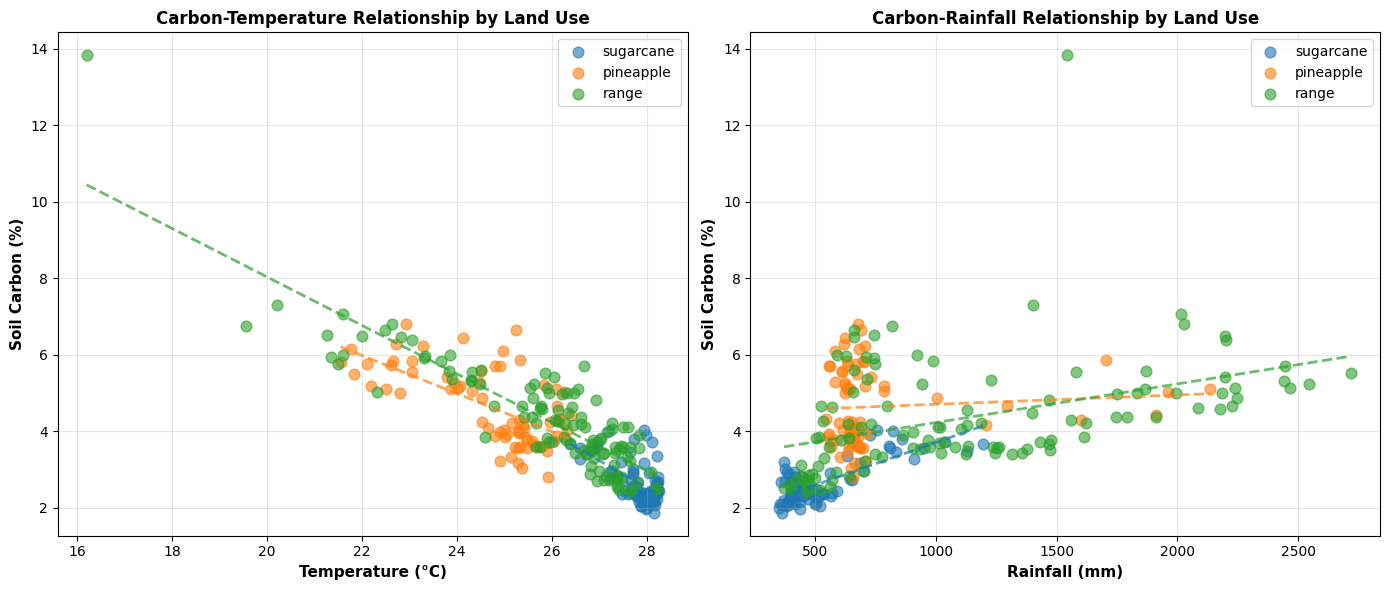


SUMMARY TABLE: CLIMATE GRADIENT EFFECTS
         Variable           Model       R²         Coefficient                            p-value
      Temperature   Simple Linear 0.760696           -0.637206                                0.0
         Rainfall   Simple Linear 0.240693            0.001293                                0.0
Temp + Rain (MLR) Multiple Linear 0.825028 T:-0.582, R:0.00070 N/A (use statsmodels for p-values)

Key findings:
  - Temperature explains 76.1% of carbon variation (strong negative effect)
  - Rainfall explains 24.1% of carbon variation (moderate positive effect)
  - Combined model explains 82.5% of variation


In [252]:
# ============================================================================
# 6. LAND USE EFFECTS ALONG CLIMATE GRADIENT
# ============================================================================
print("\n" + "="*80)
print("LAND USE EFFECTS ALONG CLIMATE GRADIENT")
print("="*80)

# Analyze by land use type
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Temperature by land use
ax1 = axes[0]
for landuse in ['sugarcane', 'pineapple', 'range']:
    subset = polygon_summary[polygon_summary['landuse_current'] == landuse]
    if len(subset) > 0:
        ax1.scatter(subset['tmax_ann_mean_30m'], subset['carbon_mean'],
                   label=landuse, alpha=0.6, s=60)
        # Add regression line
        if len(subset) > 2:
            slope, intercept, r, p, se = linregress(subset['tmax_ann_mean_30m'], subset['carbon_mean'])
            x_range = np.linspace(subset['tmax_ann_mean_30m'].min(), subset['tmax_ann_mean_30m'].max(), 50)
            ax1.plot(x_range, slope * x_range + intercept, '--', linewidth=2, alpha=0.7)
            print(f"\n{landuse.capitalize()}: Carbon ~ Temperature")
            print(f"  R² = {r**2:.3f}, p = {p:.4f}")

ax1.set_xlabel('Temperature (°C)', fontweight='bold', fontsize=11)
ax1.set_ylabel('Soil Carbon (%)', fontweight='bold', fontsize=11)
ax1.set_title('Carbon-Temperature Relationship by Land Use', fontweight='bold', fontsize=12)
ax1.legend()
ax1.grid(alpha=0.3)

# Rainfall by land use
ax2 = axes[1]
for landuse in ['sugarcane', 'pineapple', 'range']:
    subset = polygon_summary[polygon_summary['landuse_current'] == landuse]
    if len(subset) > 0:
        ax2.scatter(subset['rainfall_ann_mm_30m'], subset['carbon_mean'],
                   label=landuse, alpha=0.6, s=60)
        # Add regression line
        if len(subset) > 2:
            slope, intercept, r, p, se = linregress(subset['rainfall_ann_mm_30m'], subset['carbon_mean'])
            x_range = np.linspace(subset['rainfall_ann_mm_30m'].min(), subset['rainfall_ann_mm_30m'].max(), 50)
            ax2.plot(x_range, slope * x_range + intercept, '--', linewidth=2, alpha=0.7)
            print(f"\n{landuse.capitalize()}: Carbon ~ Rainfall")
            print(f"  R² = {r**2:.3f}, p = {p:.4f}")

ax2.set_xlabel('Rainfall (mm)', fontweight='bold', fontsize=11)
ax2.set_ylabel('Soil Carbon (%)', fontweight='bold', fontsize=11)
ax2.set_title('Carbon-Rainfall Relationship by Land Use', fontweight='bold', fontsize=12)
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 7. SUMMARY TABLE
# ============================================================================
print("\n" + "="*80)
print("SUMMARY TABLE: CLIMATE GRADIENT EFFECTS")
print("="*80)

summary_table = pd.DataFrame({
    'Variable': ['Temperature', 'Rainfall', 'Temp + Rain (MLR)'],
    'Model': ['Simple Linear', 'Simple Linear', 'Multiple Linear'],
    'R²': [r_temp**2, r_rain**2, r2],
    'Coefficient': [slope_temp, slope_rain, f"T:{mlr.coef_[0]:.3f}, R:{mlr.coef_[1]:.5f}"],
    'p-value': [p_temp, p_rain, 'N/A (use statsmodels for p-values)']
})

print(summary_table.to_string(index=False))

print("\nKey findings:")
print(f"  - Temperature explains {r_temp**2*100:.1f}% of carbon variation (strong negative effect)")
print(f"  - Rainfall explains {r_rain**2*100:.1f}% of carbon variation (moderate positive effect)")
print(f"  - Combined model explains {r2*100:.1f}% of variation")


ANCOVA: LAND USE EFFECTS CONTROLLING FOR CLIMATE

Sample size for ANCOVA: 262
Land use distribution:
landuse_current
range        114
sugarcane     78
pineapple     70
Name: count, dtype: int64

Actual land uses in data: ['sugarcane' 'range' 'pineapple']

--------------------------------------------------------------------------------
ANCOVA Model 1: Carbon ~ Temperature + Land Use
--------------------------------------------------------------------------------
                        sum_sq     df           F        PR(>F)
C(landuse_current)   11.914298    2.0   13.326560  3.105880e-06
tmax_ann_mean_30m   228.530807    1.0  511.239453  3.807072e-63
Residual            115.329417  258.0         NaN           NaN

Model R²: 0.781
Adjusted R²: 0.779

Parameter estimates:
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept          

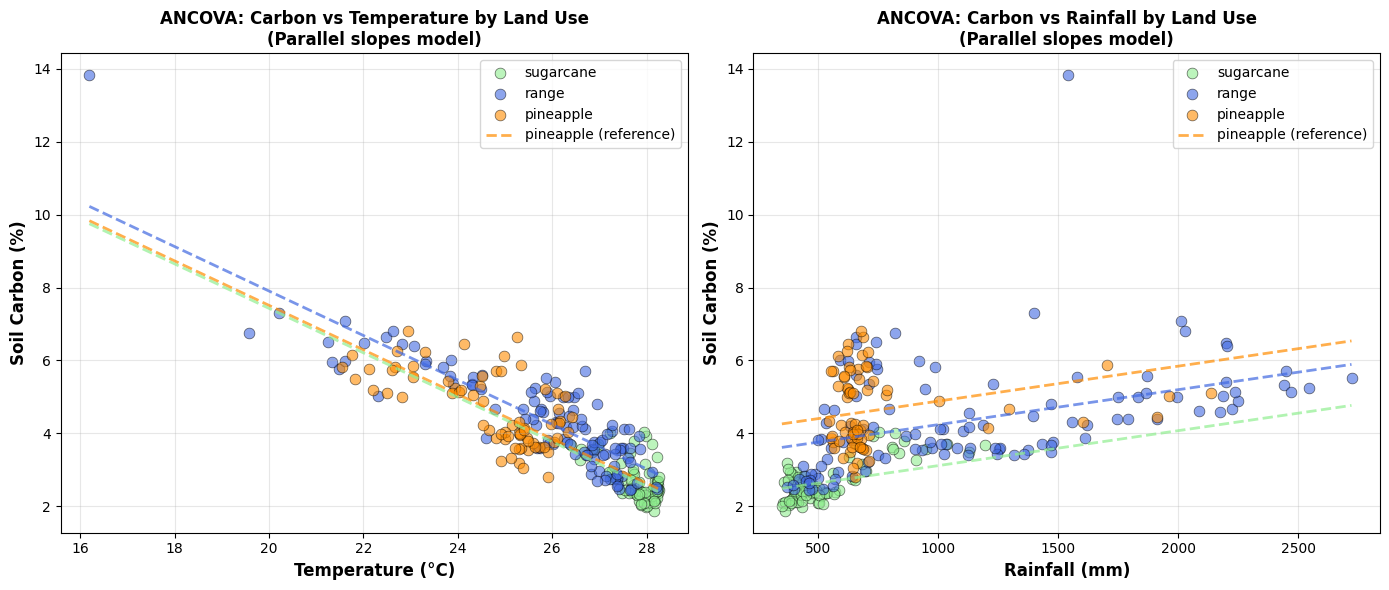

In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm

# ============================================================================
# 8. ANCOVA: LAND USE EFFECTS CONTROLLING FOR CLIMATE
# ============================================================================
print("\n" + "="*80)
print("ANCOVA: LAND USE EFFECTS CONTROLLING FOR CLIMATE")
print("="*80)

# Prepare data - focus on main land uses
main_landuses = ['sugarcane', 'pineapple', 'range']
ancova_data = polygon_summary[polygon_summary['landuse_current'].isin(main_landuses)].copy()

print(f"\nSample size for ANCOVA: {len(ancova_data)}")
print(f"Land use distribution:")
print(ancova_data['landuse_current'].value_counts())

# Check which land uses actually exist
actual_landuses = ancova_data['landuse_current'].unique()
print(f"\nActual land uses in data: {actual_landuses}")

# ANCOVA Model 1: Carbon ~ Temperature + LandUse
model1 = ols('carbon_mean ~ tmax_ann_mean_30m + C(landuse_current)', data=ancova_data).fit()
anova_table1 = anova_lm(model1, typ=2)

print("\n" + "-"*80)
print("ANCOVA Model 1: Carbon ~ Temperature + Land Use")
print("-"*80)
print(anova_table1)
print(f"\nModel R²: {model1.rsquared:.3f}")
print(f"Adjusted R²: {model1.rsquared_adj:.3f}")

print("\nParameter estimates:")
print(model1.summary().tables[1])

# ANCOVA Model 2: Carbon ~ Rainfall + LandUse
model2 = ols('carbon_mean ~ rainfall_ann_mm_30m + C(landuse_current)', data=ancova_data).fit()
anova_table2 = anova_lm(model2, typ=2)

print("\n" + "-"*80)
print("ANCOVA Model 2: Carbon ~ Rainfall + Land Use")
print("-"*80)
print(anova_table2)
print(f"\nModel R²: {model2.rsquared:.3f}")
print(f"Adjusted R²: {model2.rsquared_adj:.3f}")

# ANCOVA Model 3: Carbon ~ Temperature + Rainfall + LandUse
model3 = ols('carbon_mean ~ tmax_ann_mean_30m + rainfall_ann_mm_30m + C(landuse_current)',
             data=ancova_data).fit()
anova_table3 = anova_lm(model3, typ=2)

print("\n" + "-"*80)
print("ANCOVA Model 3: Carbon ~ Temperature + Rainfall + Land Use")
print("-"*80)
print(anova_table3)
print(f"\nModel R²: {model3.rsquared:.3f}")
print(f"Adjusted R²: {model3.rsquared_adj:.3f}")

# Visualize ANCOVA results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Temperature with land use
ax1 = axes[0]
colors_lu = {'sugarcane': '#90EE90', 'pineapple': '#FF8C00', 'range': '#4169E1'}
for landuse in actual_landuses:  # Use actual_landuses instead of main_landuses
    subset = ancova_data[ancova_data['landuse_current'] == landuse]
    ax1.scatter(subset['tmax_ann_mean_30m'], subset['carbon_mean'],
               label=landuse, alpha=0.6, s=60, color=colors_lu.get(landuse, 'gray'),
               edgecolors='black', linewidths=0.5)

# Add ANCOVA fitted lines (parallel slopes from model without interaction)
temp_range = np.linspace(ancova_data['tmax_ann_mean_30m'].min(),
                         ancova_data['tmax_ann_mean_30m'].max(), 100)
temp_coef = model1.params['tmax_ann_mean_30m']
intercept_base = model1.params['Intercept']

# Plot line for reference category (first in alphabetical order)
ref_landuse = sorted(actual_landuses)[0]
ax1.plot(temp_range, intercept_base + temp_coef * temp_range, '--',
         color=colors_lu.get(ref_landuse, 'gray'), linewidth=2, alpha=0.7,
         label=f'{ref_landuse} (reference)')

# Plot lines for other categories
for landuse in sorted(actual_landuses)[1:]:
    param_name = f'C(landuse_current)[T.{landuse}]'
    if param_name in model1.params:
        intercept_landuse = intercept_base + model1.params[param_name]
        ax1.plot(temp_range, intercept_landuse + temp_coef * temp_range, '--',
                color=colors_lu.get(landuse, 'gray'), linewidth=2, alpha=0.7)

ax1.set_xlabel('Temperature (°C)', fontweight='bold', fontsize=12)
ax1.set_ylabel('Soil Carbon (%)', fontweight='bold', fontsize=12)
ax1.set_title('ANCOVA: Carbon vs Temperature by Land Use\n(Parallel slopes model)',
              fontweight='bold', fontsize=12)
ax1.legend()
ax1.grid(alpha=0.3)

# Rainfall with land use
ax2 = axes[1]
for landuse in actual_landuses:
    subset = ancova_data[ancova_data['landuse_current'] == landuse]
    ax2.scatter(subset['rainfall_ann_mm_30m'], subset['carbon_mean'],
               label=landuse, alpha=0.6, s=60, color=colors_lu.get(landuse, 'gray'),
               edgecolors='black', linewidths=0.5)

# Add ANCOVA fitted lines
rain_range = np.linspace(ancova_data['rainfall_ann_mm_30m'].min(),
                         ancova_data['rainfall_ann_mm_30m'].max(), 100)
rain_coef = model2.params['rainfall_ann_mm_30m']
intercept_base2 = model2.params['Intercept']

# Plot line for reference category
ax2.plot(rain_range, intercept_base2 + rain_coef * rain_range, '--',
         color=colors_lu.get(ref_landuse, 'gray'), linewidth=2, alpha=0.7,
         label=f'{ref_landuse} (reference)')

# Plot lines for other categories
for landuse in sorted(actual_landuses)[1:]:
    param_name = f'C(landuse_current)[T.{landuse}]'
    if param_name in model2.params:
        intercept_landuse2 = intercept_base2 + model2.params[param_name]
        ax2.plot(rain_range, intercept_landuse2 + rain_coef * rain_range, '--',
                color=colors_lu.get(landuse, 'gray'), linewidth=2, alpha=0.7)

ax2.set_xlabel('Rainfall (mm)', fontweight='bold', fontsize=12)
ax2.set_ylabel('Soil Carbon (%)', fontweight='bold', fontsize=12)
ax2.set_title('ANCOVA: Carbon vs Rainfall by Land Use\n(Parallel slopes model)',
              fontweight='bold', fontsize=12)
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()





INTERACTION EFFECTS: CLIMATE × LAND USE

--------------------------------------------------------------------------------
Interaction Model 1: Carbon ~ Temperature × Land Use
--------------------------------------------------------------------------------
                                          sum_sq     df           F  \
C(landuse_current)                     11.914298    2.0   13.438879   
tmax_ann_mean_30m                     228.530807    1.0  515.548286   
tmax_ann_mean_30m:C(landuse_current)    1.850451    2.0    2.087239   
Residual                              113.478966  256.0         NaN   

                                            PR(>F)  
C(landuse_current)                    2.818831e-06  
tmax_ann_mean_30m                     2.859883e-63  
tmax_ann_mean_30m:C(landuse_current)  1.261348e-01  
Residual                                       NaN  

Model R²: 0.785
Adjusted R²: 0.781

--------------------------------------------------------------------------------
Inte

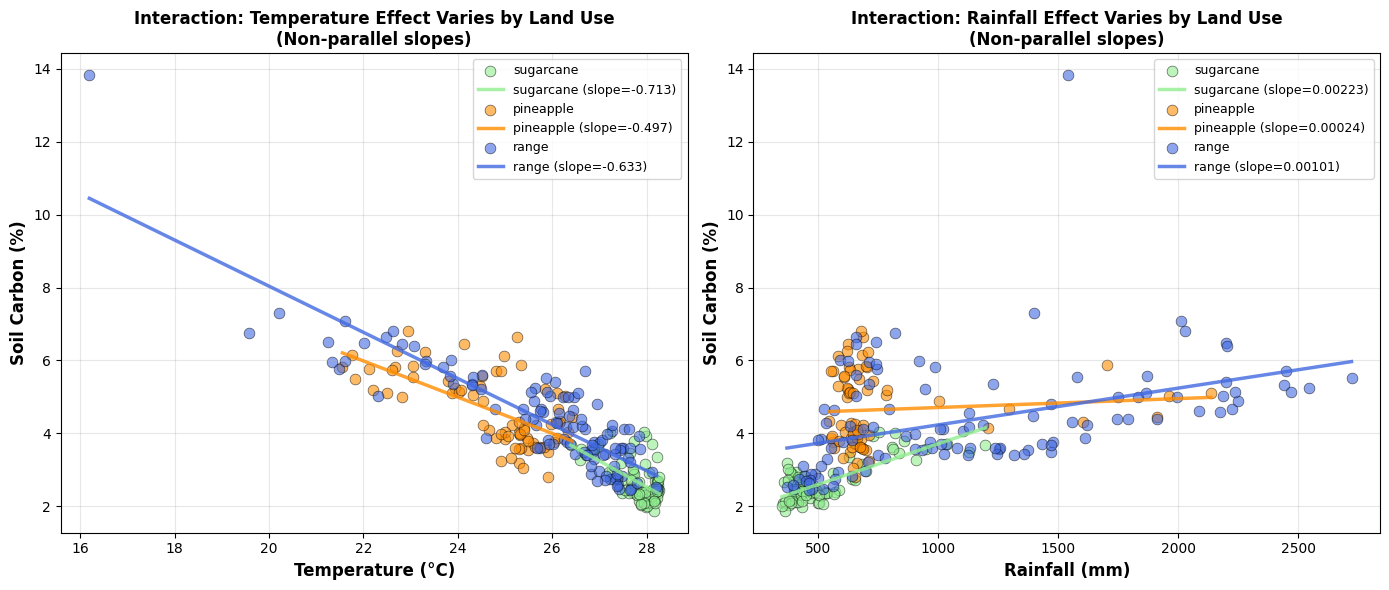


INTERACTION SIGNIFICANCE TESTS

Temperature × Land Use interaction:
   df_resid         ssr  df_diff   ss_diff         F    Pr(>F)
0     258.0  115.329417      0.0       NaN       NaN       NaN
1     256.0  113.478966      2.0  1.850451  2.087239  0.126135
  → Interaction is NOT significant: Parallel slopes model is sufficient

Rainfall × Land Use interaction:
   df_resid         ssr  df_diff   ss_diff         F    Pr(>F)
0     258.0  294.326672      0.0       NaN       NaN       NaN
1     256.0  285.876705      2.0  8.449967  3.783435  0.024027
  → Interaction is SIGNIFICANT: Rainfall effect differs by land use


In [254]:
# ============================================================================
# 9. INTERACTION EFFECTS: DOES CLIMATE EFFECT DIFFER BY LAND USE?
# ============================================================================
print("\n" + "="*80)
print("INTERACTION EFFECTS: CLIMATE × LAND USE")
print("="*80)

# Model with Temperature × LandUse interaction
model_int1 = ols('carbon_mean ~ tmax_ann_mean_30m * C(landuse_current)',
                 data=ancova_data).fit()
anova_int1 = anova_lm(model_int1, typ=2)

print("\n" + "-"*80)
print("Interaction Model 1: Carbon ~ Temperature × Land Use")
print("-"*80)
print(anova_int1)
print(f"\nModel R²: {model_int1.rsquared:.3f}")
print(f"Adjusted R²: {model_int1.rsquared_adj:.3f}")

# Model with Rainfall × LandUse interaction
model_int2 = ols('carbon_mean ~ rainfall_ann_mm_30m * C(landuse_current)',
                 data=ancova_data).fit()
anova_int2 = anova_lm(model_int2, typ=2)

print("\n" + "-"*80)
print("Interaction Model 2: Carbon ~ Rainfall × Land Use")
print("-"*80)
print(anova_int2)
print(f"\nModel R²: {model_int2.rsquared:.3f}")
print(f"Adjusted R²: {model_int2.rsquared_adj:.3f}")

# Full interaction model
model_int3 = ols('carbon_mean ~ (tmax_ann_mean_30m + rainfall_ann_mm_30m) * C(landuse_current)',
                 data=ancova_data).fit()
anova_int3 = anova_lm(model_int3, typ=2)

print("\n" + "-"*80)
print("Full Interaction Model: Carbon ~ (Temp + Rain) × Land Use")
print("-"*80)
print(anova_int3)
print(f"\nModel R²: {model_int3.rsquared:.3f}")
print(f"Adjusted R²: {model_int3.rsquared_adj:.3f}")

# Visualize interaction effects (non-parallel slopes)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Temperature interaction
ax1 = axes[0]
for landuse in main_landuses:
    subset = ancova_data[ancova_data['landuse_current'] == landuse]
    ax1.scatter(subset['tmax_ann_mean_30m'], subset['carbon_mean'],
               label=landuse, alpha=0.6, s=60, color=colors_lu[landuse],
               edgecolors='black', linewidths=0.5)

    # Fit separate regression lines (non-parallel)
    if len(subset) > 2:
        slope, intercept, r, p, se = stats.linregress(subset['tmax_ann_mean_30m'],
                                                       subset['carbon_mean'])
        x_range = np.linspace(subset['tmax_ann_mean_30m'].min(),
                             subset['tmax_ann_mean_30m'].max(), 50)
        ax1.plot(x_range, slope * x_range + intercept, '-',
                color=colors_lu[landuse], linewidth=2.5, alpha=0.8,
                label=f'{landuse} (slope={slope:.3f})')

ax1.set_xlabel('Temperature (°C)', fontweight='bold', fontsize=12)
ax1.set_ylabel('Soil Carbon (%)', fontweight='bold', fontsize=12)
ax1.set_title('Interaction: Temperature Effect Varies by Land Use\n(Non-parallel slopes)',
              fontweight='bold', fontsize=12)
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3)

# Rainfall interaction
ax2 = axes[1]
for landuse in main_landuses:
    subset = ancova_data[ancova_data['landuse_current'] == landuse]
    ax2.scatter(subset['rainfall_ann_mm_30m'], subset['carbon_mean'],
               label=landuse, alpha=0.6, s=60, color=colors_lu[landuse],
               edgecolors='black', linewidths=0.5)

    # Fit separate regression lines (non-parallel)
    if len(subset) > 2:
        slope, intercept, r, p, se = stats.linregress(subset['rainfall_ann_mm_30m'],
                                                       subset['carbon_mean'])
        x_range = np.linspace(subset['rainfall_ann_mm_30m'].min(),
                             subset['rainfall_ann_mm_30m'].max(), 50)
        ax2.plot(x_range, slope * x_range + intercept, '-',
                color=colors_lu[landuse], linewidth=2.5, alpha=0.8,
                label=f'{landuse} (slope={slope:.5f})')

ax2.set_xlabel('Rainfall (mm)', fontweight='bold', fontsize=12)
ax2.set_ylabel('Soil Carbon (%)', fontweight='bold', fontsize=12)
ax2.set_title('Interaction: Rainfall Effect Varies by Land Use\n(Non-parallel slopes)',
              fontweight='bold', fontsize=12)
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Test significance of interaction
print("\n" + "="*80)
print("INTERACTION SIGNIFICANCE TESTS")
print("="*80)

# Compare models with and without interaction
from statsmodels.stats.anova import anova_lm

# Temperature interaction test
comparison1 = anova_lm(model1, model_int1)
print("\nTemperature × Land Use interaction:")
print(comparison1)
if comparison1['Pr(>F)'][1] < 0.05:
    print("  → Interaction is SIGNIFICANT: Temperature effect differs by land use")
else:
    print("  → Interaction is NOT significant: Parallel slopes model is sufficient")

# Rainfall interaction test
comparison2 = anova_lm(model2, model_int2)
print("\nRainfall × Land Use interaction:")
print(comparison2)
if comparison2['Pr(>F)'][1] < 0.05:
    print("  → Interaction is SIGNIFICANT: Rainfall effect differs by land use")
else:
    print("  → Interaction is NOT significant: Parallel slopes model is sufficient")


SOIL SUBORDER EFFECTS ON CARBON

Analyzing suborders with n ≥ 5
Included suborders: ['Cambids', 'Ustolls', 'Ustands', 'Humults', 'Torrox', 'Ustepts', 'Orthents', 'Andepts']

--------------------------------------------------------------------------------
One-Way ANOVA: Carbon ~ Soil Suborder
--------------------------------------------------------------------------------
F-statistic: 57.115
p-value: 1.9386e-48
  → Soil suborder has SIGNIFICANT effect on carbon

Carbon by Soil Suborder:
               carbon_mean  carbon_std   n  temp_mean  rain_mean
Suborder_list                                                   
Ustands               5.91        0.61  39      22.64     959.80
Andepts               4.68        0.57   7      25.96    1753.22
Humults               4.60        0.62  28      26.07    1884.40
Orthents              4.47        1.32   8      26.04    1028.05
Ustepts               4.09        0.73  12      25.94    1232.62
Cambids               3.65        0.83  74      26.10

/tmp/ipython-input-657636820.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(boxplot_data, labels=suborder_order, patch_artist=True)


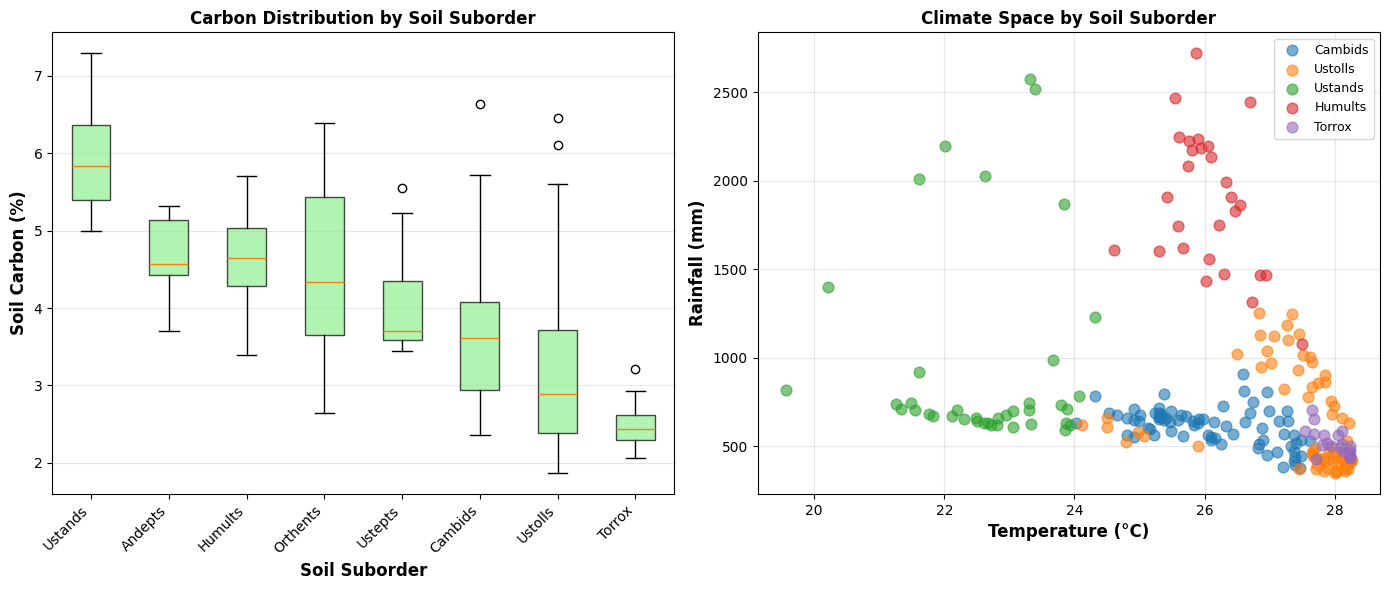

In [255]:
# ============================================================================
# 10. SOIL SUBORDER EFFECTS
# ============================================================================
print("\n" + "="*80)
print("SOIL SUBORDER EFFECTS ON CARBON")
print("="*80)

# Filter to suborders with sufficient sample size
suborder_counts = polygon_summary['Suborder_list'].value_counts()
min_n = 5
common_suborders = suborder_counts[suborder_counts >= min_n].index.tolist()

print(f"\nAnalyzing suborders with n ≥ {min_n}")
print(f"Included suborders: {common_suborders}")

soil_data = polygon_summary[polygon_summary['Suborder_list'].isin(common_suborders)].copy()

# ANOVA: Carbon by Suborder
suborder_groups = [soil_data[soil_data['Suborder_list'] == sub]['carbon_mean'].values
                   for sub in common_suborders]
f_stat, p_val = stats.f_oneway(*suborder_groups)

print("\n" + "-"*80)
print("One-Way ANOVA: Carbon ~ Soil Suborder")
print("-"*80)
print(f"F-statistic: {f_stat:.3f}")
print(f"p-value: {p_val:.4e}")
if p_val < 0.05:
    print("  → Soil suborder has SIGNIFICANT effect on carbon")
else:
    print("  → No significant difference in carbon across soil suborders")

# Summary stats by suborder
print("\nCarbon by Soil Suborder:")
suborder_summary = soil_data.groupby('Suborder_list').agg({
    'carbon_mean': ['mean', 'std', 'count'],
    'tmax_ann_mean_30m': 'mean',
    'rainfall_ann_mm_30m': 'mean'
}).round(2)
suborder_summary.columns = ['carbon_mean', 'carbon_std', 'n', 'temp_mean', 'rain_mean']
suborder_summary = suborder_summary.sort_values('carbon_mean', ascending=False)
print(suborder_summary)

# ANCOVA: Carbon ~ Climate + Suborder
soil_model = ols('carbon_mean ~ tmax_ann_mean_30m + rainfall_ann_mm_30m + C(Suborder_list)',
                 data=soil_data).fit()
soil_anova = anova_lm(soil_model, typ=2)

print("\n" + "-"*80)
print("ANCOVA: Carbon ~ Temperature + Rainfall + Soil Suborder")
print("-"*80)
print(soil_anova)
print(f"\nModel R²: {soil_model.rsquared:.3f}")
print(f"Adjusted R²: {soil_model.rsquared_adj:.3f}")

# Visualize soil suborder effects
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Box plot by suborder
ax1 = axes[0]
suborder_order = suborder_summary.index.tolist()
boxplot_data = [soil_data[soil_data['Suborder_list'] == sub]['carbon_mean'].values
                for sub in suborder_order]
bp = ax1.boxplot(boxplot_data, labels=suborder_order, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('#90EE90')
    patch.set_alpha(0.7)
ax1.set_ylabel('Soil Carbon (%)', fontweight='bold', fontsize=12)
ax1.set_xlabel('Soil Suborder', fontweight='bold', fontsize=12)
ax1.set_title('Carbon Distribution by Soil Suborder', fontweight='bold', fontsize=12)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Climate space colored by suborder
ax2 = axes[1]
for suborder in common_suborders[:5]:  # Top 5 most common
    subset = soil_data[soil_data['Suborder_list'] == suborder]
    ax2.scatter(subset['tmax_ann_mean_30m'], subset['rainfall_ann_mm_30m'],
               label=suborder, alpha=0.6, s=60)
ax2.set_xlabel('Temperature (°C)', fontweight='bold', fontsize=12)
ax2.set_ylabel('Rainfall (mm)', fontweight='bold', fontsize=12)
ax2.set_title('Climate Space by Soil Suborder', fontweight='bold', fontsize=12)
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [256]:
# ============================================================================
# 11. TEMPORAL CHANGE ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("TEMPORAL CHANGE ANALYSIS (2016-2024)")
print("="*80)

# Overall temporal trends
print("\nOverall carbon change:")
print(f"  Mean change: {polygon_summary['carbon_change'].mean():.3f}% ({polygon_summary['carbon_pct_change'].mean():.2f}%)")
print(f"  Std: {polygon_summary['carbon_change'].std():.3f}%")
print(f"  Range: {polygon_summary['carbon_change'].min():.3f} to {polygon_summary['carbon_change'].max():.3f}%")

# Test if overall change is significant
t_stat, p_val = stats.ttest_1samp(polygon_summary['carbon_change'].dropna(), 0)
print(f"\nOne-sample t-test (H0: change = 0):")
print(f"  t-statistic: {t_stat:.3f}")
print(f"  p-value: {p_val:.4e}")
if p_val < 0.05:
    if polygon_summary['carbon_change'].mean() > 0:
        print("  → Carbon INCREASED significantly over time")
    else:
        print("  → Carbon DECREASED significantly over time")
else:
    print("  → No significant change in carbon over time")

# Temporal change by land use
print("\n" + "-"*80)
print("Temporal change by current land use:")
print("-"*80)
temporal_by_landuse = polygon_summary.groupby('landuse_current').agg({
    'carbon_change': ['mean', 'std', 'count'],
    'carbon_pct_change': 'mean'
}).round(3)
temporal_by_landuse.columns = ['change_mean', 'change_std', 'n', 'pct_change']
print(temporal_by_landuse)

# Test temporal change by land use type
for landuse in main_landuses:
    subset = polygon_summary[polygon_summary['landuse_current'] == landuse]
    t_stat, p_val = stats.ttest_1samp(subset['carbon_change'].dropna(), 0)
    print(f"\n{landuse.capitalize()}: mean change = {subset['carbon_change'].mean():.3f}%, p = {p_val:.4f}")

# Temporal change by transition type
print("\n" + "-"*80)
print("Temporal change by land use transition:")
print("-"*80)
key_transitions = ['sugarcane → sugarcane', 'sugarcane → range',
                   'pineapple → pineapple', 'pineapple → range']
trans_temporal = polygon_summary[polygon_summary['transition'].isin(key_transitions)]

temporal_by_transition = trans_temporal.groupby('transition').agg({
    'carbon_change': ['mean', 'std', 'count'],
    'carbon_pct_change': 'mean'
}).round(3)
temporal_by_transition.columns = ['change_mean', 'change_std', 'n', 'pct_change']
print(temporal_by_transition)

# Climate gradient effects on temporal change
print("\n" + "-"*80)
print("Climate effects on temporal carbon change:")
print("-"*80)

# Correlation: Does climate predict carbon change?
corr_temp_change = polygon_summary[['tmax_ann_mean_30m', 'carbon_change']].corr().iloc[0, 1]
corr_rain_change = polygon_summary[['rainfall_ann_mm_30m', 'carbon_change']].corr().iloc[0, 1]

print(f"\nCorrelation: Temperature vs Carbon Change: r = {corr_temp_change:.3f}")
print(f"Correlation: Rainfall vs Carbon Change: r = {corr_rain_change:.3f}")

# Regression: Carbon change ~ Climate
slope_t, intercept_t, r_t, p_t, se_t = stats.linregress(
    polygon_summary['tmax_ann_mean_30m'].dropna(),
    polygon_summary['carbon_change'].dropna()
)
print(f"\nRegression: Carbon Change ~ Temperature")
print(f"  Slope: {slope_t:.4f}, R² = {r_t**2:.3f}, p = {p_t:.4f}")

slope_r, intercept_r, r_r, p_r, se_r = stats.linregress(
    polygon_summary['rainfall_ann_mm_30m'].dropna(),
    polygon_summary['carbon_change'].dropna()
)
print(f"\nRegression: Carbon Change ~ Rainfall")
print(f"  Slope: {slope_r:.6f}, R² = {r_r**2:.3f}, p = {p_r:.4f}")


TEMPORAL CHANGE ANALYSIS (2016-2024)

Overall carbon change:
  Mean change: -0.658% (-17.81%)
  Std: 0.554%
  Range: -2.124 to 1.969%

One-sample t-test (H0: change = 0):
  t-statistic: -19.276
  p-value: 3.1993e-52
  → Carbon DECREASED significantly over time

--------------------------------------------------------------------------------
Temporal change by current land use:
--------------------------------------------------------------------------------
                 change_mean  change_std    n  pct_change
landuse_current                                          
pineapple             -0.270       0.488   70      -5.445
range                 -0.577       0.420  114     -13.858
sugarcane             -1.114       0.462   78     -34.797

Sugarcane: mean change = -1.114%, p = 0.0000

Pineapple: mean change = -0.270%, p = 0.0000

Range: mean change = -0.577%, p = 0.0000

--------------------------------------------------------------------------------
Temporal change by land use tran

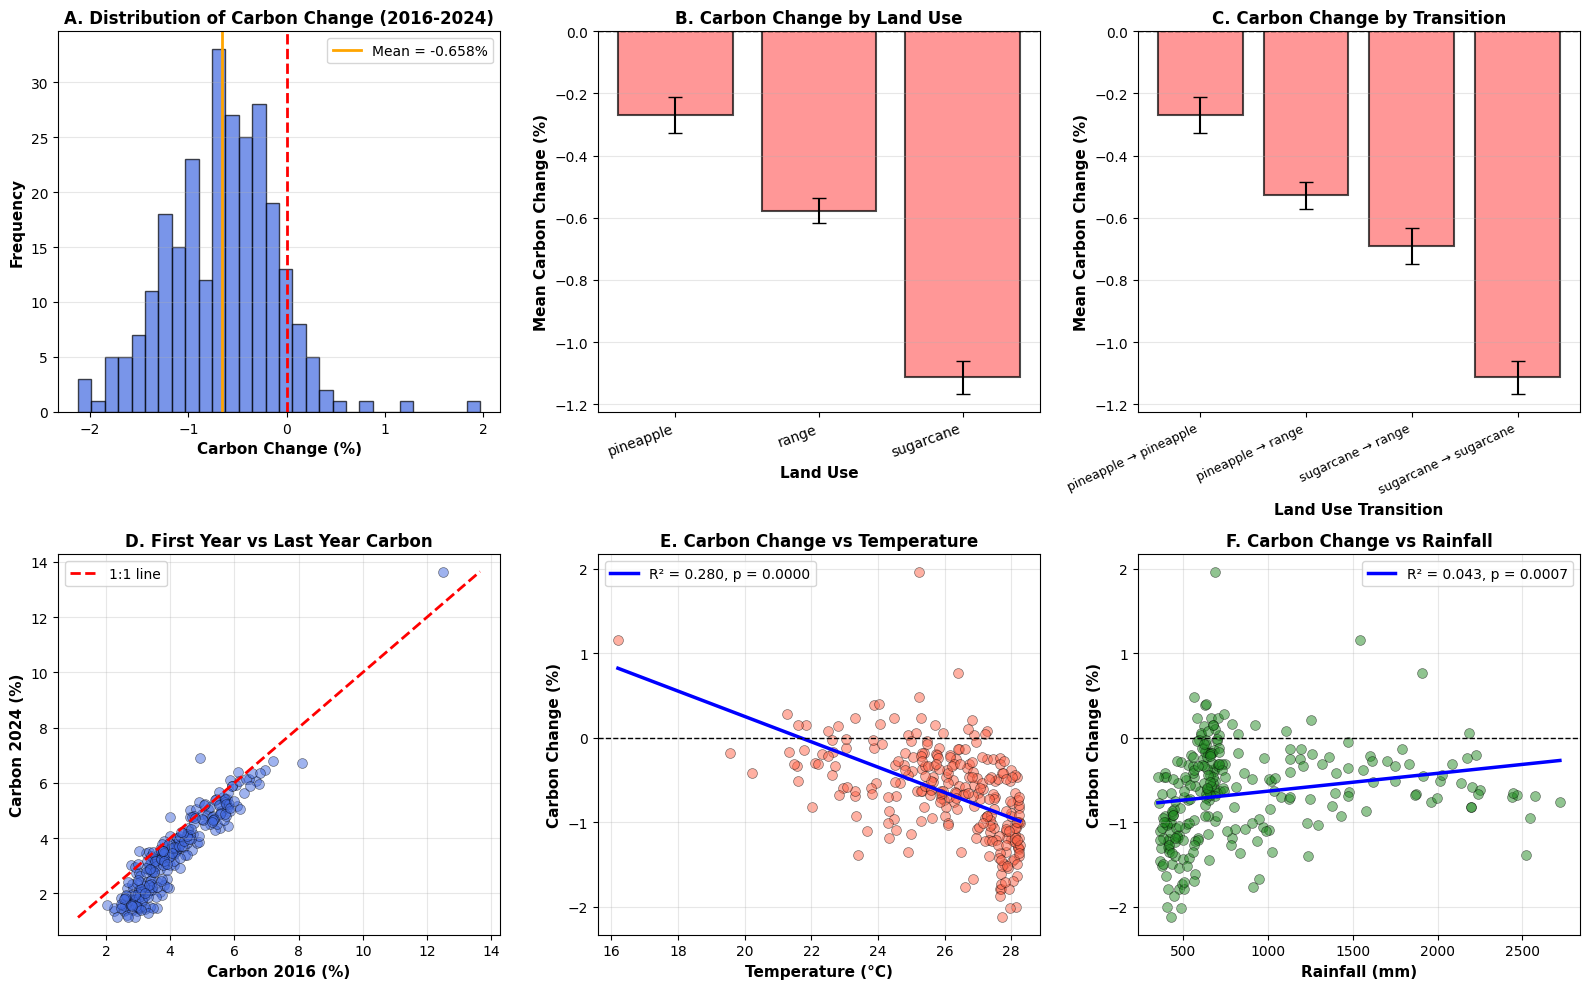

In [257]:
# Visualizations
fig = plt.figure(figsize=(16, 10))

# A. Overall temporal change distribution
ax1 = plt.subplot(2, 3, 1)
ax1.hist(polygon_summary['carbon_change'], bins=30, alpha=0.7,
         color='#4169E1', edgecolor='black')
ax1.axvline(0, color='red', linestyle='--', linewidth=2)
ax1.axvline(polygon_summary['carbon_change'].mean(), color='orange',
            linestyle='-', linewidth=2, label=f"Mean = {polygon_summary['carbon_change'].mean():.3f}%")
ax1.set_xlabel('Carbon Change (%)', fontweight='bold', fontsize=11)
ax1.set_ylabel('Frequency', fontweight='bold', fontsize=11)
ax1.set_title('A. Distribution of Carbon Change (2016-2024)', fontweight='bold', fontsize=12)
ax1.legend()
ax1.grid(alpha=0.3, axis='y')

# B. Temporal change by land use
ax2 = plt.subplot(2, 3, 2)
temporal_lu = temporal_by_landuse.reset_index()
x_pos = np.arange(len(temporal_lu))
colors_change = ['#90EE90' if x > 0 else '#FF6B6B' for x in temporal_lu['change_mean']]
bars = ax2.bar(x_pos, temporal_lu['change_mean'],
               yerr=temporal_lu['change_std'] / np.sqrt(temporal_lu['n']),
               capsize=5, alpha=0.7, color=colors_change,
               edgecolor='black', linewidth=1.5)
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(temporal_lu['landuse_current'], rotation=20, ha='right')
ax2.set_ylabel('Mean Carbon Change (%)', fontweight='bold', fontsize=11)
ax2.set_xlabel('Land Use', fontweight='bold', fontsize=11)
ax2.set_title('B. Carbon Change by Land Use', fontweight='bold', fontsize=12)
ax2.grid(alpha=0.3, axis='y')

# C. Temporal change by transition
ax3 = plt.subplot(2, 3, 3)
temporal_trans = temporal_by_transition.reset_index()
x_pos = np.arange(len(temporal_trans))
colors_trans = ['#90EE90' if x > 0 else '#FF6B6B' for x in temporal_trans['change_mean']]
bars = ax3.bar(x_pos, temporal_trans['change_mean'],
               yerr=temporal_trans['change_std'] / np.sqrt(temporal_trans['n']),
               capsize=5, alpha=0.7, color=colors_trans,
               edgecolor='black', linewidth=1.5)
ax3.axhline(0, color='black', linestyle='--', linewidth=1)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(temporal_trans['transition'], rotation=25, ha='right', fontsize=9)
ax3.set_ylabel('Mean Carbon Change (%)', fontweight='bold', fontsize=11)
ax3.set_xlabel('Land Use Transition', fontweight='bold', fontsize=11)
ax3.set_title('C. Carbon Change by Transition', fontweight='bold', fontsize=12)
ax3.grid(alpha=0.3, axis='y')

# D. First year vs last year
ax4 = plt.subplot(2, 3, 4)
ax4.scatter(polygon_summary['carbon_first_year'], polygon_summary['carbon_last_year'],
           alpha=0.5, s=50, c='#4169E1', edgecolors='black', linewidths=0.5)
# Add 1:1 line
min_val = min(polygon_summary['carbon_first_year'].min(), polygon_summary['carbon_last_year'].min())
max_val = max(polygon_summary['carbon_first_year'].max(), polygon_summary['carbon_last_year'].max())
ax4.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='1:1 line')
ax4.set_xlabel('Carbon 2016 (%)', fontweight='bold', fontsize=11)
ax4.set_ylabel('Carbon 2024 (%)', fontweight='bold', fontsize=11)
ax4.set_title('D. First Year vs Last Year Carbon', fontweight='bold', fontsize=12)
ax4.legend()
ax4.grid(alpha=0.3)

# E. Carbon change vs Temperature
ax5 = plt.subplot(2, 3, 5)
ax5.scatter(polygon_summary['tmax_ann_mean_30m'], polygon_summary['carbon_change'],
           alpha=0.5, s=50, c='#FF6347', edgecolors='black', linewidths=0.5)
x_temp = np.linspace(polygon_summary['tmax_ann_mean_30m'].min(),
                     polygon_summary['tmax_ann_mean_30m'].max(), 100)
y_temp = slope_t * x_temp + intercept_t
ax5.plot(x_temp, y_temp, 'b-', linewidth=2.5,
         label=f'R² = {r_t**2:.3f}, p = {p_t:.4f}')
ax5.axhline(0, color='black', linestyle='--', linewidth=1)
ax5.set_xlabel('Temperature (°C)', fontweight='bold', fontsize=11)
ax5.set_ylabel('Carbon Change (%)', fontweight='bold', fontsize=11)
ax5.set_title('E. Carbon Change vs Temperature', fontweight='bold', fontsize=12)
ax5.legend()
ax5.grid(alpha=0.3)

# F. Carbon change vs Rainfall
ax6 = plt.subplot(2, 3, 6)
ax6.scatter(polygon_summary['rainfall_ann_mm_30m'], polygon_summary['carbon_change'],
           alpha=0.5, s=50, c='#228B22', edgecolors='black', linewidths=0.5)
x_rain = np.linspace(polygon_summary['rainfall_ann_mm_30m'].min(),
                     polygon_summary['rainfall_ann_mm_30m'].max(), 100)
y_rain = slope_r * x_rain + intercept_r
ax6.plot(x_rain, y_rain, 'b-', linewidth=2.5,
         label=f'R² = {r_r**2:.3f}, p = {p_r:.4f}')
ax6.axhline(0, color='black', linestyle='--', linewidth=1)
ax6.set_xlabel('Rainfall (mm)', fontweight='bold', fontsize=11)
ax6.set_ylabel('Carbon Change (%)', fontweight='bold', fontsize=11)
ax6.set_title('F. Carbon Change vs Rainfall', fontweight='bold', fontsize=12)
ax6.legend()
ax6.grid(alpha=0.3)

plt.tight_layout()
plt.show()

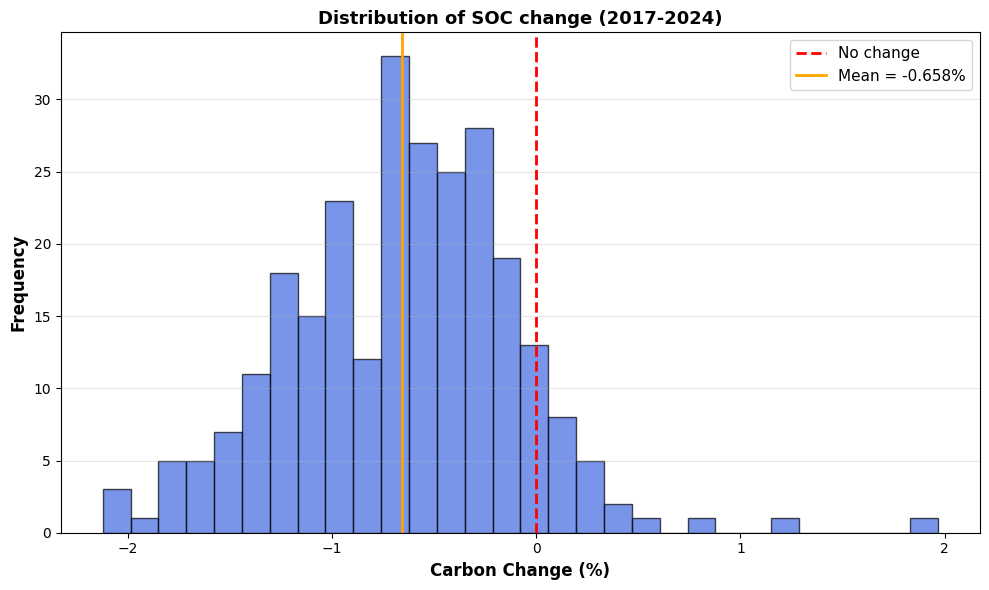

CARBON CHANGE SUMMARY STATISTICS
Mean change: -0.658%
Median change: -0.626%
Std deviation: 0.554%
Range: -2.124% to 1.969%
Polygons gaining carbon: 24 (9.1%)
Polygons losing carbon: 240 (90.9%)


In [316]:
# Figure A: Overall temporal change distribution
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(polygon_summary['carbon_change'], bins=30, alpha=0.7,
        color='#4169E1', edgecolor='black')
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='No change')
ax.axvline(polygon_summary['carbon_change'].mean(), color='orange',
           linestyle='-', linewidth=2, label=f"Mean = {polygon_summary['carbon_change'].mean():.3f}%")
ax.set_xlabel('Carbon Change (%)', fontweight='bold', fontsize=12)
ax.set_ylabel('Frequency', fontweight='bold', fontsize=12)
ax.set_title('Distribution of SOC change (2017-2024)', fontweight='bold', fontsize=13)
ax.legend(fontsize=11)
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary statistics
print("="*60)
print("CARBON CHANGE SUMMARY STATISTICS")
print("="*60)
print(f"Mean change: {polygon_summary['carbon_change'].mean():.3f}%")
print(f"Median change: {polygon_summary['carbon_change'].median():.3f}%")
print(f"Std deviation: {polygon_summary['carbon_change'].std():.3f}%")
print(f"Range: {polygon_summary['carbon_change'].min():.3f}% to {polygon_summary['carbon_change'].max():.3f}%")
print(f"Polygons gaining carbon: {(polygon_summary['carbon_change'] > 0).sum()} ({(polygon_summary['carbon_change'] > 0).sum()/len(polygon_summary)*100:.1f}%)")
print(f"Polygons losing carbon: {(polygon_summary['carbon_change'] < 0).sum()} ({(polygon_summary['carbon_change'] < 0).sum()/len(polygon_summary)*100:.1f}%)")
print("="*60)

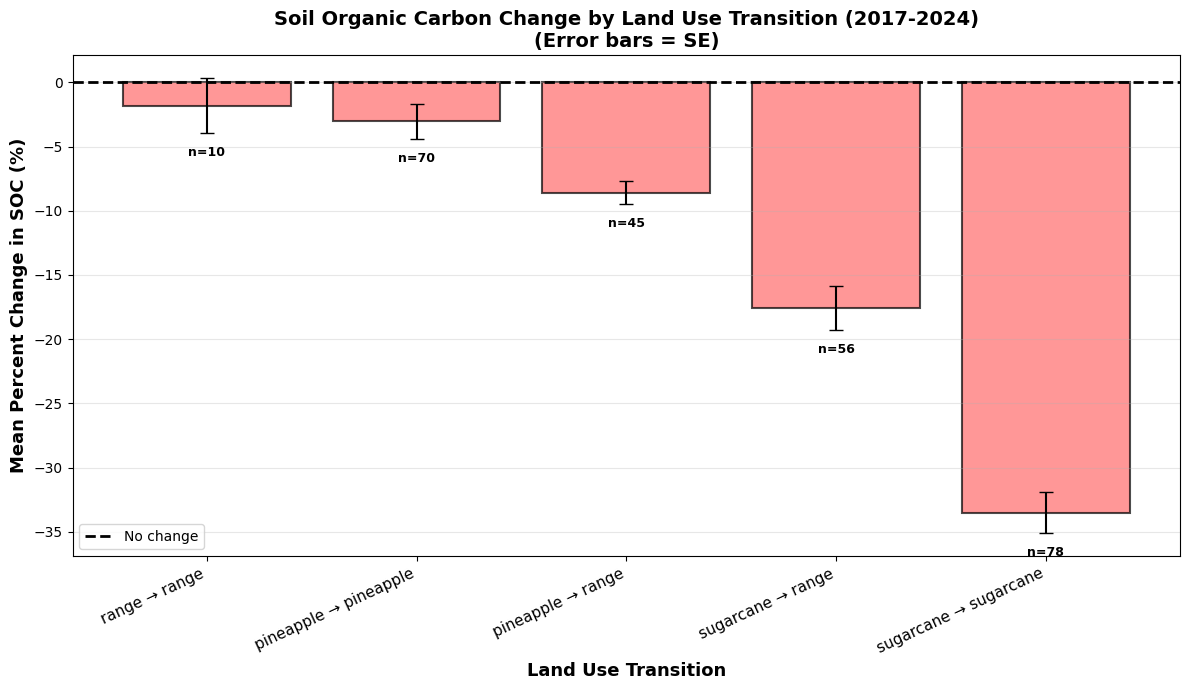


PERCENT CHANGE IN CARBON BY LAND USE TRANSITION (2017-2024)
Transition                              n    Mean %Δ       SD Trend     
--------------------------------------------------------------------------------
range → range                          10     -1.81%    6.77% LOSS      
pineapple → pineapple                  70     -3.03%   11.36% LOSS      
pineapple → range                      45     -8.59%    5.91% LOSS      
sugarcane → range                      56    -17.55%   12.94% LOSS      
sugarcane → sugarcane                  78    -33.52%   14.15% LOSS      

Transitions gaining carbon: 0
Transitions losing carbon: 5
Overall mean change: -12.90%


In [319]:
import matplotlib.pyplot as plt
import numpy as np

# Get the date columns
date_cols = [col for col in carbon_landuse.columns if col.startswith('d_')]

# Find columns closest to 2017 and 2024
# 2017 start: d_20170116 (January 2017)
# 2024 end: d_20241205 (December 2024)
start_col_2017 = 'd_20170116'  # First available date in 2017
end_col_2024 = 'd_20241205'    # Last available date in 2024

# Calculate change from 2017 to 2024 for each point
carbon_landuse['carbon_2017'] = carbon_landuse[start_col_2017]
carbon_landuse['carbon_2024'] = carbon_landuse[end_col_2024]
carbon_landuse['carbon_change_2017_2024'] = carbon_landuse['carbon_2024'] - carbon_landuse['carbon_2017']
carbon_landuse['carbon_pct_change_2017_2024'] = (
    (carbon_landuse['carbon_2024'] - carbon_landuse['carbon_2017']) /
    carbon_landuse['carbon_2017'] * 100
)

# Aggregate by polygon and transition
polygon_change = carbon_landuse.groupby(['poly_id', 'transition']).agg({
    'carbon_change_2017_2024': 'mean',
    'carbon_pct_change_2017_2024': 'mean'
}).reset_index()

# Calculate statistics by transition
transition_change_stats = polygon_change.groupby('transition').agg({
    'carbon_pct_change_2017_2024': ['mean', 'std', 'count']
}).reset_index()
transition_change_stats.columns = ['transition', 'mean_pct_change', 'std_pct_change', 'n']
transition_change_stats = transition_change_stats[transition_change_stats['n'] >= 3]  # Filter small samples
transition_change_stats = transition_change_stats.sort_values('mean_pct_change', ascending=False)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 7))

x_pos = np.arange(len(transition_change_stats))
# Color by gain (green) or loss (red)
colors_change = ['#90EE90' if x > 0 else '#FF6B6B' for x in transition_change_stats['mean_pct_change']]

# Calculate standard error
se = transition_change_stats['std_pct_change'] / np.sqrt(transition_change_stats['n'])

bars = ax.bar(x_pos, transition_change_stats['mean_pct_change'],
              yerr=se,
              capsize=5, alpha=0.7, color=colors_change,
              edgecolor='black', linewidth=1.5)

# Add zero line
ax.axhline(0, color='black', linestyle='--', linewidth=2, label='No change')

# Add sample sizes on bars
for i, (bar, n, pct_change) in enumerate(zip(bars, transition_change_stats['n'],
                                               transition_change_stats['mean_pct_change'])):
    height = bar.get_height()
    y_pos = height + se.iloc[i] + 1 if height > 0 else height - se.iloc[i] - 1
    ax.text(bar.get_x() + bar.get_width()/2., y_pos,
            f'n={int(n)}', ha='center', va='bottom' if height > 0 else 'top',
            fontweight='bold', fontsize=9)

ax.set_xticks(x_pos)
ax.set_xticklabels(transition_change_stats['transition'], rotation=25, ha='right', fontsize=11)
ax.set_ylabel('Mean Percent Change in SOC (%)', fontweight='bold', fontsize=13)
ax.set_xlabel('Land Use Transition', fontweight='bold', fontsize=13)
ax.set_title('Soil Organic Carbon Change by Land Use Transition (2017-2024)\n(Error bars = SE)',
             fontweight='bold', fontsize=14)
ax.grid(alpha=0.3, axis='y')
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("PERCENT CHANGE IN CARBON BY LAND USE TRANSITION (2017-2024)")
print("="*80)
print(f"{'Transition':<35} {'n':>5} {'Mean %Δ':>10} {'SD':>8} {'Trend':<10}")
print("-"*80)
for _, row in transition_change_stats.iterrows():
    trend = "GAIN" if row['mean_pct_change'] > 0 else "LOSS"
    print(f"{row['transition']:<35} {int(row['n']):>5} {row['mean_pct_change']:>9.2f}% "
          f"{row['std_pct_change']:>7.2f}% {trend:<10}")
print("="*80)

# Summary counts
n_gaining = (transition_change_stats['mean_pct_change'] > 0).sum()
n_losing = (transition_change_stats['mean_pct_change'] < 0).sum()
print(f"\nTransitions gaining carbon: {n_gaining}")
print(f"Transitions losing carbon: {n_losing}")
print(f"Overall mean change: {transition_change_stats['mean_pct_change'].mean():.2f}%")

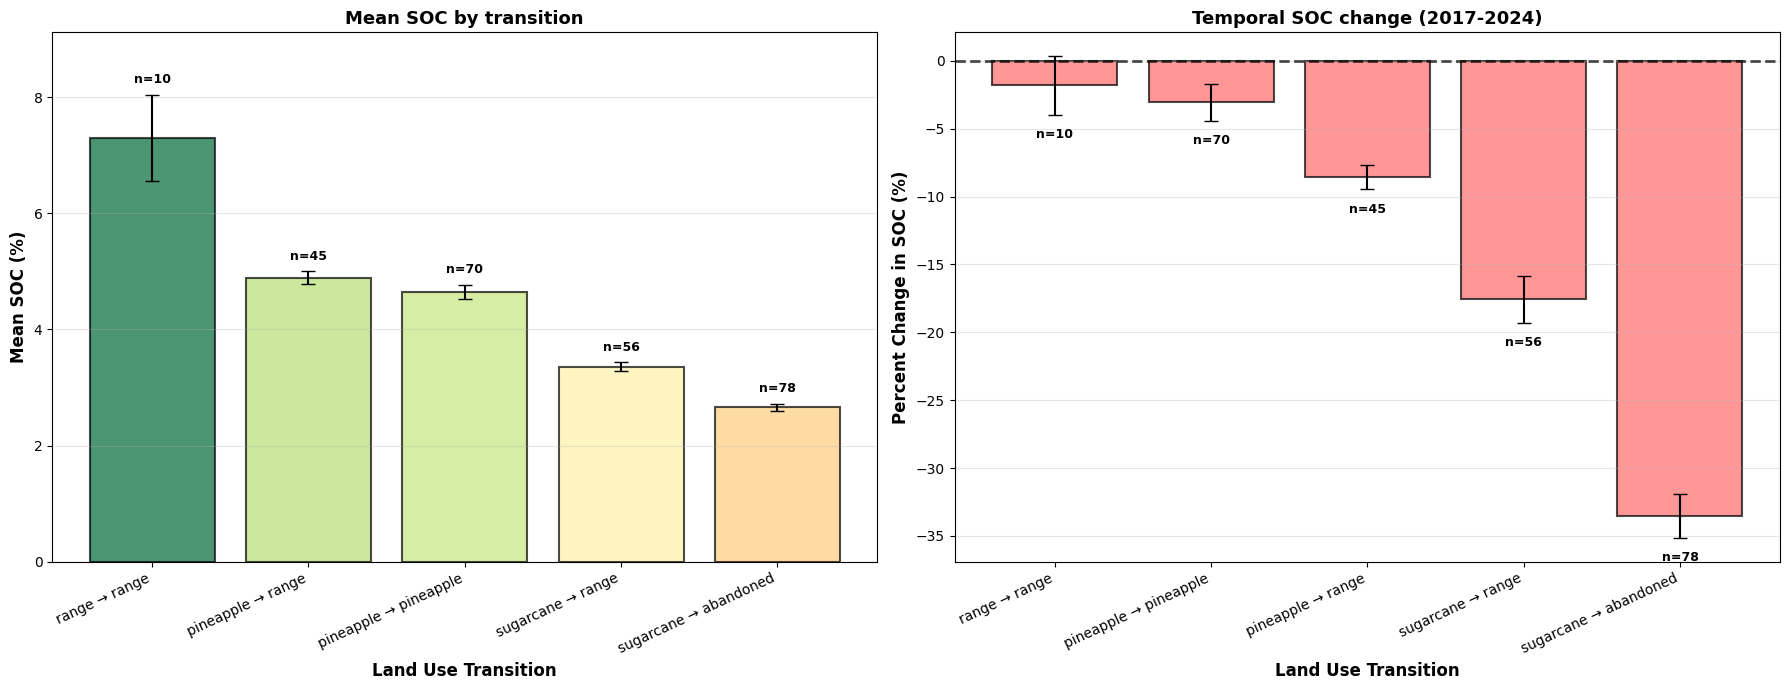


COMPARISON: MEAN LEVELS vs TEMPORAL TRENDS

Transition                             Mean C%   2017-24 Δ% Interpretation
-----------------------------------------------------------------------------------------------
range → range                            7.29%       -1.81%  Declining
pineapple → range                        4.89%       -8.59%  Declining
pineapple → pineapple                    4.65%       -3.03%  Declining
sugarcane → range                        3.36%      -17.55% High C, but declining
sugarcane → abandoned                    2.66%      -33.52% Low C, declining

KEY FINDINGS:
• Plot A: Sugarcane→Range has ~27% MORE carbon than Sugarcane→Abandoned
• Plot B: But BOTH sugarcane transitions are losing carbon over time (2017-2024)
• Interpretation: Converting to rangeland increases carbon stocks, but
                  regional climate/environmental changes may be causing decline


In [324]:
# Replace the transition label in both dataframes
polygon_summary['transition'] = polygon_summary['transition'].replace('sugarcane → sugarcane', 'sugarcane → abandoned')
polygon_change['transition'] = polygon_change['transition'].replace('sugarcane → sugarcane', 'sugarcane → abandoned')

# Prepare data
# Left plot: Mean carbon levels (cross-sectional comparison)
transition_means = polygon_summary.groupby('transition').agg({
    'carbon_mean': ['mean', 'std', 'count']
}).reset_index()
transition_means.columns = ['transition', 'mean_carbon', 'std_carbon', 'n']
transition_means = transition_means[transition_means['n'] >= 3]
transition_means = transition_means.sort_values('mean_carbon', ascending=False)

# Right plot: Temporal change (2017-2024)
transition_change_stats = polygon_change.groupby('transition').agg({
    'carbon_pct_change_2017_2024': ['mean', 'std', 'count']
}).reset_index()
transition_change_stats.columns = ['transition', 'mean_pct_change', 'std_pct_change', 'n']
transition_change_stats = transition_change_stats[transition_change_stats['n'] >= 3]
transition_change_stats = transition_change_stats.sort_values('mean_pct_change', ascending=False)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# LEFT PLOT: Mean Carbon Levels
x_pos1 = np.arange(len(transition_means))
colors_level = plt.cm.RdYlGn(transition_means['mean_carbon'] / transition_means['mean_carbon'].max())
se1 = transition_means['std_carbon'] / np.sqrt(transition_means['n'])

bars1 = ax1.bar(x_pos1, transition_means['mean_carbon'],
                yerr=se1, capsize=5, alpha=0.7, color=colors_level,
                edgecolor='black', linewidth=1.5)

# Add sample sizes
for i, (bar, n) in enumerate(zip(bars1, transition_means['n'])):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + se1.iloc[i] + 0.15,
            f'n={int(n)}', ha='center', va='bottom', fontweight='bold', fontsize=9)

ax1.set_xticks(x_pos1)
ax1.set_xticklabels(transition_means['transition'], rotation=25, ha='right', fontsize=10)
ax1.set_ylabel('Mean SOC (%)', fontweight='bold', fontsize=12)
ax1.set_xlabel('Land Use Transition', fontweight='bold', fontsize=12)
ax1.set_title('Mean SOC by transition',
              fontweight='bold', fontsize=13)
ax1.grid(alpha=0.3, axis='y')
ax1.set_ylim(0, transition_means['mean_carbon'].max() * 1.25)

# RIGHT PLOT: Temporal Change
x_pos2 = np.arange(len(transition_change_stats))
colors_change = ['#90EE90' if x > 0 else '#FF6B6B' for x in transition_change_stats['mean_pct_change']]
se2 = transition_change_stats['std_pct_change'] / np.sqrt(transition_change_stats['n'])

bars2 = ax2.bar(x_pos2, transition_change_stats['mean_pct_change'],
                yerr=se2, capsize=5, alpha=0.7, color=colors_change,
                edgecolor='black', linewidth=1.5)

# Add zero line
ax2.axhline(0, color='black', linestyle='--', linewidth=2, alpha=0.7)

# Add sample sizes
for i, (bar, n, pct_change) in enumerate(zip(bars2, transition_change_stats['n'],
                                               transition_change_stats['mean_pct_change'])):
    height = bar.get_height()
    y_pos = height + se2.iloc[i] + 1 if height > 0 else height - se2.iloc[i] - 1
    ax2.text(bar.get_x() + bar.get_width()/2., y_pos,
            f'n={int(n)}', ha='center', va='bottom' if height > 0 else 'top',
            fontweight='bold', fontsize=9)

ax2.set_xticks(x_pos2)
ax2.set_xticklabels(transition_change_stats['transition'], rotation=25, ha='right', fontsize=10)
ax2.set_ylabel('Percent Change in SOC (%)', fontweight='bold', fontsize=12)
ax2.set_xlabel('Land Use Transition', fontweight='bold', fontsize=12)
ax2.set_title('Temporal SOC change (2017-2024)',
              fontweight='bold', fontsize=13)
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print comparison summary
print("\n" + "="*80)
print("COMPARISON: MEAN LEVELS vs TEMPORAL TRENDS")
print("="*80)
print(f"\n{'Transition':<35} {'Mean C%':>10} {'2017-24 Δ%':>12} {'Interpretation'}")
print("-"*95)

# Merge the two datasets for comparison
for transition in transition_means['transition']:
    if transition in transition_change_stats['transition'].values:
        mean_c = transition_means[transition_means['transition'] == transition]['mean_carbon'].values[0]
        change = transition_change_stats[transition_change_stats['transition'] == transition]['mean_pct_change'].values[0]

        if 'sugarcane' in transition.lower():
            print(f"{transition:<35} {mean_c:>9.2f}% {change:>11.2f}% ", end="")
            if 'range' in transition.lower():
                print("High C, but declining")
            elif 'abandoned' in transition.lower():
                print("Low C, declining")
        else:
            trend = "Gaining" if change > 0 else "Declining"
            print(f"{transition:<35} {mean_c:>9.2f}% {change:>11.2f}%  {trend}")

print("\n" + "="*80)
print("KEY FINDINGS:")
print("="*80)
print("• Plot A: Sugarcane→Range has ~27% MORE carbon than Sugarcane→Abandoned")
print("• Plot B: But BOTH sugarcane transitions are losing carbon over time (2017-2024)")
print("• Interpretation: Converting to rangeland increases carbon stocks, but")
print("                  regional climate/environmental changes may be causing decline")
print("="*80)

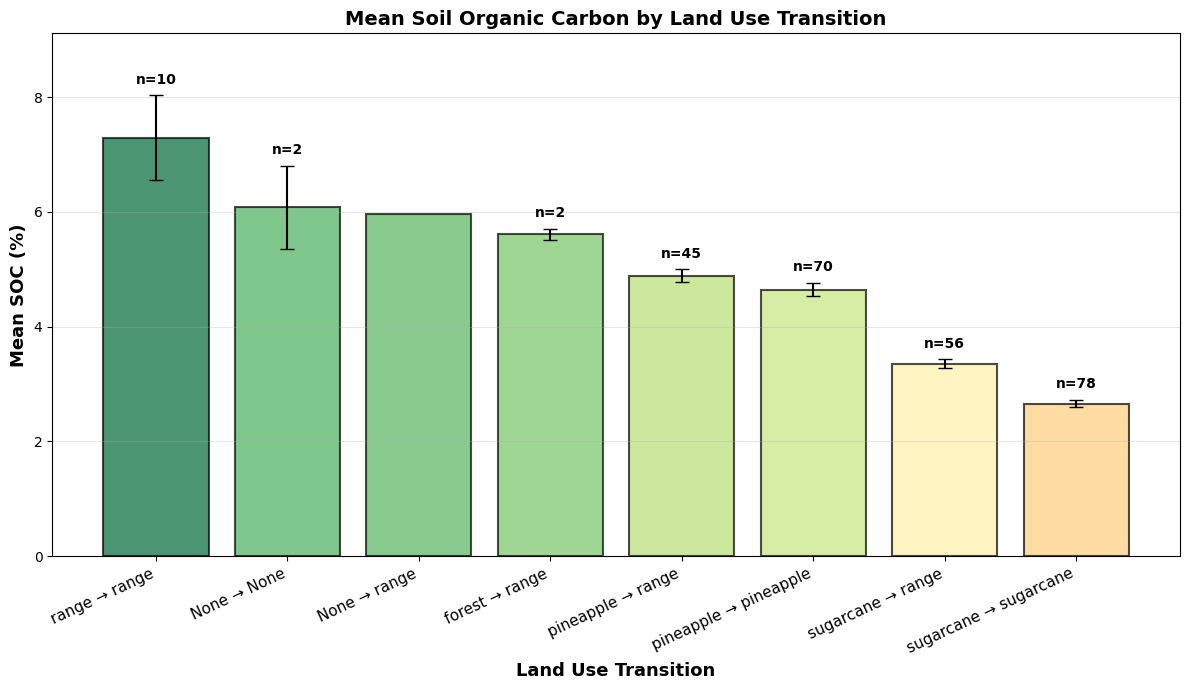


MEAN CARBON BY LAND USE TRANSITION
range → range                    7.29% ±  2.34% (n=10)
None → None                      6.08% ±  1.02% (n=2)
None → range                     5.96% ±   nan% (n=1)
forest → range                   5.61% ±  0.14% (n=2)
pineapple → range                4.89% ±  0.75% (n=45)
pineapple → pineapple            4.65% ±  1.00% (n=70)
sugarcane → range                3.36% ±  0.57% (n=56)
sugarcane → sugarcane            2.66% ±  0.55% (n=78)


In [318]:
# Mean Carbon by Land Use Transition
fig, ax = plt.subplots(figsize=(12, 7))

# Calculate mean carbon for each transition
transition_means = polygon_summary.groupby('transition').agg({
    'carbon_mean': ['mean', 'std', 'count']
}).reset_index()
transition_means.columns = ['transition', 'mean_carbon', 'std_carbon', 'n']
transition_means = transition_means.sort_values('mean_carbon', ascending=False)

x_pos = np.arange(len(transition_means))
# Color by carbon level (green for high, red for low)
colors_trans = plt.cm.RdYlGn(transition_means['mean_carbon'] / transition_means['mean_carbon'].max())

bars = ax.bar(x_pos, transition_means['mean_carbon'],
              yerr=transition_means['std_carbon'] / np.sqrt(transition_means['n']),
              capsize=5, alpha=0.7, color=colors_trans,
              edgecolor='black', linewidth=1.5)

# Add sample sizes on bars
for i, (bar, n) in enumerate(zip(bars, transition_means['n'])):
    height = bar.get_height()
    se = transition_means.iloc[i]['std_carbon'] / np.sqrt(n)
    ax.text(bar.get_x() + bar.get_width()/2., height + se + 0.15,
            f'n={int(n)}', ha='center', va='bottom', fontweight='bold', fontsize=10)

ax.set_xticks(x_pos)
ax.set_xticklabels(transition_means['transition'], rotation=25, ha='right', fontsize=11)
ax.set_ylabel('Mean SOC (%)', fontweight='bold', fontsize=13)
ax.set_xlabel('Land Use Transition', fontweight='bold', fontsize=13)
ax.set_title('Mean Soil Organic Carbon by Land Use Transition', fontweight='bold', fontsize=14)
ax.grid(alpha=0.3, axis='y')
ax.set_ylim(0, transition_means['mean_carbon'].max() * 1.25)

plt.tight_layout()
plt.show()

# Print the values
print("\n" + "="*80)
print("MEAN CARBON BY LAND USE TRANSITION")
print("="*80)
for _, row in transition_means.iterrows():
    print(f"{row['transition']:<30} {row['mean_carbon']:>6.2f}% ± {row['std_carbon']:>5.2f}% (n={int(row['n'])})")
print("="*80)

In [258]:
# ============================================================================
# 12. COMPREHENSIVE SUMMARY TABLE
# ============================================================================
print("\n" + "="*80)
print("COMPREHENSIVE SUMMARY: ALL MODELS")
print("="*80)

summary_results = pd.DataFrame({
    'Analysis': [
        'Simple: Carbon ~ Temperature',
        'Simple: Carbon ~ Rainfall',
        'Multiple: Carbon ~ Temp + Rain',
        'ANCOVA: Carbon ~ Temp + LandUse',
        'ANCOVA: Carbon ~ Rain + LandUse',
        'ANCOVA: Carbon ~ Temp + Rain + LandUse',
        'Interaction: Carbon ~ Temp × LandUse',
        'Interaction: Carbon ~ Rain × LandUse',
        'Soil: Carbon ~ Temp + Rain + Suborder',
        'Temporal: Change ~ Temperature',
        'Temporal: Change ~ Rainfall'
    ],
    'R²': [
        r_temp**2,
        r_rain**2,
        r2,
        model1.rsquared,
        model2.rsquared,
        model3.rsquared,
        model_int1.rsquared,
        model_int2.rsquared,
        soil_model.rsquared,
        r_t**2,
        r_r**2
    ],
    'Adj_R²': [
        np.nan,
        np.nan,
        np.nan,
        model1.rsquared_adj,
        model2.rsquared_adj,
        model3.rsquared_adj,
        model_int1.rsquared_adj,
        model_int2.rsquared_adj,
        soil_model.rsquared_adj,
        np.nan,
        np.nan
    ],
    'Key_Finding': [
        f'Strong negative effect (β={slope_temp:.3f})',
        f'Moderate positive effect (β={slope_rain:.5f})',
        f'Both predictors significant',
        f'LandUse effect p={anova_table1["PR(>F)"][1]:.4f}',
        f'LandUse effect p={anova_table2["PR(>F)"][1]:.4f}',
        f'All factors significant',
        f'Interaction p={comparison1["Pr(>F)"][1]:.4f}',
        f'Interaction p={comparison2["Pr(>F)"][1]:.4f}',
        f'Suborder effect p={soil_anova["PR(>F)"][2]:.4f}',
        f'Weak/no relationship (p={p_t:.3f})',
        f'Weak/no relationship (p={p_r:.3f})'
    ]
})

print(summary_results.to_string(index=False))

# ============================================================================
# 13. FINAL KEY FINDINGS SUMMARY
# ============================================================================
print("\n" + "="*80)
print("KEY FINDINGS: CLIMATE GRADIENT EFFECTS ON SOIL CARBON")
print("="*80)

print("\n1. CLIMATE GRADIENT EFFECTS:")
print(f"   • Temperature strongly controls carbon (R² = {r_temp**2:.3f})")
print(f"     - Each 1°C increase → {slope_temp:.3f}% carbon decrease")
print(f"   • Rainfall moderately affects carbon (R² = {r_rain**2:.3f})")
print(f"     - Each 100mm increase → {slope_rain*100:.3f}% carbon increase")
print(f"   • Combined model explains {r2*100:.1f}% of carbon variation")

print("\n2. LAND USE EFFECTS:")
print(f"   • Land use significantly affects carbon after controlling for climate")
print(f"     (ANCOVA p = {anova_table3['PR(>F)'][2]:.4f})")
landuse_means = ancova_data.groupby('landuse_current')['carbon_mean'].mean().sort_values(ascending=False)
print(f"   • Mean carbon ranking: {', '.join([f'{lu} ({v:.2f}%)' for lu, v in landuse_means.items()])}")

print("\n3. INTERACTION EFFECTS:")
if comparison1['Pr(>F)'][1] < 0.05:
    print(f"   • Temperature effect DIFFERS by land use (p = {comparison1['Pr(>F)'][1]:.4f})")
else:
    print(f"   • Temperature effect is SIMILAR across land uses (p = {comparison1['Pr(>F)'][1]:.4f})")
if comparison2['Pr(>F)'][1] < 0.05:
    print(f"   • Rainfall effect DIFFERS by land use (p = {comparison2['Pr(>F)'][1]:.4f})")
else:
    print(f"   • Rainfall effect is SIMILAR across land uses (p = {comparison2['Pr(>F)'][1]:.4f})")

print("\n4. SOIL SUBORDER EFFECTS:")
print(f"   • Suborder significantly affects carbon (ANOVA p = {p_val:.4e})")
top_suborders = suborder_summary.head(3)
print(f"   • Highest carbon suborders:")
for sub, row in top_suborders.iterrows():
    print(f"     - {sub}: {row['carbon_mean']:.2f}% (n={int(row['n'])})")

print("\n5. TEMPORAL CHANGES (2016-2024):")
print(f"   • Overall mean change: {polygon_summary['carbon_change'].mean():.3f}% ({polygon_summary['carbon_pct_change'].mean():.2f}%)")
if p_val < 0.05:
    direction = "INCREASE" if polygon_summary['carbon_change'].mean() > 0 else "DECREASE"
    print(f"   • Significant {direction} detected (p = {p_val:.4e})")
else:
    print(f"   • No significant overall change (p = {p_val:.4f})")
print(f"   • Change varies by land use transition:")
for trans in key_transitions:
    subset = trans_temporal[trans_temporal['transition'] == trans]
    if len(subset) > 0:
        mean_change = subset['carbon_change'].mean()
        print(f"     - {trans}: {mean_change:.3f}%")

print("\n6. MANAGEMENT IMPLICATIONS:")
print(f"   • Cool, wet areas have {polygon_summary.nlargest(10, 'carbon_mean')['carbon_mean'].mean():.2f}% carbon")
print(f"   • Warm, dry areas have {polygon_summary.nsmallest(10, 'carbon_mean')['carbon_mean'].mean():.2f}% carbon")
sugar_to_range = trans_temporal[trans_temporal['transition'] == 'sugarcane → range']
if len(sugar_to_range) > 0:
    print(f"   • Converting sugarcane → range: {sugar_to_range['carbon_mean'].mean():.2f}% carbon")
    sugar_stable = trans_temporal[trans_temporal['transition'] == 'sugarcane → sugarcane']
    if len(sugar_stable) > 0:
        diff = sugar_to_range['carbon_mean'].mean() - sugar_stable['carbon_mean'].mean()
        print(f"     ({diff:+.2f}% vs stable sugarcane)")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)

# ============================================================================
# 14. SAVE ALL RESULTS
# ============================================================================

# Save summary tables
summary_results.to_csv('climate_gradient_model_summary.csv', index=False)
temporal_by_landuse.to_csv('temporal_change_by_landuse.csv')
temporal_by_transition.to_csv('temporal_change_by_transition.csv')
suborder_summary.to_csv('carbon_by_suborder.csv')

# Save model results
with open('model_results.txt', 'w') as f:
    f.write("CLIMATE GRADIENT STUDY: MODEL RESULTS\n")
    f.write("="*80 + "\n\n")

    f.write("SIMPLE LINEAR REGRESSIONS\n")
    f.write("-"*80 + "\n")
    f.write(f"Model 1: Carbon ~ Temperature\n")
    f.write(f"  R² = {r_temp**2:.3f}, p = {p_temp:.4e}\n")
    f.write(f"  Equation: Carbon = {intercept_temp:.3f} + {slope_temp:.3f} × Temperature\n\n")

    f.write(f"Model 2: Carbon ~ Rainfall\n")
    f.write(f"  R² = {r_rain**2:.3f}, p = {p_rain:.4e}\n")
    f.write(f"  Equation: Carbon = {intercept_rain:.3f} + {slope_rain:.6f} × Rainfall\n\n")

    f.write("\nANCOVA MODELS\n")
    f.write("-"*80 + "\n")
    f.write("Model 3: Carbon ~ Temperature + Land Use\n")
    f.write(str(anova_table1))
    f.write(f"\n\nR² = {model1.rsquared:.3f}, Adj R² = {model1.rsquared_adj:.3f}\n\n")

    f.write("\nModel 4: Carbon ~ Temperature + Rainfall + Land Use\n")
    f.write(str(anova_table3))
    f.write(f"\n\nR² = {model3.rsquared:.3f}, Adj R² = {model3.rsquared_adj:.3f}\n\n")

    f.write("\nINTERACTION MODELS\n")
    f.write("-"*80 + "\n")
    f.write("Model 5: Carbon ~ Temperature × Land Use\n")
    f.write(str(anova_int1))
    f.write(f"\n\nR² = {model_int1.rsquared:.3f}, Adj R² = {model_int1.rsquared_adj:.3f}\n\n")

    f.write("\nSOIL SUBORDER MODEL\n")
    f.write("-"*80 + "\n")
    f.write("Model 6: Carbon ~ Temperature + Rainfall + Suborder\n")
    f.write(str(soil_anova))
    f.write(f"\n\nR² = {soil_model.rsquared:.3f}, Adj R² = {soil_model.rsquared_adj:.3f}\n\n")

print("\n✓ Results saved:")
print("  - climate_gradient_model_summary.csv")
print("  - temporal_change_by_landuse.csv")
print("  - temporal_change_by_transition.csv")
print("  - carbon_by_suborder.csv")
print("  - model_results.txt")



COMPREHENSIVE SUMMARY: ALL MODELS
                              Analysis       R²   Adj_R²                          Key_Finding
          Simple: Carbon ~ Temperature 0.760696      NaN    Strong negative effect (β=-0.637)
             Simple: Carbon ~ Rainfall 0.240693      NaN Moderate positive effect (β=0.00129)
        Multiple: Carbon ~ Temp + Rain 0.825028      NaN          Both predictors significant
       ANCOVA: Carbon ~ Temp + LandUse 0.781378 0.778836              LandUse effect p=0.0000
       ANCOVA: Carbon ~ Rain + LandUse 0.442065 0.435577              LandUse effect p=0.0000
ANCOVA: Carbon ~ Temp + Rain + LandUse 0.826728 0.824031              All factors significant
  Interaction: Carbon ~ Temp × LandUse 0.784886 0.780684                 Interaction p=0.1261
  Interaction: Carbon ~ Rain × LandUse 0.458083 0.447499                 Interaction p=0.0240
 Soil: Carbon ~ Temp + Rain + Suborder 0.827298 0.821056             Suborder effect p=0.0000
        Temporal: Change 

/tmp/ipython-input-3631042337.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'LandUse effect p={anova_table1["PR(>F)"][1]:.4f}',
/tmp/ipython-input-3631042337.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'LandUse effect p={anova_table2["PR(>F)"][1]:.4f}',
/tmp/ipython-input-3631042337.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'Suborder effect p={soil_anova["PR(>F)"][2]:.4f}',
/tmp/ipython-input-3631042337

In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# ============================================================================
# CARBON TREND ANALYSIS: INCREASING VS DECREASING
# ============================================================================
print("="*80)
print("CARBON TREND ANALYSIS: INCREASING VS DECREASING POLYGONS")
print("="*80)

# Categorize polygons by carbon change direction
polygon_summary['carbon_trend'] = polygon_summary['carbon_change'].apply(
    lambda x: 'Increasing' if x > 0 else ('Decreasing' if x < 0 else 'No change')
)

# Summary counts
trend_counts = polygon_summary['carbon_trend'].value_counts()
print(f"\nCarbon trend distribution:")
print(f"  Increasing: {trend_counts.get('Increasing', 0)} polygons ({trend_counts.get('Increasing', 0)/len(polygon_summary)*100:.1f}%)")
print(f"  Decreasing: {trend_counts.get('Decreasing', 0)} polygons ({trend_counts.get('Decreasing', 0)/len(polygon_summary)*100:.1f}%)")
print(f"  No change: {trend_counts.get('No change', 0)} polygons ({trend_counts.get('No change', 0)/len(polygon_summary)*100:.1f}%)")

# Split into increasing and decreasing
increasing = polygon_summary[polygon_summary['carbon_change'] > 0].copy()
decreasing = polygon_summary[polygon_summary['carbon_change'] < 0].copy()

print(f"\n" + "-"*80)
print("MAGNITUDE OF CHANGE")
print("-"*80)
print(f"\nIncreasing polygons (n={len(increasing)}):")
print(f"  Mean change: +{increasing['carbon_change'].mean():.3f}% ({increasing['carbon_pct_change'].mean():.2f}%)")
print(f"  Median change: +{increasing['carbon_change'].median():.3f}%")
print(f"  Range: +{increasing['carbon_change'].min():.3f} to +{increasing['carbon_change'].max():.3f}%")

print(f"\nDecreasing polygons (n={len(decreasing)}):")
print(f"  Mean change: {decreasing['carbon_change'].mean():.3f}% ({decreasing['carbon_pct_change'].mean():.2f}%)")
print(f"  Median change: {decreasing['carbon_change'].median():.3f}%")
print(f"  Range: {decreasing['carbon_change'].min():.3f} to {decreasing['carbon_change'].max():.3f}%")


CARBON TREND ANALYSIS: INCREASING VS DECREASING POLYGONS

Carbon trend distribution:
  Increasing: 24 polygons (9.1%)
  Decreasing: 240 polygons (90.9%)
  No change: 0 polygons (0.0%)

--------------------------------------------------------------------------------
MAGNITUDE OF CHANGE
--------------------------------------------------------------------------------

Increasing polygons (n=24):
  Mean change: +0.318% (6.98%)
  Median change: +0.159%
  Range: +0.030 to +1.969%

Decreasing polygons (n=240):
  Mean change: -0.755% (-20.29%)
  Median change: -0.668%
  Range: -2.124 to -0.011%


In [260]:
# ============================================================================
# 1. LAND USE PATTERNS
# ============================================================================
print("\n" + "="*80)
print("1. LAND USE PATTERNS")
print("="*80)

# Current land use by trend
print("\nCurrent land use distribution:")
print("\nIncreasing polygons:")
inc_landuse = increasing['landuse_current'].value_counts()
print(inc_landuse)
print(f"  Proportions: {(inc_landuse / len(increasing) * 100).round(1).to_dict()}")

print("\nDecreasing polygons:")
dec_landuse = decreasing['landuse_current'].value_counts()
print(dec_landuse)
print(f"  Proportions: {(dec_landuse / len(decreasing) * 100).round(1).to_dict()}")

# Statistical test: Chi-square for land use vs trend
from scipy.stats import chi2_contingency
contingency_landuse = pd.crosstab(polygon_summary['landuse_current'],
                                   polygon_summary['carbon_trend'])
chi2, p_val, dof, expected = chi2_contingency(contingency_landuse)
print(f"\nChi-square test: Land use vs Carbon trend")
print(f"  χ² = {chi2:.3f}, p = {p_val:.4f}")
if p_val < 0.05:
    print("  → Land use is SIGNIFICANTLY associated with carbon trend")
else:
    print("  → No significant association between land use and carbon trend")

# Land use transitions
print("\n" + "-"*80)
print("Land use transitions:")
print("\nIncreasing polygons:")
inc_trans = increasing['transition'].value_counts().head(10)
print(inc_trans)

print("\nDecreasing polygons:")
dec_trans = decreasing['transition'].value_counts().head(10)
print(dec_trans)

# Which transitions are most associated with increase/decrease?
print("\n" + "-"*80)
print("Mean carbon change by transition:")
transition_change = polygon_summary.groupby('transition').agg({
    'carbon_change': ['mean', 'count'],
    'carbon_trend': lambda x: (x == 'Increasing').sum()
}).round(3)
transition_change.columns = ['mean_change', 'n_total', 'n_increasing']
transition_change['pct_increasing'] = (transition_change['n_increasing'] / transition_change['n_total'] * 100).round(1)
transition_change = transition_change.sort_values('mean_change', ascending=False)
print(transition_change.head(10))


1. LAND USE PATTERNS

Current land use distribution:

Increasing polygons:
landuse_current
pineapple    15
range         8
sugarcane     1
Name: count, dtype: int64
  Proportions: {'pineapple': 62.5, 'range': 33.3, 'sugarcane': 4.2}

Decreasing polygons:
landuse_current
range        106
sugarcane     77
pineapple     55
Name: count, dtype: int64
  Proportions: {'range': 44.2, 'sugarcane': 32.1, 'pineapple': 22.9}

Chi-square test: Land use vs Carbon trend
  χ² = 19.108, p = 0.0001
  → Land use is SIGNIFICANTLY associated with carbon trend

--------------------------------------------------------------------------------
Land use transitions:

Increasing polygons:
transition
pineapple → pineapple    15
sugarcane → range         4
range → range             3
pineapple → range         1
sugarcane → sugarcane     1
Name: count, dtype: int64

Decreasing polygons:
transition
sugarcane → sugarcane    77
pineapple → pineapple    55
sugarcane → range        52
pineapple → range        44
range 

In [261]:
# ============================================================================
# 2. CLIMATE CHARACTERISTICS
# ============================================================================
print("\n" + "="*80)
print("2. CLIMATE CHARACTERISTICS")
print("="*80)

print("\nTemperature:")
print(f"  Increasing polygons: {increasing['tmax_ann_mean_30m'].mean():.2f}°C ± {increasing['tmax_ann_mean_30m'].std():.2f}")
print(f"  Decreasing polygons: {decreasing['tmax_ann_mean_30m'].mean():.2f}°C ± {decreasing['tmax_ann_mean_30m'].std():.2f}")
t_stat, p_val = stats.ttest_ind(increasing['tmax_ann_mean_30m'], decreasing['tmax_ann_mean_30m'])
print(f"  t-test: t = {t_stat:.3f}, p = {p_val:.4f}")
if p_val < 0.05:
    if increasing['tmax_ann_mean_30m'].mean() > decreasing['tmax_ann_mean_30m'].mean():
        print("  → Increasing polygons are SIGNIFICANTLY WARMER")
    else:
        print("  → Increasing polygons are SIGNIFICANTLY COOLER")
else:
    print("  → No significant temperature difference")

print("\nRainfall:")
print(f"  Increasing polygons: {increasing['rainfall_ann_mm_30m'].mean():.0f} mm ± {increasing['rainfall_ann_mm_30m'].std():.0f}")
print(f"  Decreasing polygons: {decreasing['rainfall_ann_mm_30m'].mean():.0f} mm ± {decreasing['rainfall_ann_mm_30m'].std():.0f}")
t_stat, p_val = stats.ttest_ind(increasing['rainfall_ann_mm_30m'], decreasing['rainfall_ann_mm_30m'])
print(f"  t-test: t = {t_stat:.3f}, p = {p_val:.4f}")
if p_val < 0.05:
    if increasing['rainfall_ann_mm_30m'].mean() > decreasing['rainfall_ann_mm_30m'].mean():
        print("  → Increasing polygons are SIGNIFICANTLY WETTER")
    else:
        print("  → Increasing polygons are SIGNIFICANTLY DRIER")
else:
    print("  → No significant rainfall difference")

# Climate bins
print("\n" + "-"*80)
print("Climate bin distribution:")
print("\nIncreasing polygons:")
inc_climate = increasing['climate_description'].value_counts()
print(inc_climate)
print(f"  Proportions: {(inc_climate / len(increasing) * 100).round(1).to_dict()}")

print("\nDecreasing polygons:")
dec_climate = decreasing['climate_description'].value_counts()
print(dec_climate)
print(f"  Proportions: {(dec_climate / len(decreasing) * 100).round(1).to_dict()}")

# Chi-square test
contingency_climate = pd.crosstab(polygon_summary['climate_description'],
                                   polygon_summary['carbon_trend'])
chi2, p_val, dof, expected = chi2_contingency(contingency_climate)
print(f"\nChi-square test: Climate bin vs Carbon trend")
print(f"  χ² = {chi2:.3f}, p = {p_val:.4f}")



2. CLIMATE CHARACTERISTICS

Temperature:
  Increasing polygons: 24.36°C ± 2.50
  Decreasing polygons: 26.25°C ± 1.81
  t-test: t = -4.679, p = 0.0000
  → Increasing polygons are SIGNIFICANTLY COOLER

Rainfall:
  Increasing polygons: 873 mm ± 431
  Decreasing polygons: 866 mm ± 553
  t-test: t = 0.059, p = 0.9527
  → No significant rainfall difference

--------------------------------------------------------------------------------
Climate bin distribution:

Increasing polygons:
climate_description
moderate temperature / low-moderate rainfall    13
warm / moderate-high rainfall                    6
cool / all rainfall                              4
moderate temperature / high rainfall             1
Name: count, dtype: int64
  Proportions: {'moderate temperature / low-moderate rainfall': 54.2, 'warm / moderate-high rainfall': 25.0, 'cool / all rainfall': 16.7, 'moderate temperature / high rainfall': 4.2}

Decreasing polygons:
climate_description
warm / moderate-high rainfall            

In [262]:
# ============================================================================
# 3. SOIL SUBORDER PATTERNS
# ============================================================================
print("\n" + "="*80)
print("3. SOIL SUBORDER PATTERNS")
print("="*80)

print("\nIncreasing polygons:")
inc_soil = increasing['Suborder_list'].value_counts().head(10)
print(inc_soil)
print(f"  Proportions: {(inc_soil / len(increasing) * 100).round(1).to_dict()}")

print("\nDecreasing polygons:")
dec_soil = decreasing['Suborder_list'].value_counts().head(10)
print(dec_soil)
print(f"  Proportions: {(dec_soil / len(decreasing) * 100).round(1).to_dict()}")

# Which suborders show most increase/decrease?
print("\n" + "-"*80)
print("Mean carbon change by suborder:")
suborder_change = polygon_summary.groupby('Suborder_list').agg({
    'carbon_change': ['mean', 'std', 'count'],
    'carbon_trend': lambda x: (x == 'Increasing').sum()
}).round(3)
suborder_change.columns = ['mean_change', 'std_change', 'n_total', 'n_increasing']
suborder_change['pct_increasing'] = (suborder_change['n_increasing'] / suborder_change['n_total'] * 100).round(1)
suborder_change = suborder_change[suborder_change['n_total'] >= 5]  # Filter to n>=5
suborder_change = suborder_change.sort_values('mean_change', ascending=False)
print(suborder_change)


3. SOIL SUBORDER PATTERNS

Increasing polygons:
Suborder_list
Cambids     9
Ustands     8
Ustolls     3
Humults     2
Orthents    1
Udands      1
Name: count, dtype: int64
  Proportions: {'Cambids': 37.5, 'Ustands': 33.3, 'Ustolls': 12.5, 'Humults': 8.3, 'Orthents': 4.2, 'Udands': 4.2}

Decreasing polygons:
Suborder_list
Ustolls      68
Cambids      65
Ustands      31
Humults      26
Torrox       20
Ustepts      12
Orthents      7
Andepts       7
Torrands      3
Psamments     1
Name: count, dtype: int64
  Proportions: {'Ustolls': 28.3, 'Cambids': 27.1, 'Ustands': 12.9, 'Humults': 10.8, 'Torrox': 8.3, 'Ustepts': 5.0, 'Orthents': 2.9, 'Andepts': 2.9, 'Torrands': 1.2, 'Psamments': 0.4}

--------------------------------------------------------------------------------
Mean carbon change by suborder:
               mean_change  std_change  n_total  n_increasing  pct_increasing
Suborder_list                                                                
Ustands             -0.315       0.40

In [263]:
# ============================================================================
# 4. BASELINE CARBON LEVELS
# ============================================================================
print("\n" + "="*80)
print("4. BASELINE CARBON LEVELS (2016)")
print("="*80)

print(f"\nIncreasing polygons:")
print(f"  2016 carbon: {increasing['carbon_first_year'].mean():.2f}% ± {increasing['carbon_first_year'].std():.2f}")
print(f"  2024 carbon: {increasing['carbon_last_year'].mean():.2f}% ± {increasing['carbon_last_year'].std():.2f}")

print(f"\nDecreasing polygons:")
print(f"  2016 carbon: {decreasing['carbon_first_year'].mean():.2f}% ± {decreasing['carbon_first_year'].std():.2f}")
print(f"  2024 carbon: {decreasing['carbon_last_year'].mean():.2f}% ± {decreasing['carbon_last_year'].std():.2f}")

# Test if baseline differs
t_stat, p_val = stats.ttest_ind(increasing['carbon_first_year'], decreasing['carbon_first_year'])
print(f"\nBaseline difference (2016): t = {t_stat:.3f}, p = {p_val:.4f}")
if p_val < 0.05:
    if increasing['carbon_first_year'].mean() > decreasing['carbon_first_year'].mean():
        print("  → Increasing polygons started with HIGHER carbon")
    else:
        print("  → Increasing polygons started with LOWER carbon")
else:
    print("  → No significant difference in baseline carbon")


4. BASELINE CARBON LEVELS (2016)

Increasing polygons:
  2016 carbon: 4.62% ± 1.93
  2024 carbon: 4.93% ± 2.16

Decreasing polygons:
  2016 carbon: 4.08% ± 1.15
  2024 carbon: 3.33% ± 1.38

Baseline difference (2016): t = 2.010, p = 0.0455
  → Increasing polygons started with HIGHER carbon


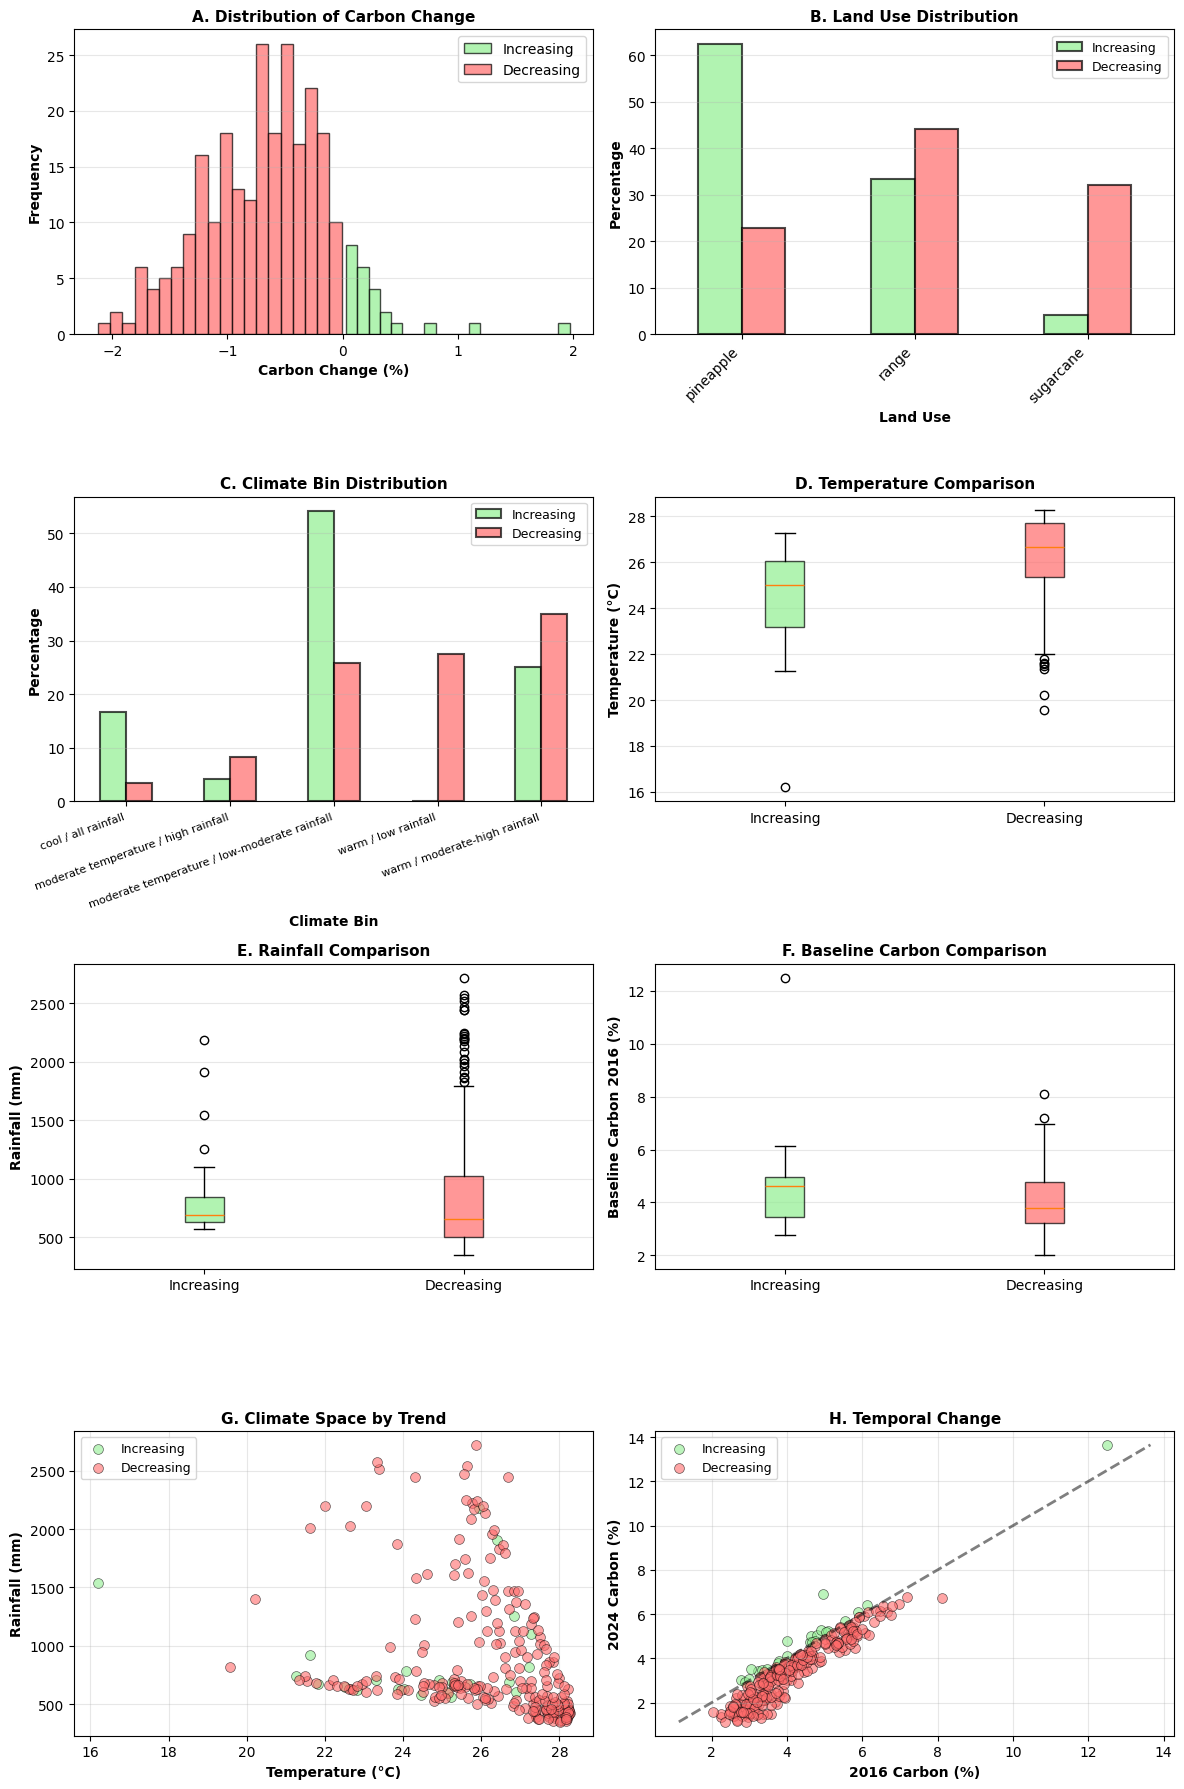

In [264]:
# ============================================================================
# 5. COMPREHENSIVE VISUALIZATIONS
# ============================================================================

fig = plt.figure(figsize=(12, 18))

# A. Change distribution
ax1 = plt.subplot(4, 2, 1)
ax1.hist(increasing['carbon_change'], bins=20, alpha=0.7, color='#90EE90',
         edgecolor='black', label='Increasing')
ax1.hist(decreasing['carbon_change'], bins=20, alpha=0.7, color='#FF6B6B',
         edgecolor='black', label='Decreasing')
ax1.set_xlabel('Carbon Change (%)', fontweight='bold', fontsize=10)
ax1.set_ylabel('Frequency', fontweight='bold', fontsize=10)
ax1.set_title('A. Distribution of Carbon Change', fontweight='bold', fontsize=11)
ax1.legend()
ax1.grid(alpha=0.3, axis='y')

# B. Land use by trend
ax2 = plt.subplot(4, 2, 2)
landuse_comp = pd.DataFrame({
    'Increasing': inc_landuse / len(increasing) * 100,
    'Decreasing': dec_landuse / len(decreasing) * 100
}).fillna(0)
landuse_comp.plot(kind='bar', ax=ax2, color=['#90EE90', '#FF6B6B'], alpha=0.7,
                  edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Land Use', fontweight='bold', fontsize=10)
ax2.set_ylabel('Percentage', fontweight='bold', fontsize=10)
ax2.set_title('B. Land Use Distribution', fontweight='bold', fontsize=11)
ax2.legend(fontsize=9)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax2.grid(alpha=0.3, axis='y')

# C. Climate bins by trend
ax3 = plt.subplot(4, 2, 3)
climate_comp = pd.DataFrame({
    'Increasing': inc_climate / len(increasing) * 100,
    'Decreasing': dec_climate / len(decreasing) * 100
}).fillna(0)
climate_comp.plot(kind='bar', ax=ax3, color=['#90EE90', '#FF6B6B'], alpha=0.7,
                  edgecolor='black', linewidth=1.5)
ax3.set_xlabel('Climate Bin', fontweight='bold', fontsize=10)
ax3.set_ylabel('Percentage', fontweight='bold', fontsize=10)
ax3.set_title('C. Climate Bin Distribution', fontweight='bold', fontsize=11)
ax3.legend(fontsize=9)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=20, ha='right', fontsize=8)
ax3.grid(alpha=0.3, axis='y')

# D. Temperature comparison
ax4 = plt.subplot(4, 2, 4)
bp = ax4.boxplot([increasing['tmax_ann_mean_30m'], decreasing['tmax_ann_mean_30m']],
                  tick_labels=['Increasing', 'Decreasing'], patch_artist=True)
bp['boxes'][0].set_facecolor('#90EE90')
bp['boxes'][1].set_facecolor('#FF6B6B')
for patch in bp['boxes']:
    patch.set_alpha(0.7)
ax4.set_ylabel('Temperature (°C)', fontweight='bold', fontsize=10)
ax4.set_title('D. Temperature Comparison', fontweight='bold', fontsize=11)
ax4.grid(alpha=0.3, axis='y')

# E. Rainfall comparison
ax5 = plt.subplot(4, 2, 5)
bp = ax5.boxplot([increasing['rainfall_ann_mm_30m'], decreasing['rainfall_ann_mm_30m']],
                  tick_labels=['Increasing', 'Decreasing'], patch_artist=True)
bp['boxes'][0].set_facecolor('#90EE90')
bp['boxes'][1].set_facecolor('#FF6B6B')
for patch in bp['boxes']:
    patch.set_alpha(0.7)
ax5.set_ylabel('Rainfall (mm)', fontweight='bold', fontsize=10)
ax5.set_title('E. Rainfall Comparison', fontweight='bold', fontsize=11)
ax5.grid(alpha=0.3, axis='y')

# F. Baseline carbon comparison
ax6 = plt.subplot(4, 2, 6)
bp = ax6.boxplot([increasing['carbon_first_year'], decreasing['carbon_first_year']],
                  tick_labels=['Increasing', 'Decreasing'], patch_artist=True)
bp['boxes'][0].set_facecolor('#90EE90')
bp['boxes'][1].set_facecolor('#FF6B6B')
for patch in bp['boxes']:
    patch.set_alpha(0.7)
ax6.set_ylabel('Baseline Carbon 2016 (%)', fontweight='bold', fontsize=10)
ax6.set_title('F. Baseline Carbon Comparison', fontweight='bold', fontsize=11)
ax6.grid(alpha=0.3, axis='y')

# G. Climate space colored by trend
ax7 = plt.subplot(4, 2, 7)
ax7.scatter(increasing['tmax_ann_mean_30m'], increasing['rainfall_ann_mm_30m'],
           c='#90EE90', alpha=0.6, s=50, edgecolors='black', linewidths=0.5,
           label='Increasing')
ax7.scatter(decreasing['tmax_ann_mean_30m'], decreasing['rainfall_ann_mm_30m'],
           c='#FF6B6B', alpha=0.6, s=50, edgecolors='black', linewidths=0.5,
           label='Decreasing')
ax7.set_xlabel('Temperature (°C)', fontweight='bold', fontsize=10)
ax7.set_ylabel('Rainfall (mm)', fontweight='bold', fontsize=10)
ax7.set_title('G. Climate Space by Trend', fontweight='bold', fontsize=11)
ax7.legend(fontsize=9)
ax7.grid(alpha=0.3)

# H. 2016 vs 2024 carbon
ax8 = plt.subplot(4, 2, 8)
ax8.scatter(increasing['carbon_first_year'], increasing['carbon_last_year'],
           c='#90EE90', alpha=0.6, s=50, edgecolors='black', linewidths=0.5,
           label='Increasing')
ax8.scatter(decreasing['carbon_first_year'], decreasing['carbon_last_year'],
           c='#FF6B6B', alpha=0.6, s=50, edgecolors='black', linewidths=0.5,
           label='Decreasing')
# Add 1:1 line
min_val = polygon_summary[['carbon_first_year', 'carbon_last_year']].min().min()
max_val = polygon_summary[['carbon_first_year', 'carbon_last_year']].max().max()
ax8.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, alpha=0.5)
ax8.set_xlabel('2016 Carbon (%)', fontweight='bold', fontsize=10)
ax8.set_ylabel('2024 Carbon (%)', fontweight='bold', fontsize=10)
ax8.set_title('H. Temporal Change', fontweight='bold', fontsize=11)
ax8.legend(fontsize=9)
ax8.grid(alpha=0.3)


plt.tight_layout()
plt.show()

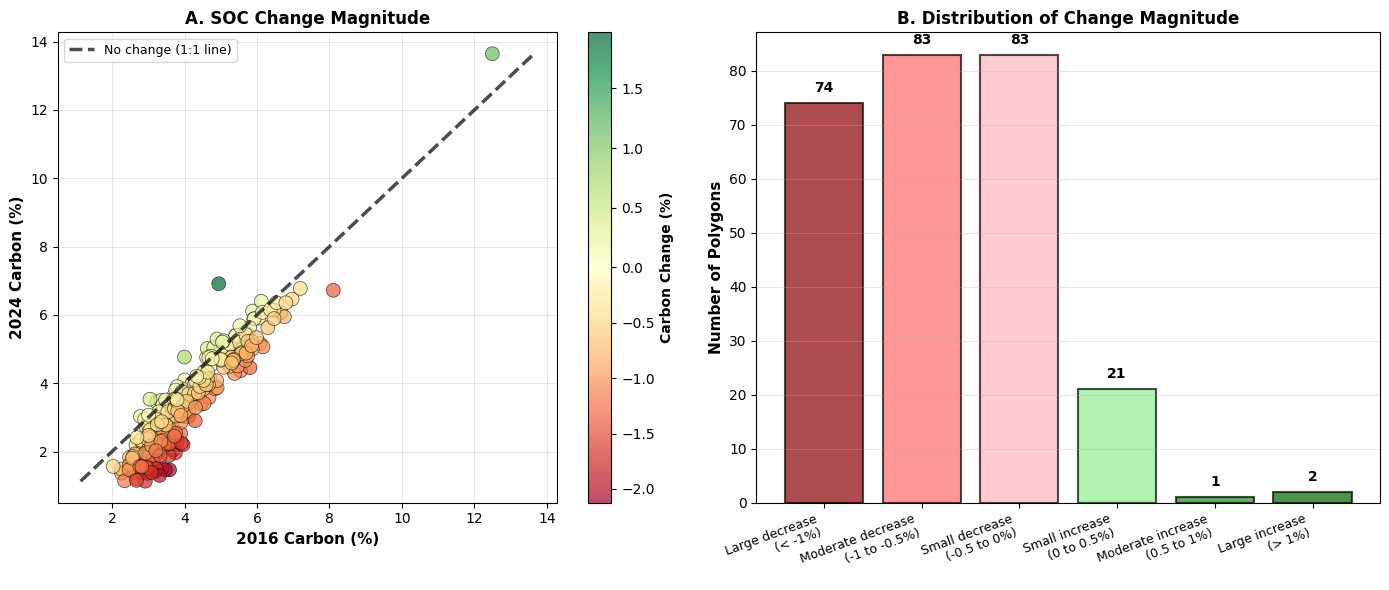

In [265]:
# Change magnitude plotting - Top panels
from matplotlib.colors import TwoSlopeNorm

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# A. 2016 vs 2024 with magnitude (colored)
ax1 = axes[0]
scatter = ax1.scatter(polygon_summary['carbon_first_year'],
                     polygon_summary['carbon_last_year'],
                     c=polygon_summary['carbon_change'],
                     cmap='RdYlGn',
                     norm=TwoSlopeNorm(vmin=polygon_summary['carbon_change'].min(),
                                      vcenter=0,
                                      vmax=polygon_summary['carbon_change'].max()),
                     s=100,
                     alpha=0.7,
                     edgecolors='black',
                     linewidths=0.5)
cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label('Carbon Change (%)', fontweight='bold', fontsize=10)

min_val = polygon_summary[['carbon_first_year', 'carbon_last_year']].min().min()
max_val = polygon_summary[['carbon_first_year', 'carbon_last_year']].max().max()
ax1.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2.5, alpha=0.7,
         label='No change (1:1 line)')

ax1.set_xlabel('2016 Carbon (%)', fontweight='bold', fontsize=11)
ax1.set_ylabel('2024 Carbon (%)', fontweight='bold', fontsize=11)
ax1.set_title('A. SOC Change Magnitude', fontweight='bold', fontsize=12)
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3)

# B. Binned changes - create change magnitude categories
ax2 = axes[1]
polygon_summary['change_category'] = pd.cut(polygon_summary['carbon_change'],
                                            bins=[-np.inf, -1, -0.5, 0, 0.5, 1, np.inf],
                                            labels=['Large decrease\n(< -1%)',
                                                   'Moderate decrease\n(-1 to -0.5%)',
                                                   'Small decrease\n(-0.5 to 0%)',
                                                   'Small increase\n(0 to 0.5%)',
                                                   'Moderate increase\n(0.5 to 1%)',
                                                   'Large increase\n(> 1%)'])

change_cat_counts = polygon_summary['change_category'].value_counts().sort_index()
colors_cat = ['#8B0000', '#FF6B6B', '#FFB6C1', '#90EE90', '#228B22', '#006400']
bars = ax2.bar(range(len(change_cat_counts)), change_cat_counts.values,
               color=colors_cat, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add counts on bars
for i, (cat, count) in enumerate(change_cat_counts.items()):
    ax2.text(i, count + 2, str(count), ha='center', fontweight='bold', fontsize=10)

ax2.set_xticks(range(len(change_cat_counts)))
ax2.set_xticklabels(change_cat_counts.index, rotation=20, ha='right', fontsize=9)
ax2.set_ylabel('Number of Polygons', fontweight='bold', fontsize=11)
ax2.set_title('B. Distribution of Change Magnitude', fontweight='bold', fontsize=12)
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [266]:
# Print details about change magnitude categories
print("\n" + "="*80)
print("CHANGE MAGNITUDE CATEGORIES")
print("="*80)
for cat in change_cat_counts.index:
    subset = polygon_summary[polygon_summary['change_category'] == cat]
    print(f"\n{cat}: n={len(subset)}")
    print(f"  Mean change: {subset['carbon_change'].mean():.3f}%")
    print(f"  Dominant land use: {subset['landuse_current'].mode()[0] if len(subset) > 0 else 'N/A'}")
    print(f"  Dominant climate: {subset['climate_description'].mode()[0] if len(subset) > 0 else 'N/A'}")
    print(f"  Mean temp: {subset['tmax_ann_mean_30m'].mean():.1f}°C")
    print(f"  Mean rainfall: {subset['rainfall_ann_mm_30m'].mean():.0f} mm")


CHANGE MAGNITUDE CATEGORIES

Large decrease
(< -1%): n=74
  Mean change: -1.328%
  Dominant land use: sugarcane
  Dominant climate: warm / low rainfall
  Mean temp: 27.4°C
  Mean rainfall: 604 mm

Moderate decrease
(-1 to -0.5%): n=83
  Mean change: -0.715%
  Dominant land use: range
  Dominant climate: warm / moderate-high rainfall
  Mean temp: 26.1°C
  Mean rainfall: 1057 mm

Small decrease
(-0.5 to 0%): n=83
  Mean change: -0.285%
  Dominant land use: range
  Dominant climate: moderate temperature / low-moderate rainfall
  Mean temp: 25.4°C
  Mean rainfall: 908 mm

Small increase
(0 to 0.5%): n=21
  Mean change: 0.178%
  Dominant land use: pineapple
  Dominant climate: moderate temperature / low-moderate rainfall
  Mean temp: 24.6°C
  Mean rainfall: 800 mm

Moderate increase
(0.5 to 1%): n=1
  Mean change: 0.769%
  Dominant land use: pineapple
  Dominant climate: warm / moderate-high rainfall
  Mean temp: 26.4°C
  Mean rainfall: 1910 mm

Large increase
(> 1%): n=2
  Mean change: 1.

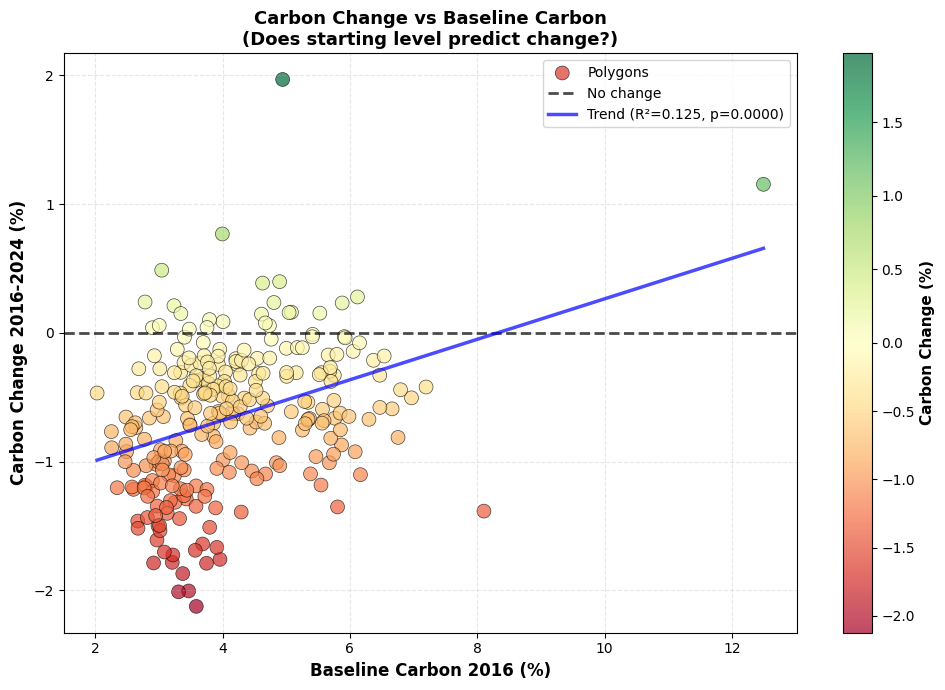


Interpretation:
  • Polygons with HIGHER baseline carbon show GREATER increases (slope=0.1572)
  • This relationship is statistically significant (p=0.0000)


In [267]:
# C. Change magnitude by baseline carbon
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import linregress

fig, ax = plt.subplots(figsize=(10, 7))

scatter = ax.scatter(polygon_summary['carbon_first_year'],
                     polygon_summary['carbon_change'],
                     c=polygon_summary['carbon_change'],
                     cmap='RdYlGn',
                     norm=TwoSlopeNorm(vmin=polygon_summary['carbon_change'].min(),
                                      vcenter=0,
                                      vmax=polygon_summary['carbon_change'].max()),
                     s=100,
                     alpha=0.7,
                     edgecolors='black',
                     linewidths=0.5,
                     label='Polygons')

# Add colorbar as legend
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Carbon Change (%)', fontweight='bold', fontsize=11)

# Add zero reference line
ax.axhline(0, color='black', linestyle='--', linewidth=2, alpha=0.7,
           label='No change')

# Add regression line
slope, intercept, r, p, se = linregress(polygon_summary['carbon_first_year'].dropna(),
                                        polygon_summary['carbon_change'].dropna())
x_range = np.linspace(polygon_summary['carbon_first_year'].min(),
                     polygon_summary['carbon_first_year'].max(), 100)
ax.plot(x_range, slope * x_range + intercept, 'b-', linewidth=2.5, alpha=0.7,
        label=f'Trend (R²={r**2:.3f}, p={p:.4f})')

# Add axis labels
ax.set_xlabel('Baseline Carbon 2016 (%)', fontweight='bold', fontsize=12)
ax.set_ylabel('Carbon Change 2016-2024 (%)', fontweight='bold', fontsize=12)
ax.set_title('Carbon Change vs Baseline Carbon\n(Does starting level predict change?)',
             fontweight='bold', fontsize=13)

# Add legend
ax.legend(fontsize=10, loc='best')

# Add grid
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Print interpretation
print("\nInterpretation:")
if p < 0.05:
    if slope > 0:
        print(f"  • Polygons with HIGHER baseline carbon show GREATER increases (slope={slope:.4f})")
    else:
        print(f"  • Polygons with HIGHER baseline carbon show GREATER decreases (slope={slope:.4f})")
    print(f"  • This relationship is statistically significant (p={p:.4f})")
else:
    print(f"  • No significant relationship between baseline carbon and change (p={p:.4f})")
    print(f"  • Starting carbon level does not predict the direction or magnitude of change")

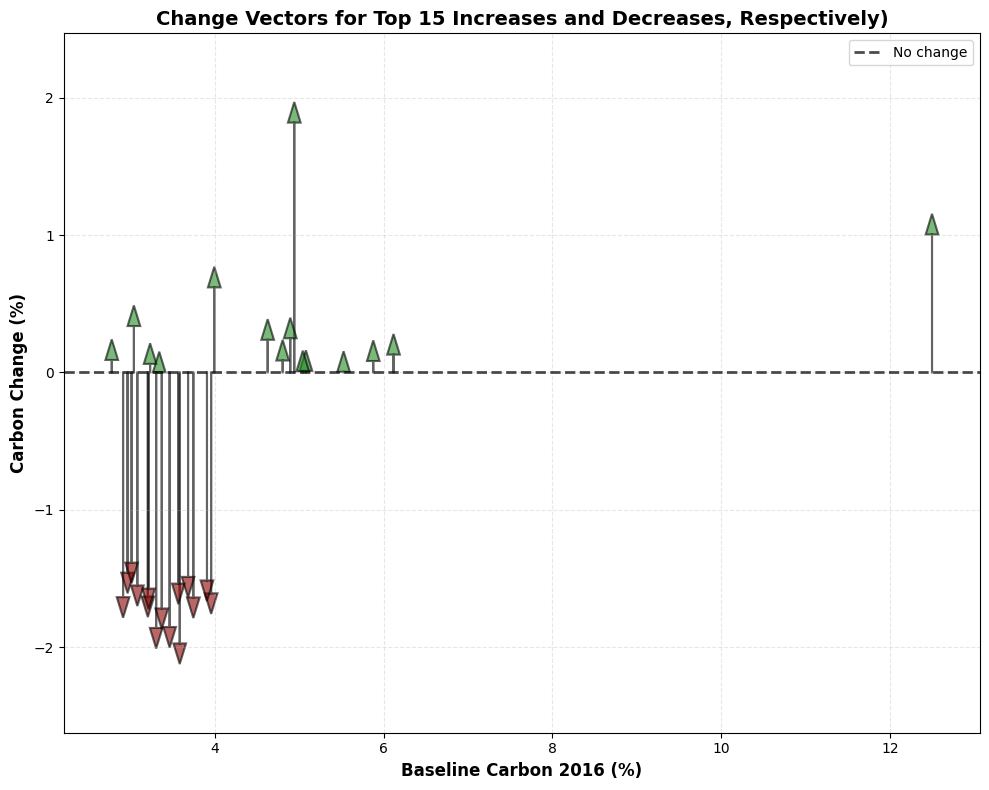


Showing 15 largest increases and 15 largest decreases

Largest increases:
 carbon_first_year  carbon_change landuse_current                          climate_description
          4.943487       1.968592       pineapple moderate temperature / low-moderate rainfall
         12.493938       1.154235           range                          cool / all rainfall
          3.996374       0.768750       pineapple                warm / moderate-high rainfall
          3.044648       0.487292       pineapple moderate temperature / low-moderate rainfall
          4.896063       0.398194       pineapple moderate temperature / low-moderate rainfall
          4.628406       0.387159       pineapple moderate temperature / low-moderate rainfall
          6.118371       0.279398           range                          cool / all rainfall
          2.782554       0.240285       pineapple moderate temperature / low-moderate rainfall
          4.805931       0.236270       pineapple moderate temperature

In [268]:
# Standalone: Arrows showing direction and magnitude for selected polygons
fig, ax = plt.subplots(figsize=(10, 8))

# Select polygons to show (largest increases and decreases)
n_show = 15
largest_inc = polygon_summary.nlargest(n_show, 'carbon_change')
largest_dec = polygon_summary.nsmallest(n_show, 'carbon_change')
selected = pd.concat([largest_inc, largest_dec])

for idx, row in selected.iterrows():
    color = '#228B22' if row['carbon_change'] > 0 else '#8B0000'
    # Arrow starts at baseline carbon, 0 change
    # Arrow points upward (positive) or downward (negative) by the amount of change
    ax.arrow(row['carbon_first_year'], 0,
             0, row['carbon_change'],
             head_width=0.15, head_length=0.15,
             fc=color, ec='black', alpha=0.6, linewidth=1.5,
             length_includes_head=True)

# Add zero reference line
ax.axhline(0, color='black', linestyle='--', linewidth=2, alpha=0.7, label='No change')

ax.set_xlabel('Baseline Carbon 2016 (%)', fontweight='bold', fontsize=12)
ax.set_ylabel('Carbon Change (%)', fontweight='bold', fontsize=12)
ax.set_title(f'Change Vectors for Top {n_show} Increases and Decreases, Respectively)',
             fontweight='bold', fontsize=14)
ax.legend(fontsize=10)
ax.grid(alpha=0.3, linestyle='--')
ax.set_ylim(polygon_summary['carbon_change'].min() - 0.5,
            polygon_summary['carbon_change'].max() + 0.5)

plt.tight_layout()
plt.show()

print(f"\nShowing {n_show} largest increases and {n_show} largest decreases")
print(f"\nLargest increases:")
print(largest_inc[['carbon_first_year', 'carbon_change', 'landuse_current', 'climate_description']].to_string(index=False))
print(f"\nLargest decreases:")
print(largest_dec[['carbon_first_year', 'carbon_change', 'landuse_current', 'climate_description']].to_string(index=False))

In [269]:
# ============================================================================
# 6. MULTIVARIATE COMPARISON
# ============================================================================
print("\n" + "="*80)
print("MULTIVARIATE PROFILE COMPARISON")
print("="*80)

# Create summary profiles
increasing_profile = {
    'Temperature (°C)': increasing['tmax_ann_mean_30m'].mean(),
    'Rainfall (mm)': increasing['rainfall_ann_mm_30m'].mean(),
    'Baseline Carbon (%)': increasing['carbon_first_year'].mean(),
    '2024 Carbon (%)': increasing['carbon_last_year'].mean(),
    'Carbon Change (%)': increasing['carbon_change'].mean(),
    'Dominant Land Use': increasing['landuse_current'].mode()[0] if len(increasing) > 0 else 'N/A',
    'Dominant Climate': increasing['climate_description'].mode()[0] if len(increasing) > 0 else 'N/A',
    'Dominant Suborder': increasing['Suborder_list'].mode()[0] if len(increasing) > 0 else 'N/A'
}

decreasing_profile = {
    'Temperature (°C)': decreasing['tmax_ann_mean_30m'].mean(),
    'Rainfall (mm)': decreasing['rainfall_ann_mm_30m'].mean(),
    'Baseline Carbon (%)': decreasing['carbon_first_year'].mean(),
    '2024 Carbon (%)': decreasing['carbon_last_year'].mean(),
    'Carbon Change (%)': decreasing['carbon_change'].mean(),
    'Dominant Land Use': decreasing['landuse_current'].mode()[0] if len(decreasing) > 0 else 'N/A',
    'Dominant Climate': decreasing['climate_description'].mode()[0] if len(decreasing) > 0 else 'N/A',
    'Dominant Suborder': decreasing['Suborder_list'].mode()[0] if len(decreasing) > 0 else 'N/A'
}

profile_df = pd.DataFrame({
    'Increasing Polygons': increasing_profile,
    'Decreasing Polygons': decreasing_profile
})

print("\nProfile Comparison:")
print(profile_df)

# Save results
profile_df.to_csv('carbon_trend_profiles.csv')
transition_change.to_csv('carbon_change_by_transition.csv')
suborder_change.to_csv('carbon_change_by_suborder.csv')

print("\n✓ Results saved:")
print("  - carbon_trend_profiles.csv")
print("  - carbon_change_by_transition.csv")
print("  - carbon_change_by_suborder.csv")



MULTIVARIATE PROFILE COMPARISON

Profile Comparison:
                                              Increasing Polygons  \
Temperature (°C)                                        24.362893   
Rainfall (mm)                                          872.841366   
Baseline Carbon (%)                                      4.615802   
2024 Carbon (%)                                          4.933693   
Carbon Change (%)                                        0.317891   
Dominant Land Use                                       pineapple   
Dominant Climate     moderate temperature / low-moderate rainfall   
Dominant Suborder                                         Cambids   

                               Decreasing Polygons  
Temperature (°C)                         26.249787  
Rainfall (mm)                           865.924481  
Baseline Carbon (%)                       4.082435  
2024 Carbon (%)                           3.327264  
Carbon Change (%)                        -0.755171  
Domina

In [270]:
import os
# ============================================================================
# Join everything together into gpkg
# ============================================================================

# Step 1: Load the carbon points (without any previous joins)

# Check what we have
print(f"carbon_landuse shape: {carbon_landuse.shape}")
print(f"carbon_landuse columns: {carbon_landuse.columns.tolist()}")

# Get just the essential carbon data and geometry
carbon_points = carbon_landuse[['id', 'lat', 'lon', 'carbon_mean', 'carbon_first_year',
                                'carbon_last_year', 'carbon_change', 'geometry']].copy()
carbon_points = gpd.GeoDataFrame(carbon_points, geometry='geometry', crs=carbon_landuse.crs)

print(f"Carbon points: {len(carbon_points)}")

# Step 2: Load agbaseline

agbaseline = gpd.read_file('/content/2015_ag_baseline_subregion_landuse.gpkg')
print(f"AgBaseline: {len(agbaseline)} polygons")
print(f"OBJECTID sample: {agbaseline['OBJECTID'].head(10).tolist()}")

# Step 3: Do a fresh spatial join
print("\nStep 3: Performing spatial join")
print("-"*80)

# Make sure CRS match
if carbon_points.crs != agbaseline.crs:
    print(f"Reprojecting carbon points from {carbon_points.crs} to {agbaseline.crs}")
    carbon_points = carbon_points.to_crs(agbaseline.crs)

# Spatial join - this will add agbaseline columns including OBJECTID
carbon_joined = gpd.sjoin(carbon_points, agbaseline[['OBJECTID', 'CropCatego', 'Island', 'geometry']],
                          how='inner', predicate='intersects')

print(f"Joined points: {len(carbon_joined)}")
print(f"Columns after join: {carbon_joined.columns.tolist()}")

# Check if OBJECTID is preserved
if 'OBJECTID' in carbon_joined.columns:
    print(f"✓ OBJECTID preserved in join")
    print(f"  OBJECTID range: {carbon_joined['OBJECTID'].min()} to {carbon_joined['OBJECTID'].max()}")
    print(f"  Unique OBJECTIDs: {carbon_joined['OBJECTID'].nunique()}")

    # Step 4: Aggregate to polygons using ACTUAL OBJECTID
    print("\nStep 4: Aggregating to polygons by OBJECTID")
    print("-"*80)

    polygon_aggregated = carbon_joined.groupby('OBJECTID').agg({
        'carbon_mean': 'mean',
        'carbon_first_year': 'mean',
        'carbon_last_year': 'mean',
        'carbon_change': 'mean',
        'id': 'count'
    }).reset_index()

    polygon_aggregated.columns = ['OBJECTID', 'carbon_mean', 'carbon_2016', 'carbon_2024',
                                  'carbon_change', 'n_points']

    print(f"Aggregated polygons: {len(polygon_aggregated)}")
    print(f"Sample:")
    print(polygon_aggregated.head())

    # Add other attributes from polygon_summary if available
    # We need to create a mapping from old poly_id to OBJECTID

    # Get the mapping: which poly_id corresponds to which OBJECTID
    poly_id_to_objectid = carbon_joined.groupby('OBJECTID').first().reset_index()[['OBJECTID']]
    poly_id_to_objectid['poly_id'] = range(len(poly_id_to_objectid))

    print(f"\nMapping poly_id to OBJECTID:")
    print(poly_id_to_objectid.head())

    # Now merge polygon_summary attributes using this mapping
    # First add OBJECTID to polygon_summary
    polygon_summary_with_obj = polygon_summary.merge(poly_id_to_objectid[['poly_id', 'OBJECTID']],
                                                      on='poly_id', how='left')

    # Check overlap
    print(f"\nPolygon summary with OBJECTID:")
    print(f"  Rows: {len(polygon_summary_with_obj)}")
    print(f"  OBJECTID range: {polygon_summary_with_obj['OBJECTID'].min()} to {polygon_summary_with_obj['OBJECTID'].max()}")
    print(f"  Sample OBJECTIDs: {polygon_summary_with_obj['OBJECTID'].head(10).tolist()}")

    # Step 5: Merge aggregated carbon data with full polygon_summary attributes
    print("\nStep 5: Merging aggregated carbon with polygon attributes")
    print("-"*80)

    # Drop geometry from polygon_summary if exists
    polygon_attrs = polygon_summary_with_obj.drop(columns=['geometry'], errors='ignore')

    # Merge
    full_polygon_data = polygon_aggregated.merge(
        polygon_attrs[['OBJECTID', 'landuse_historic', 'landuse_current', 'transition',
                      'land_use_changed', 'tmax_ann_mean_30m', 'rainfall_ann_mm_30m',
                      'climate_description', 'Suborder_list', 'carbon_trend', 'change_category']],
        on='OBJECTID',
        how='left'
    )

    print(f"Full polygon data: {len(full_polygon_data)}")
    print(f"Columns: {full_polygon_data.columns.tolist()}")

    # Step 6: Merge with agbaseline geometries
    print("\nStep 6: Adding geometries from AgBaseline")
    print("-"*80)

    final_gdf = agbaseline.merge(full_polygon_data, on='OBJECTID', how='inner')

    print(f"Final GeoDataFrame: {len(final_gdf)} features")

    if len(final_gdf) > 0:
        final_gdf = gpd.GeoDataFrame(final_gdf, geometry='geometry', crs=agbaseline.crs)

        print(f"  CRS: {final_gdf.crs}")
        print(f"  Geometry types: {final_gdf.geometry.type.value_counts().to_dict()}")
        print(f"  Bounds: {final_gdf.total_bounds}")

        # Step 7: Clean up and save
        print("\nStep 7: Saving geopackage")
        print("-"*80)

        # Select essential columns
        cols_to_keep = ['OBJECTID', 'CropCatego', 'Island', 'carbon_mean', 'carbon_2016',
                       'carbon_2024', 'carbon_change', 'n_points', 'landuse_historic',
                       'landuse_current', 'transition', 'land_use_changed',
                       'tmax_ann_mean_30m', 'rainfall_ann_mm_30m', 'climate_description',
                       'Suborder_list', 'carbon_trend', 'change_category', 'geometry']

        export_cols = [col for col in cols_to_keep if col in final_gdf.columns]
        gdf_export = final_gdf[export_cols].copy()

        # Rename for clarity
        gdf_export = gdf_export.rename(columns={
            'tmax_ann_mean_30m': 'temp_C',
            'rainfall_ann_mm_30m': 'rainfall_mm',
            'climate_description': 'climate_bin',
            'Suborder_list': 'soil_suborder'
        })

        # Save
        output_file = '/content/carbon_polygons_WORKING.gpkg'
        gdf_export.to_file(output_file, driver='GPKG', layer='carbon')

        print(f"✓ Saved to: {output_file}")
        print(f"  Features: {len(gdf_export)}")

        # Verify
        verify = gpd.read_file(output_file)
        print(f"\n✓ Verification:")
        print(f"  Features: {len(verify)}")
        print(f"  Geometry types: {verify.geometry.type.value_counts().to_dict()}")
        print(f"  File size: {os.path.getsize(output_file):,} bytes")

        print("\n" + "="*80)
        print("SUCCESS! Download 'carbon_polygons_WORKING.gpkg'")
        print("="*80)

else:
    print("✗ OBJECTID not found in joined data")
    print("Available columns:", carbon_joined.columns.tolist())

carbon_landuse shape: (274505, 247)
carbon_landuse columns: ['field_1', 'id', 'lat', 'lon', 'lat_lon_id', 'landsat_9_unique_locs_id', 'landsat_9_unique_locs_min_dis', 'landsat_8_unique_locs_id', 'landsat_8_unique_locs_min_dis', 'landsat_7_unique_locs_id', 'landsat_7_unique_locs_min_dis', 'landsat_5_unique_locs_id', 'landsat_5_unique_locs_min_dis', 'terrain_SRTM_unique_locs_id', 'terrain_SRTM_unique_locs_min_dis', 'terrain_aspect_unique_locs_id', 'terrain_aspect_unique_locs_min_dis', 'terraclimate_unique_locs_id', 'terraclimate_unique_locs_min_dis', 'terrain_elevation_unique_locs_id', 'terrain_elevation_unique_locs_min_dis', 'terrain_slope_unique_locs_id', 'terrain_slope_unique_locs_min_dis', 'd_20161217', 'd_20170116', 'd_20170215', 'd_20170317', 'd_20170416', 'd_20170516', 'd_20170615', 'd_20170715', 'd_20170814', 'd_20170913', 'd_20171013', 'd_20171112', 'd_20171212', 'd_20180111', 'd_20180210', 'd_20180312', 'd_20180411', 'd_20180511', 'd_20180610', 'd_20180710', 'd_20180809', 'd_20